# Cross-Country Epidemic Viz 

In [1]:
library(LalRUtils)
libreq(data.table, tidyverse, sf, janitor, anytime, lubridate, plotly, zoo, patchwork, ggrepel)
theme_set(lal_plot_theme_d())
options(repr.plot.width = 20, repr.plot.height=12)

      wants        loaded
 [1,] "data.table" TRUE  
 [2,] "tidyverse"  TRUE  
 [3,] "sf"         TRUE  
 [4,] "janitor"    TRUE  
 [5,] "anytime"    TRUE  
 [6,] "lubridate"  TRUE  
 [7,] "plotly"     TRUE  
 [8,] "zoo"        TRUE  
 [9,] "patchwork"  TRUE  
[10,] "ggrepel"    TRUE  


# JHU

In [2]:
jhu_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
cases = fread(jhu_cases_url)

jhu_deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
deaths = fread(jhu_deaths_url)

In [3]:
name_clean = function(df) setnames(df, str_replace(colnames(df), "/", "_"))

In [4]:
cases_long = melt(cases, id.vars = c("Province/State", "Country/Region", "Lat", "Long"), 
    variable.name = "date", value.name = "cases") 
name_clean(cases_long)

deaths_long = melt(deaths, id.vars = c("Province/State", "Country/Region", "Lat", "Long"), 
    variable.name = "date", value.name = "deaths") 
name_clean(deaths_long)
deaths_long[, c('Lat', 'Long') := NULL]

In [5]:
df = merge(cases_long, deaths_long,
      by = c("Province_State", "Country_Region", "date"), all.x = T)
df[, date := mdy(date)]
df[, day := weekdays(date)]
df[is.na(df)] = 0
df %>% glimpse

Rows: 43,092
Columns: 8
$ Province_State <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", ""…
$ Country_Region <chr> "Afghanistan", "Afghanistan", "Afghanistan", "Afghanis…
$ date           <date> 2020-01-22, 2020-01-23, 2020-01-24, 2020-01-25, 2020-…
$ Lat            <dbl> 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33…
$ Long           <dbl> 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65…
$ cases          <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ deaths         <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ day            <chr> "Wednesday", "Thursday", "Friday", "Saturday", "Sunday…


In [6]:
fwrite(df, "data/jhu_panel.csv")

## Country Level

In [7]:
country_ts = df[, lapply(.SD, sum) , by = .(Country_Region, date), .SDcols = c("cases", "deaths")]

In [8]:
(t10countries = country_ts[date == max(country_ts$date)][order(-cases)][1:10])

Country_Region date       cases   deaths
1  US             2020-07-01 2687588 128105
2  Brazil         2020-07-01 1448753  60632
3  Russia         2020-07-01  653479   9521
4  India          2020-07-01  604641  17834
5  United Kingdom 2020-07-01  314992  43991
6  Peru           2020-07-01  288477   9860
7  Chile          2020-07-01  282043   5753
8  Spain          2020-07-01  249659  28364
9  Italy          2020-07-01  240760  34788
10 Mexico         2020-07-01  231770  28510

In [9]:
t10_subset = country_ts[Country_Region %in% t10countries$Country_Region]
setorder(t10_subset, Country_Region, date)
# normalise time from first day with >= 10 cases
t10_subset[cases >= 10,  c_time := seq_len(.N), by = .(Country_Region)]
t10_subset[deaths >= 1, d_time := seq_len(.N), by = .(Country_Region)]

In [10]:
setorder(t10_subset, Country_Region, date)
t10_subset[, new_cases  := cases - shift(cases), by = .(Country_Region)]
t10_subset[, new_deaths := deaths - shift(deaths), by = .(Country_Region)]
t10_subset[, cfr := deaths/cases]
smoothvars = c('cases', 'new_cases', 'deaths', 'new_deaths', 'cfr')
t10_subset[, paste0("rm7_", smoothvars) := lapply(.SD, rollmean, k = 7, fill = NA, na.pad = T), 
   by = .(Country_Region), .SDcols = smoothvars]

In [11]:
t10_subset[, label := ifelse(date == max(date), Country_Region, NA)]

## Cumulative and New Cases / Deaths 

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 386 rows containing missing values (geom_point).”
Warning message:
“Removed 417 row(s) containing missing values (geom_path).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 428 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 390 rows 

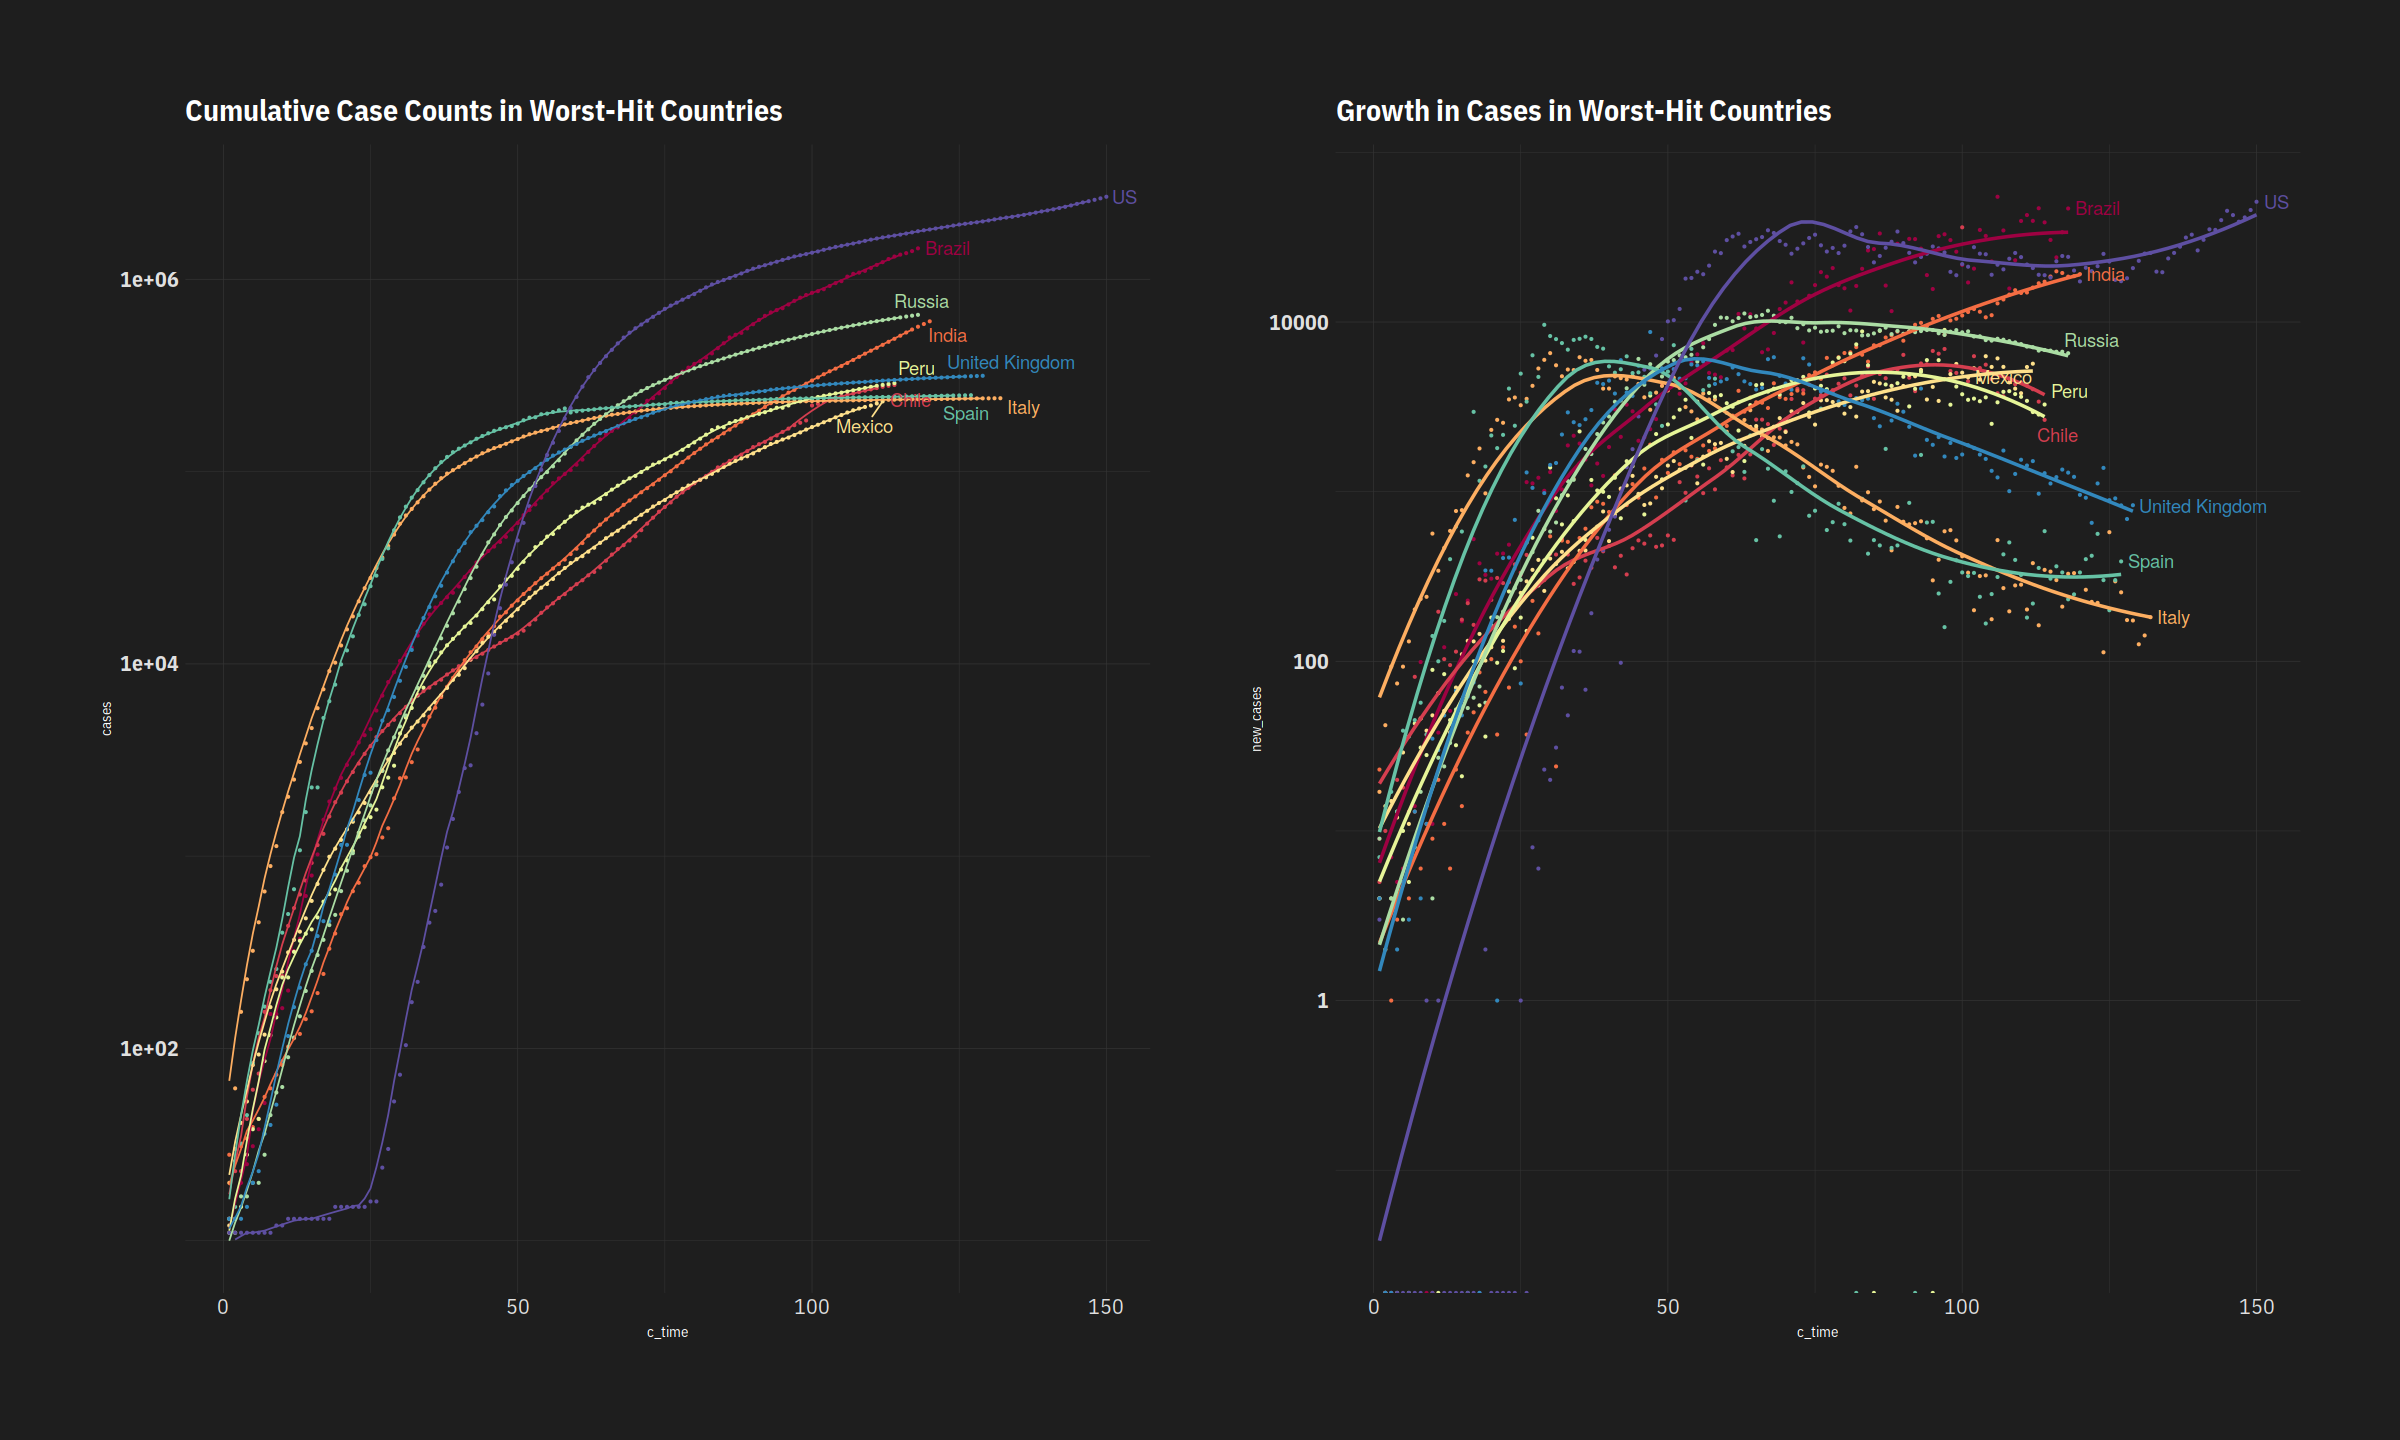

In [12]:
p1 = ggplot(t10_subset,
           aes(x = c_time, y = cases, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = cases), size = 0.5) + geom_line(aes(y = rm7_cases)) + 
    scale_y_log10(limits = c(10, NA)) + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Cumulative Case Counts in Worst-Hit Countries') 

p2 = 
    t10_subset %>% 
    ggplot(aes(x = c_time,y = new_cases, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = new_cases), size = 0.5) + 
#     geom_line(aes(y = rm7_new_cases)) + 
    geom_smooth(se = F) +
    scale_y_log10() + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Growth in Cases in Worst-Hit Countries')

(p1 | p2 )

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Removed 559 rows containing missing values (geom_point).”
Warning message:
“Removed 586 row(s) containing missing values (geom_path).”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message in self$trans$transform(x):
“NaNs produced”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 533 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 492 rows 

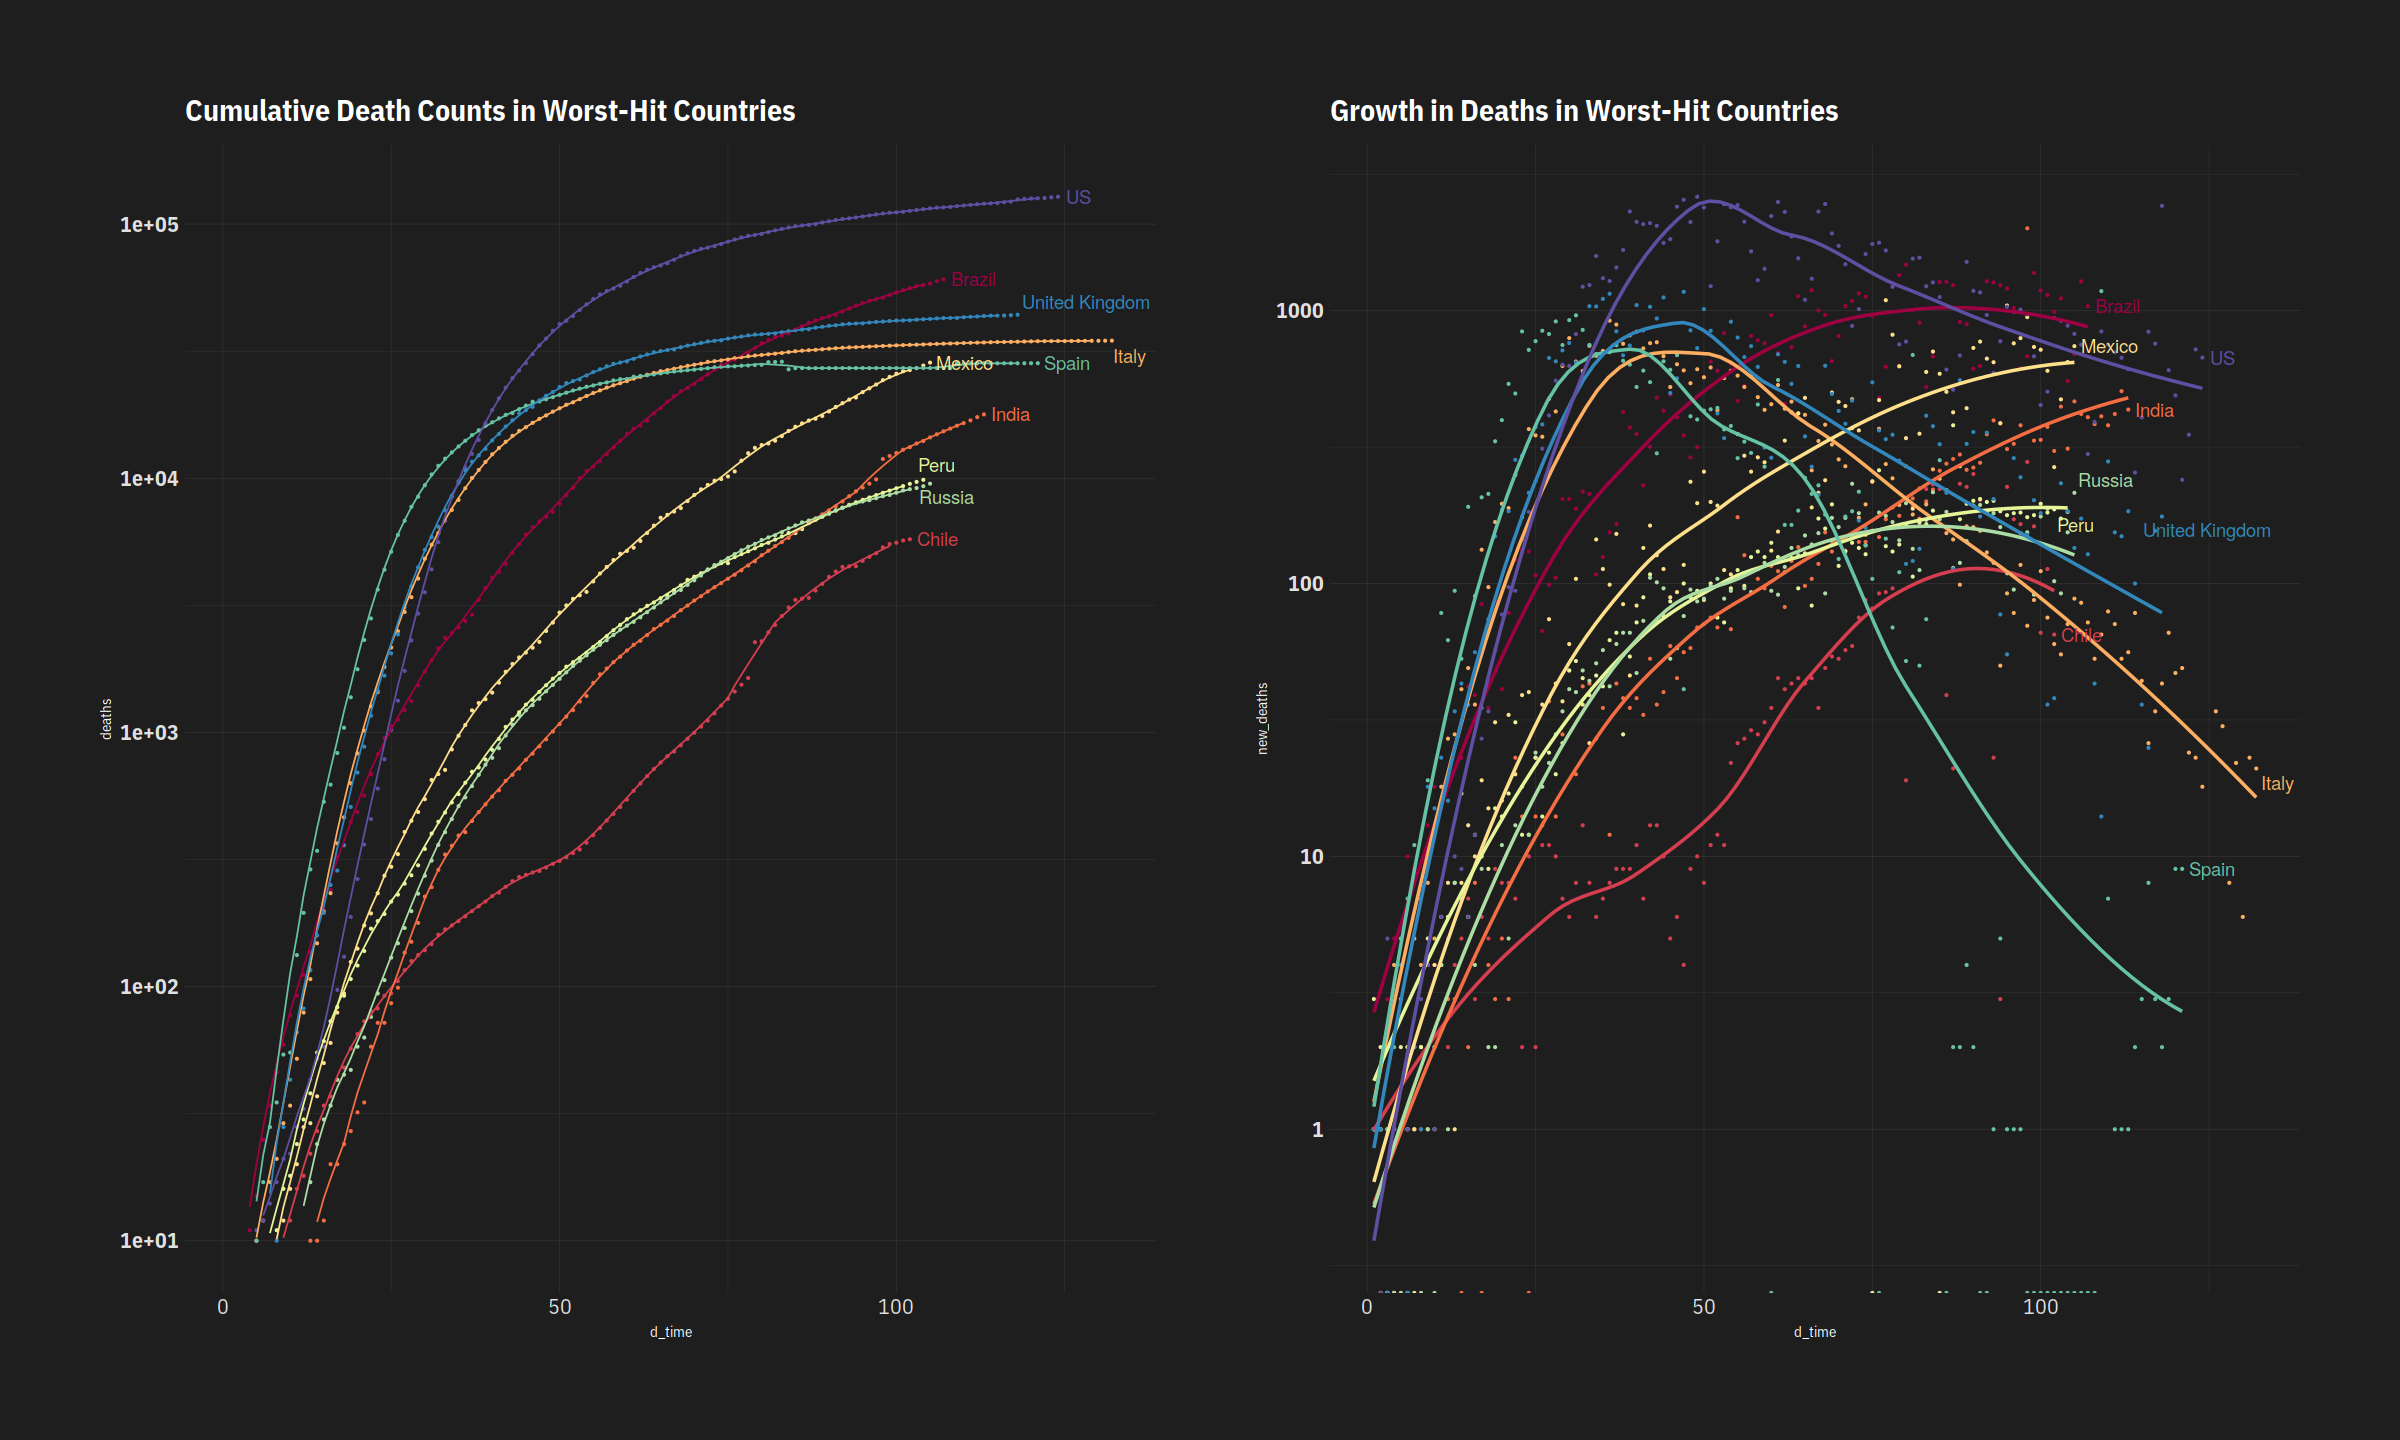

In [13]:
p1 = ggplot(t10_subset,
           aes(x = d_time, y = deaths, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = deaths), size = 0.5) + geom_line(aes(y = rm7_deaths)) + 
    scale_y_log10(limits = c(10, NA)) + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Cumulative Death Counts in Worst-Hit Countries') 

p2 =  t10_subset %>% 
    ggplot(aes(x = d_time, y = new_deaths, group = Country_Region, colour = Country_Region)) + 
    geom_point(aes(y = new_deaths), size = 0.5) + 
    geom_smooth(se = F) +
    scale_y_log10() + 
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      nudge_x = 1,
                      na.rm = TRUE) +
    ggtitle('Growth in Deaths in Worst-Hit Countries')

(p1 | p2 )

## Case Fatality Rate

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 489 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 489 rows containing missing values (geom_point).”
Warning message:
“Removed 5 rows containing missing values (geom_smooth).”


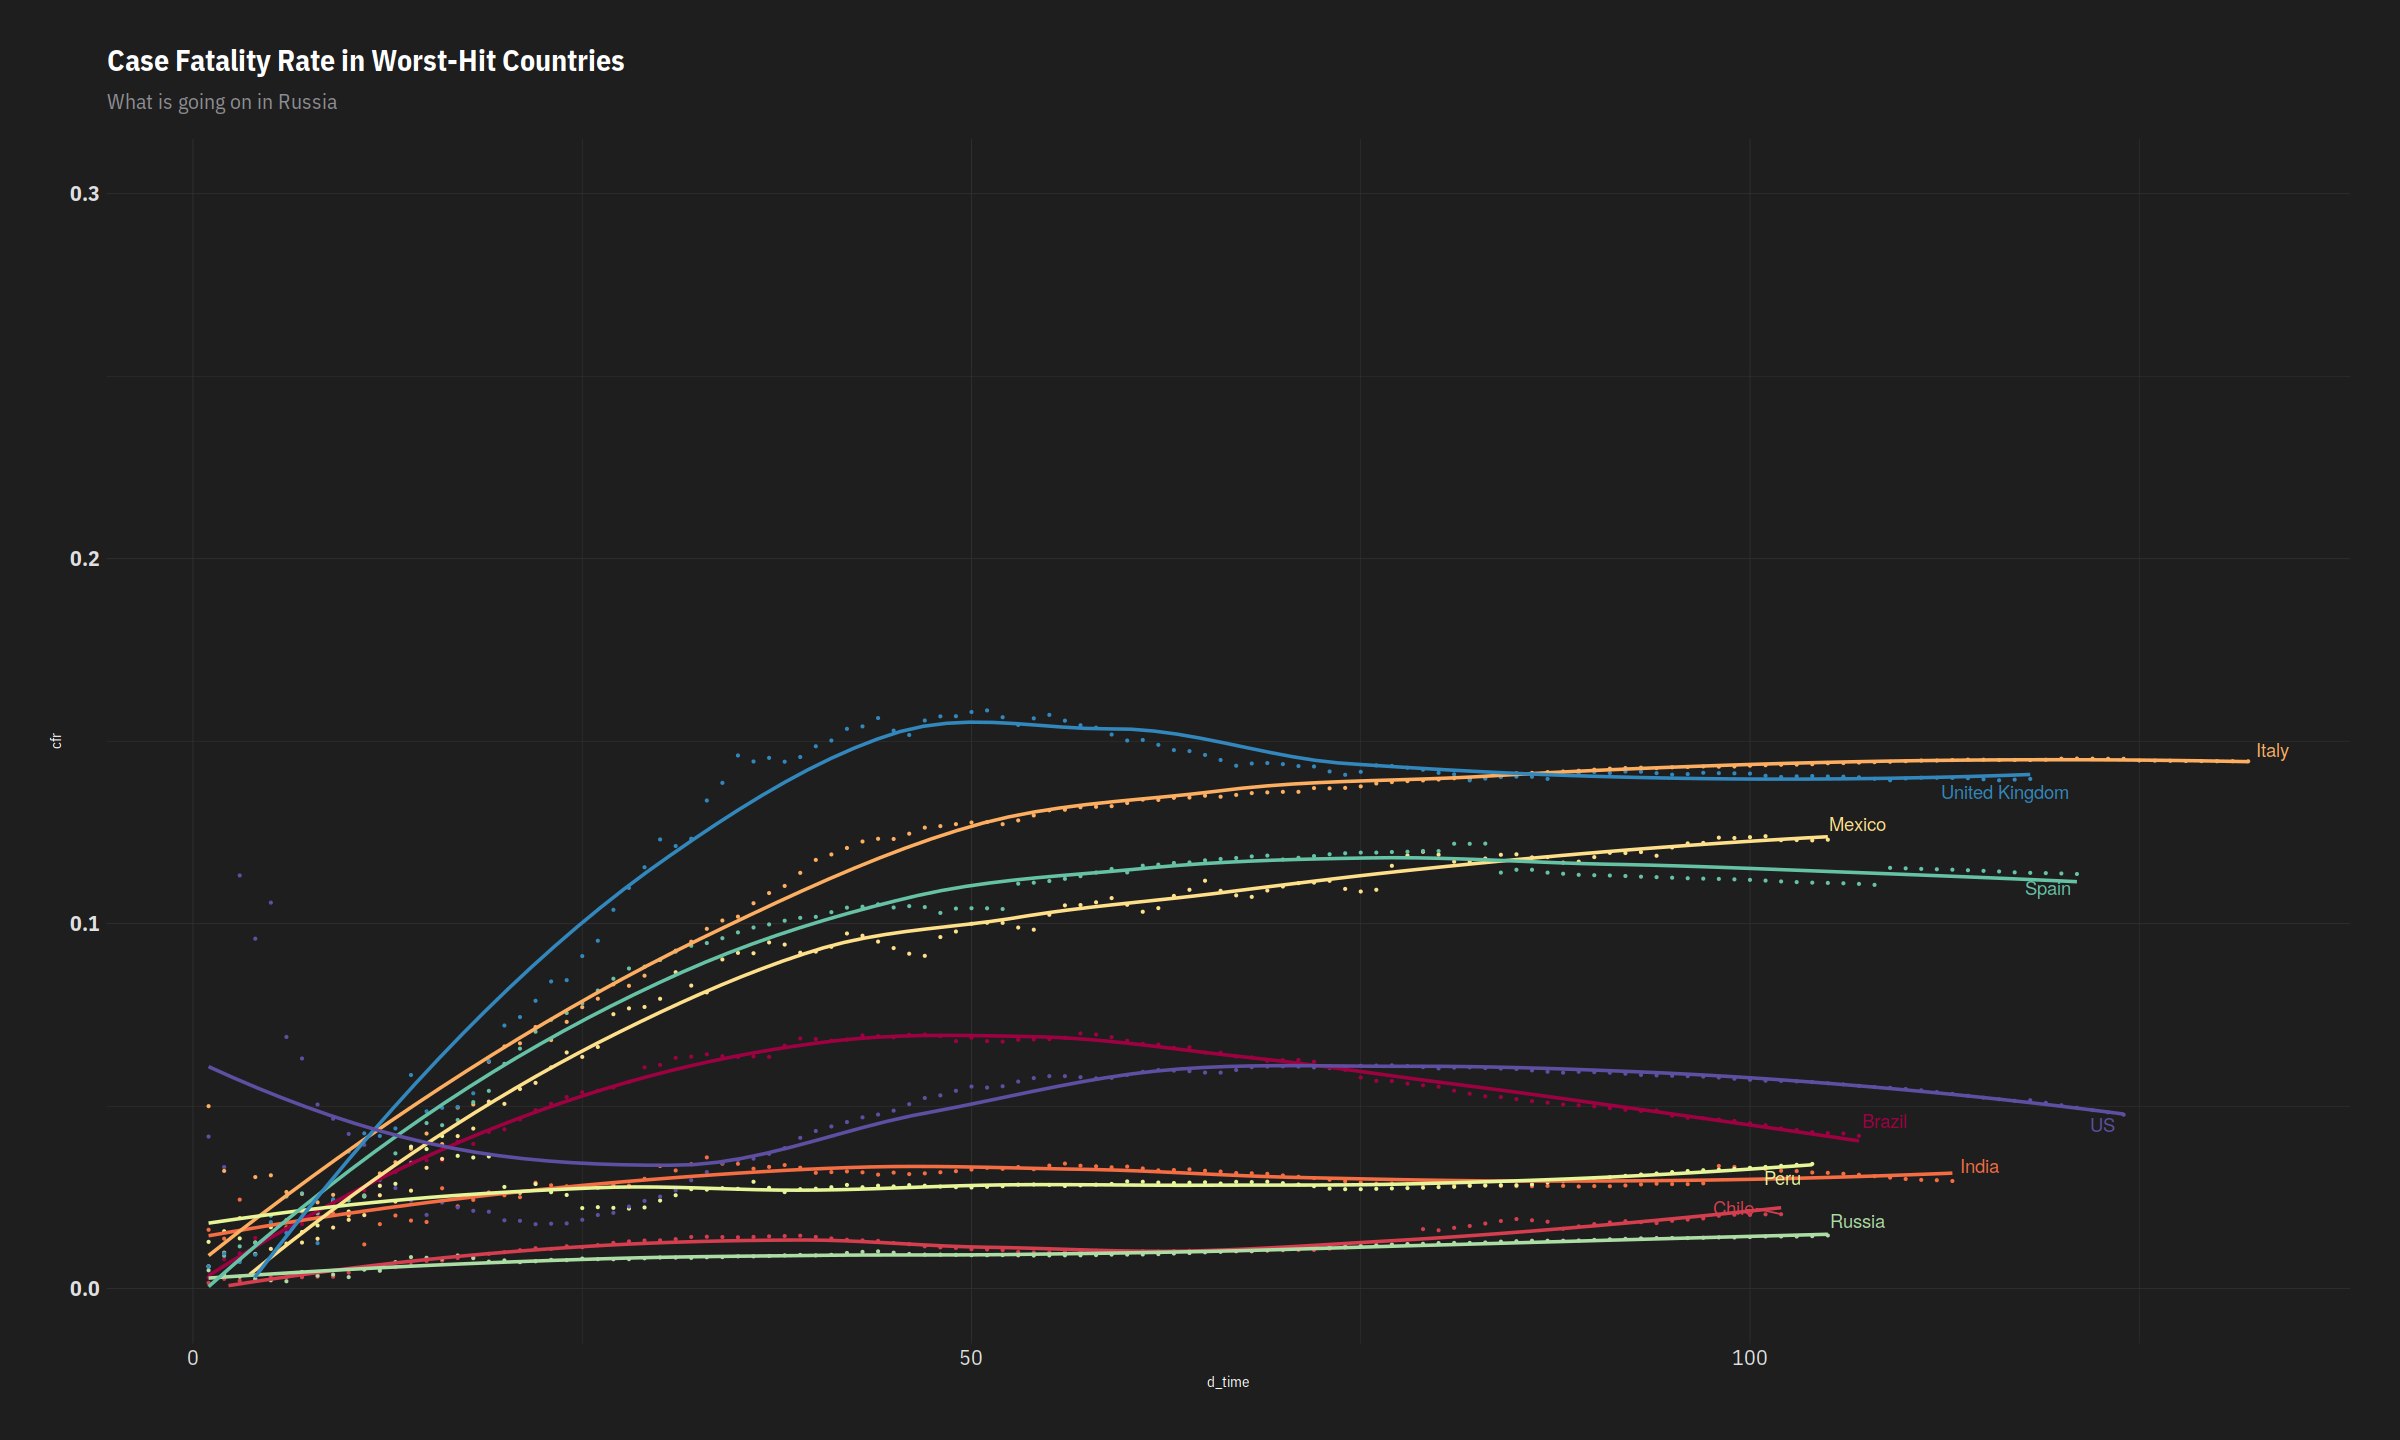

In [14]:
p3 =  t10_subset %>% 
    ggplot(aes(x = d_time, y = cfr, group = Country_Region, colour = Country_Region)) + 
    geom_point(size = 0.5) + 
#     geom_line(aes(y = rm7_cfr)) + 
    geom_smooth(se = F) +
    ylim(c(0, 0.3)) +
    scale_colour_brewer(palette = "Spectral") +
    theme(legend.position = "None") +
    geom_text_repel(aes(label = label),
                      na.rm = TRUE) +
    labs(title = 'Case Fatality Rate in Worst-Hit Countries', subtitle = "What is going on in Russia")
p3

## Shares

In [15]:
t10_subset[, denom_cases := sum(rm7_new_cases), by = date][, 
            denom_deaths := sum(rm7_new_deaths), by = date]
t10_subset[, newcase_share := rm7_new_cases / denom_cases][, 
            newdeath_share := rm7_new_deaths /denom_deaths]

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 40 rows containing missing values (position_stack).”
Warning message:
“Removed 67 rows containing missing values (position_stack).”


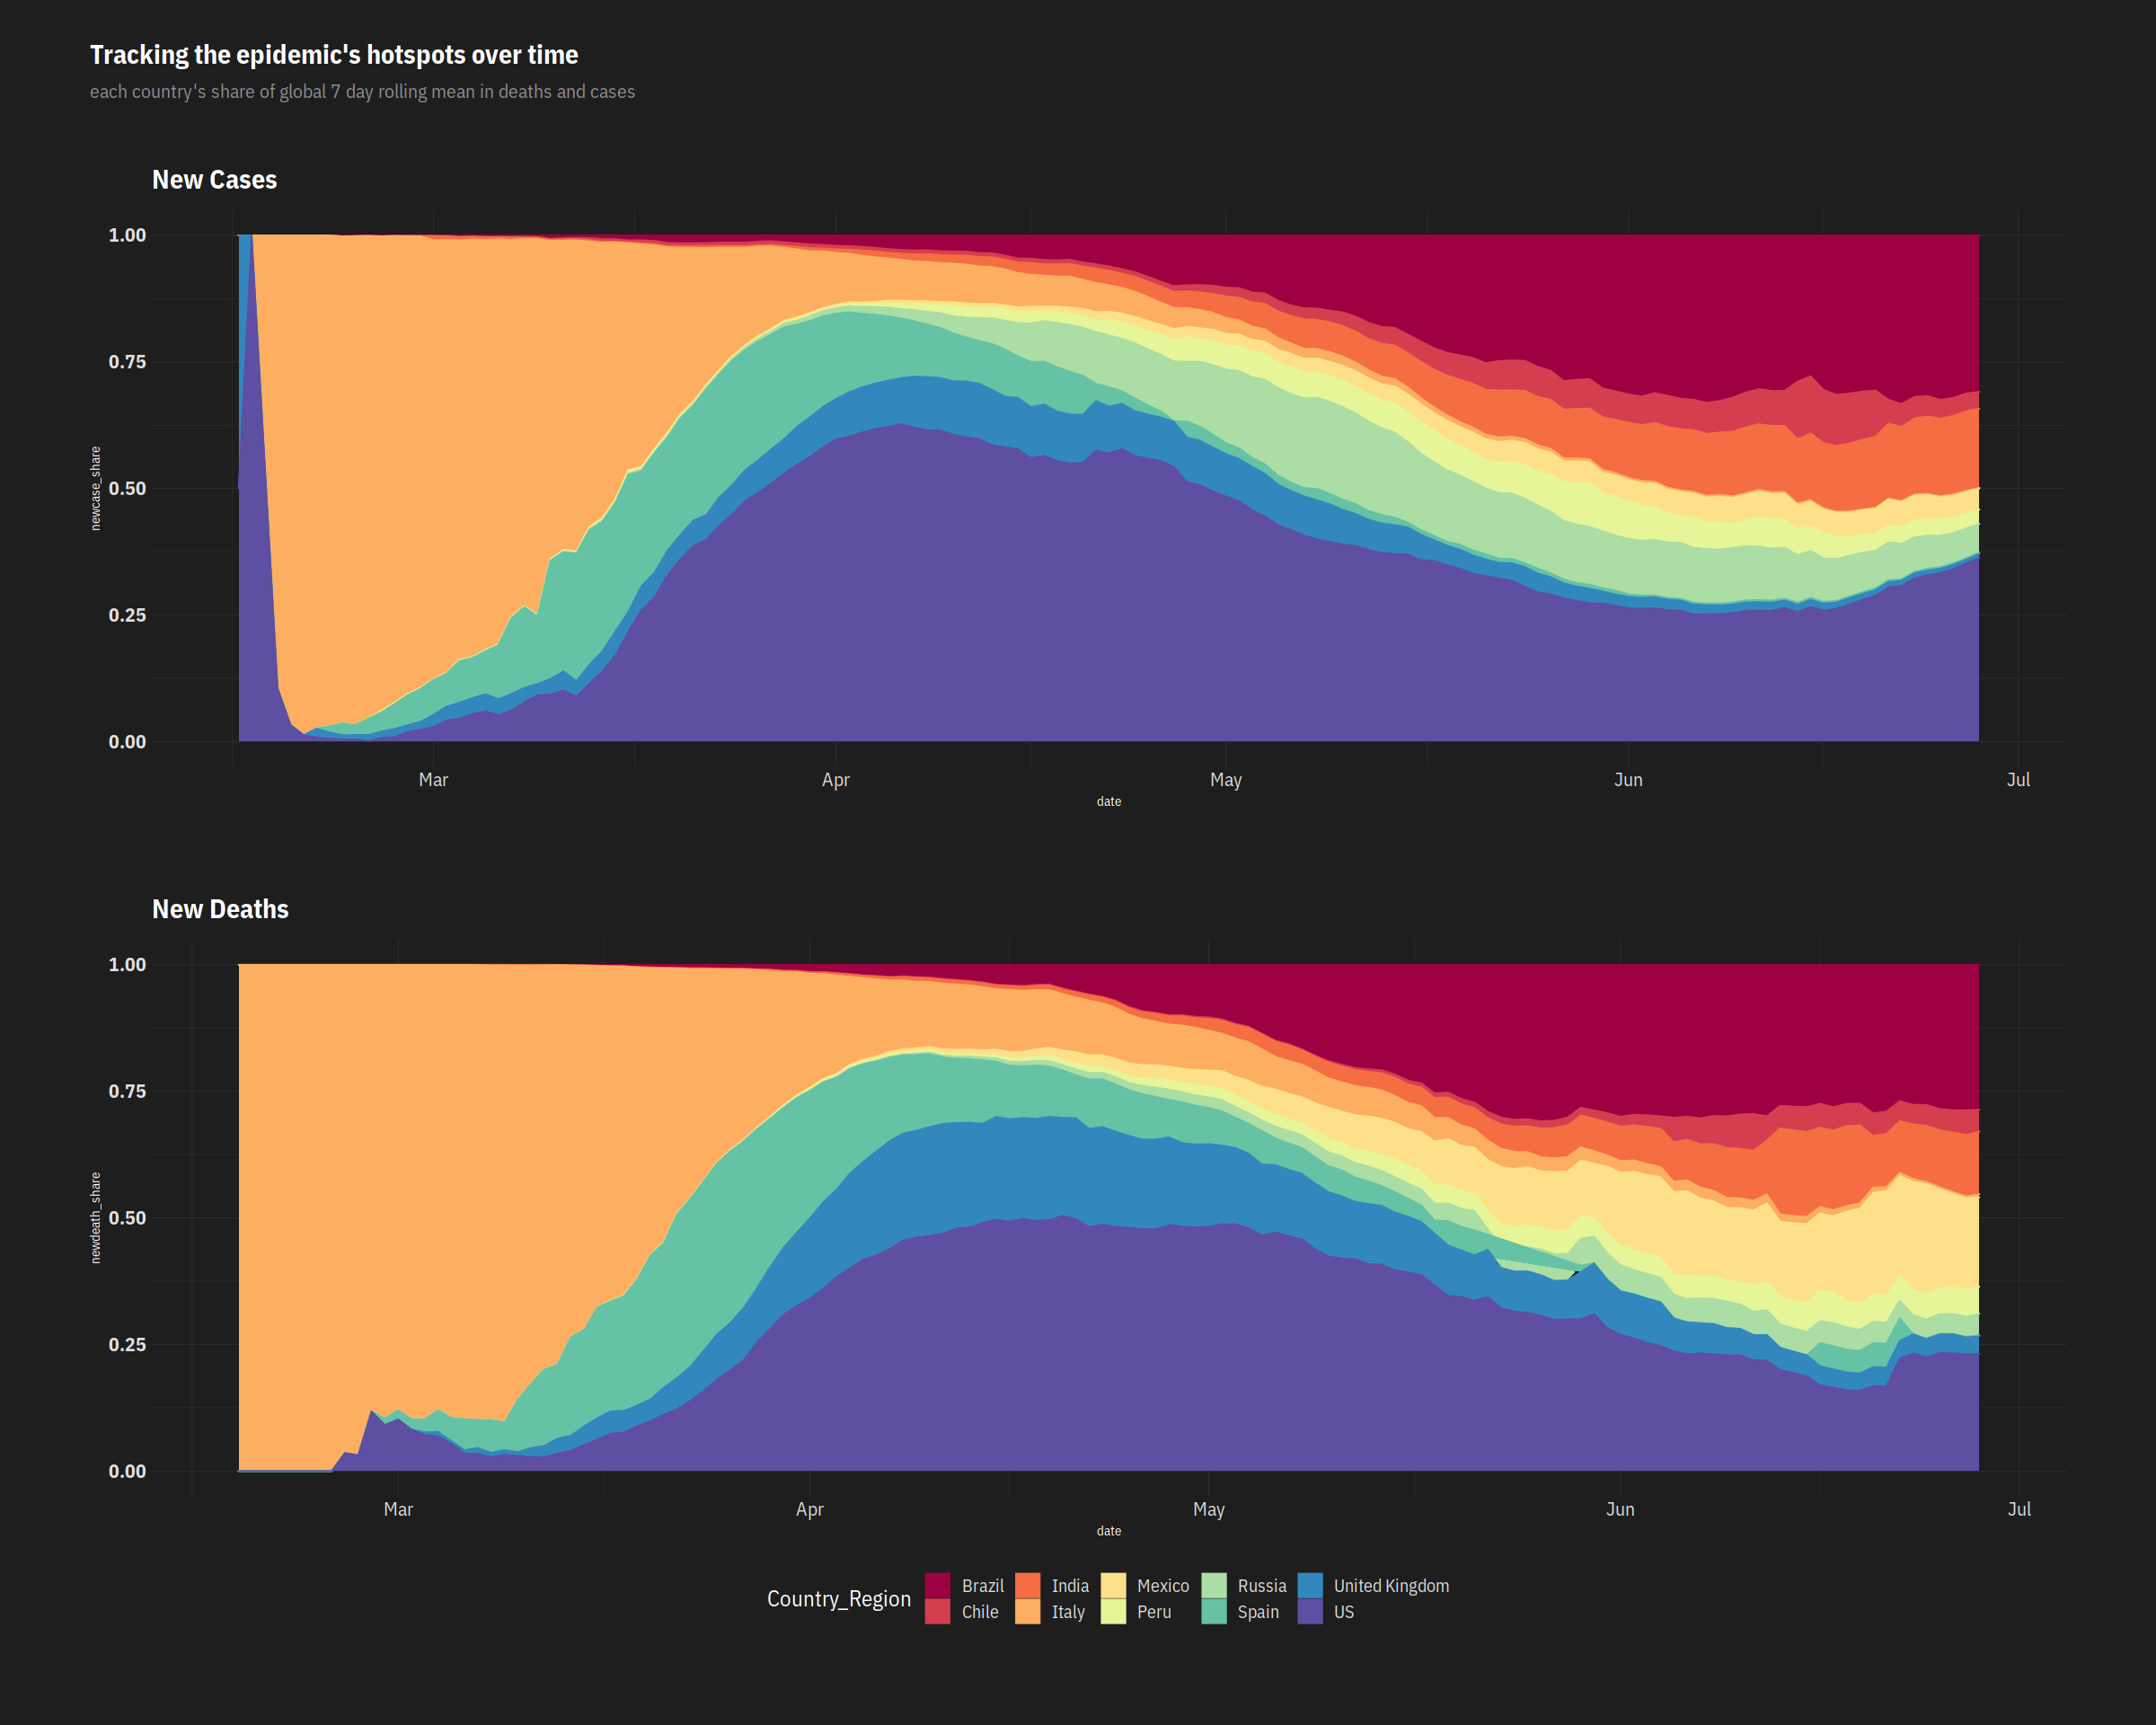

In [16]:
p1 = ggplot(t10_subset[date >="2020-02-15"], aes(x = date, y = newcase_share, fill = Country_Region, colour = Country_Region)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+ ylim(c(0, 1)) +
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Cases") + theme(legend.position = "None")
p2 = ggplot(t10_subset[date >="2020-02-15"], aes(x = date, y = newdeath_share, fill = Country_Region, colour = Country_Region)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+ ylim(c(0, 1)) +
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Deaths")

options(repr.plot.width = 20, repr.plot.height = 16)
(p = (p1 / p2 ) + plot_annotation(title = "Tracking the epidemic's hotspots over time", 
                                  subtitle = "each country's share of global 7 day rolling mean in deaths and cases"))

In [17]:
ggsave("carpet_plot_xc.png", p, width = 20, height = 16)

Warning message:
“Removed 40 rows containing missing values (position_stack).”
Warning message:
“Removed 67 rows containing missing values (position_stack).”


# OWID 

In [18]:
owid = fread("https://covid.ourworldindata.org/data/owid-covid-data.csv")
owid[, d := ymd(date)]
owid %>% glimpse

Rows: 27,600
Columns: 35
$ iso_code                        <chr> "AFG", "AFG", "AFG", "AFG", "AFG", "A…
$ continent                       <chr> "Asia", "Asia", "Asia", "Asia", "Asia…
$ location                        <chr> "Afghanistan", "Afghanistan", "Afghan…
$ date                            <chr> "2019-12-31", "2020-01-01", "2020-01-…
$ total_cases                     <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ new_cases                       <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ total_deaths                    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ new_deaths                      <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ total_cases_per_million         <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ new_cases_per_million           <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ total_deaths_per_million        <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ new_deaths_per_million          <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ total_tests              

In [19]:
fwrite(owid, "data/owid_covid.csv")

In [20]:
all_countries_xs = owid[location!="World"][
    order(-d)][
    , .SD[1], by = .(iso_code)]
(t10 = all_countries_xs[order(-total_cases)][1:10])
#  [order(-total_cases)][1:10])

iso_code continent     location       date       total_cases new_cases
1  USA      North America United States  2020-07-02 2686480     52048    
2  BRA      South America Brazil         2020-07-02 1448753     46712    
3  RUS      Europe        Russia         2020-07-02  654405      6556    
4  IND      Asia          India          2020-07-02  604641     19148    
5  GBR      Europe        United Kingdom 2020-07-02  313483       829    
6  PER      South America Peru           2020-07-02  288477      3264    
7  CHL      South America Chile          2020-07-02  282043      2650    
8  ESP      Europe        Spain          2020-07-01  249659       388    
9  ITA      Europe        Italy          2020-07-02  240760       182    
10 MEX      North America Mexico         2020-07-02  231770      5681    
   total_deaths new_deaths total_cases_per_million new_cases_per_million ⋯
1  128062        652        8116.2                 157.243               ⋯
2   60632       1038        6815.8                 219.760               ⋯
3    9536        216        4484.2                  44.924               ⋯
4   17834        434         438.1                  13.875               ⋯
5   43906        176        4617.8                  12.212               ⋯
6    9860        183        8749.2                  98.994               ⋯
7    5753         65       14754.1                 138.626               ⋯
8   28363          8        5339.8                   8.299               ⋯
9   34788         21        3982.0                   3.010               ⋯
10  28510        741        1797.6                  44.062               ⋯
   gdp_per_capita extreme_poverty cvd_death_rate diabetes_prevalence
1  54225           1.2            151.09         10.79              
2  14103           3.4            177.96          8.11              
3  24766           0.1            431.30          6.18              
4   6427          21.2            282.28         10.39              
5  39753           0.2            122.14          4.28              
6  12237           3.5             85.75          5.95              
7  22767           1.3            127.99          8.46              
8  34272           1.0             99.40          7.17              
9  35220           2.0            113.15          4.78              
10 17336           2.5            152.78         13.06              
   female_smokers male_smokers handwashing_facilities
1  19.1           24.6            NA                 
2  10.1           17.9            NA                 
3  23.4           58.3            NA                 
4   1.9           20.6         59.55                 
5  20.0           24.7            NA                 
6   4.8             NA            NA                 
7  34.2           41.5            NA                 
8  27.4           31.4            NA                 
9  19.8           27.8            NA                 
10  6.9           21.4         87.85                 
   hospital_beds_per_thousand life_expectancy d         
1  2.77                       78.86           2020-07-02
2  2.20                       75.88           2020-07-02
3  8.05                       72.58           2020-07-02
4  0.53                       69.66           2020-07-02
5  2.54                       81.32           2020-07-02
6  1.60                       76.74           2020-07-02
7  2.11                       80.18           2020-07-02
8  2.97                       83.56           2020-07-01
9  3.18                       83.51           2020-07-02
10 1.38                       75.05           2020-07-02

In [21]:
owid_t10_subset = owid[location %in% t10$location]

vars = c('new_cases', 'new_deaths', 'new_tests')
owid_t10_subset[, paste0('denom_', vars):= lapply(.SD, sum), by = date, .SDcols = vars]

owid_t10_subset[, `:=`(
            newcase_share  = new_cases / denom_new_cases,
            newdeath_share = new_deaths / denom_new_deaths,
            newtest_share  = new_tests / denom_new_tests
    )][ newcase_share < 0, newcase_share := 0]

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Warning message:
“Removed 125 rows containing missing values (position_stack).”
Warning message:
“Removed 154 rows containing missing values (position_stack).”


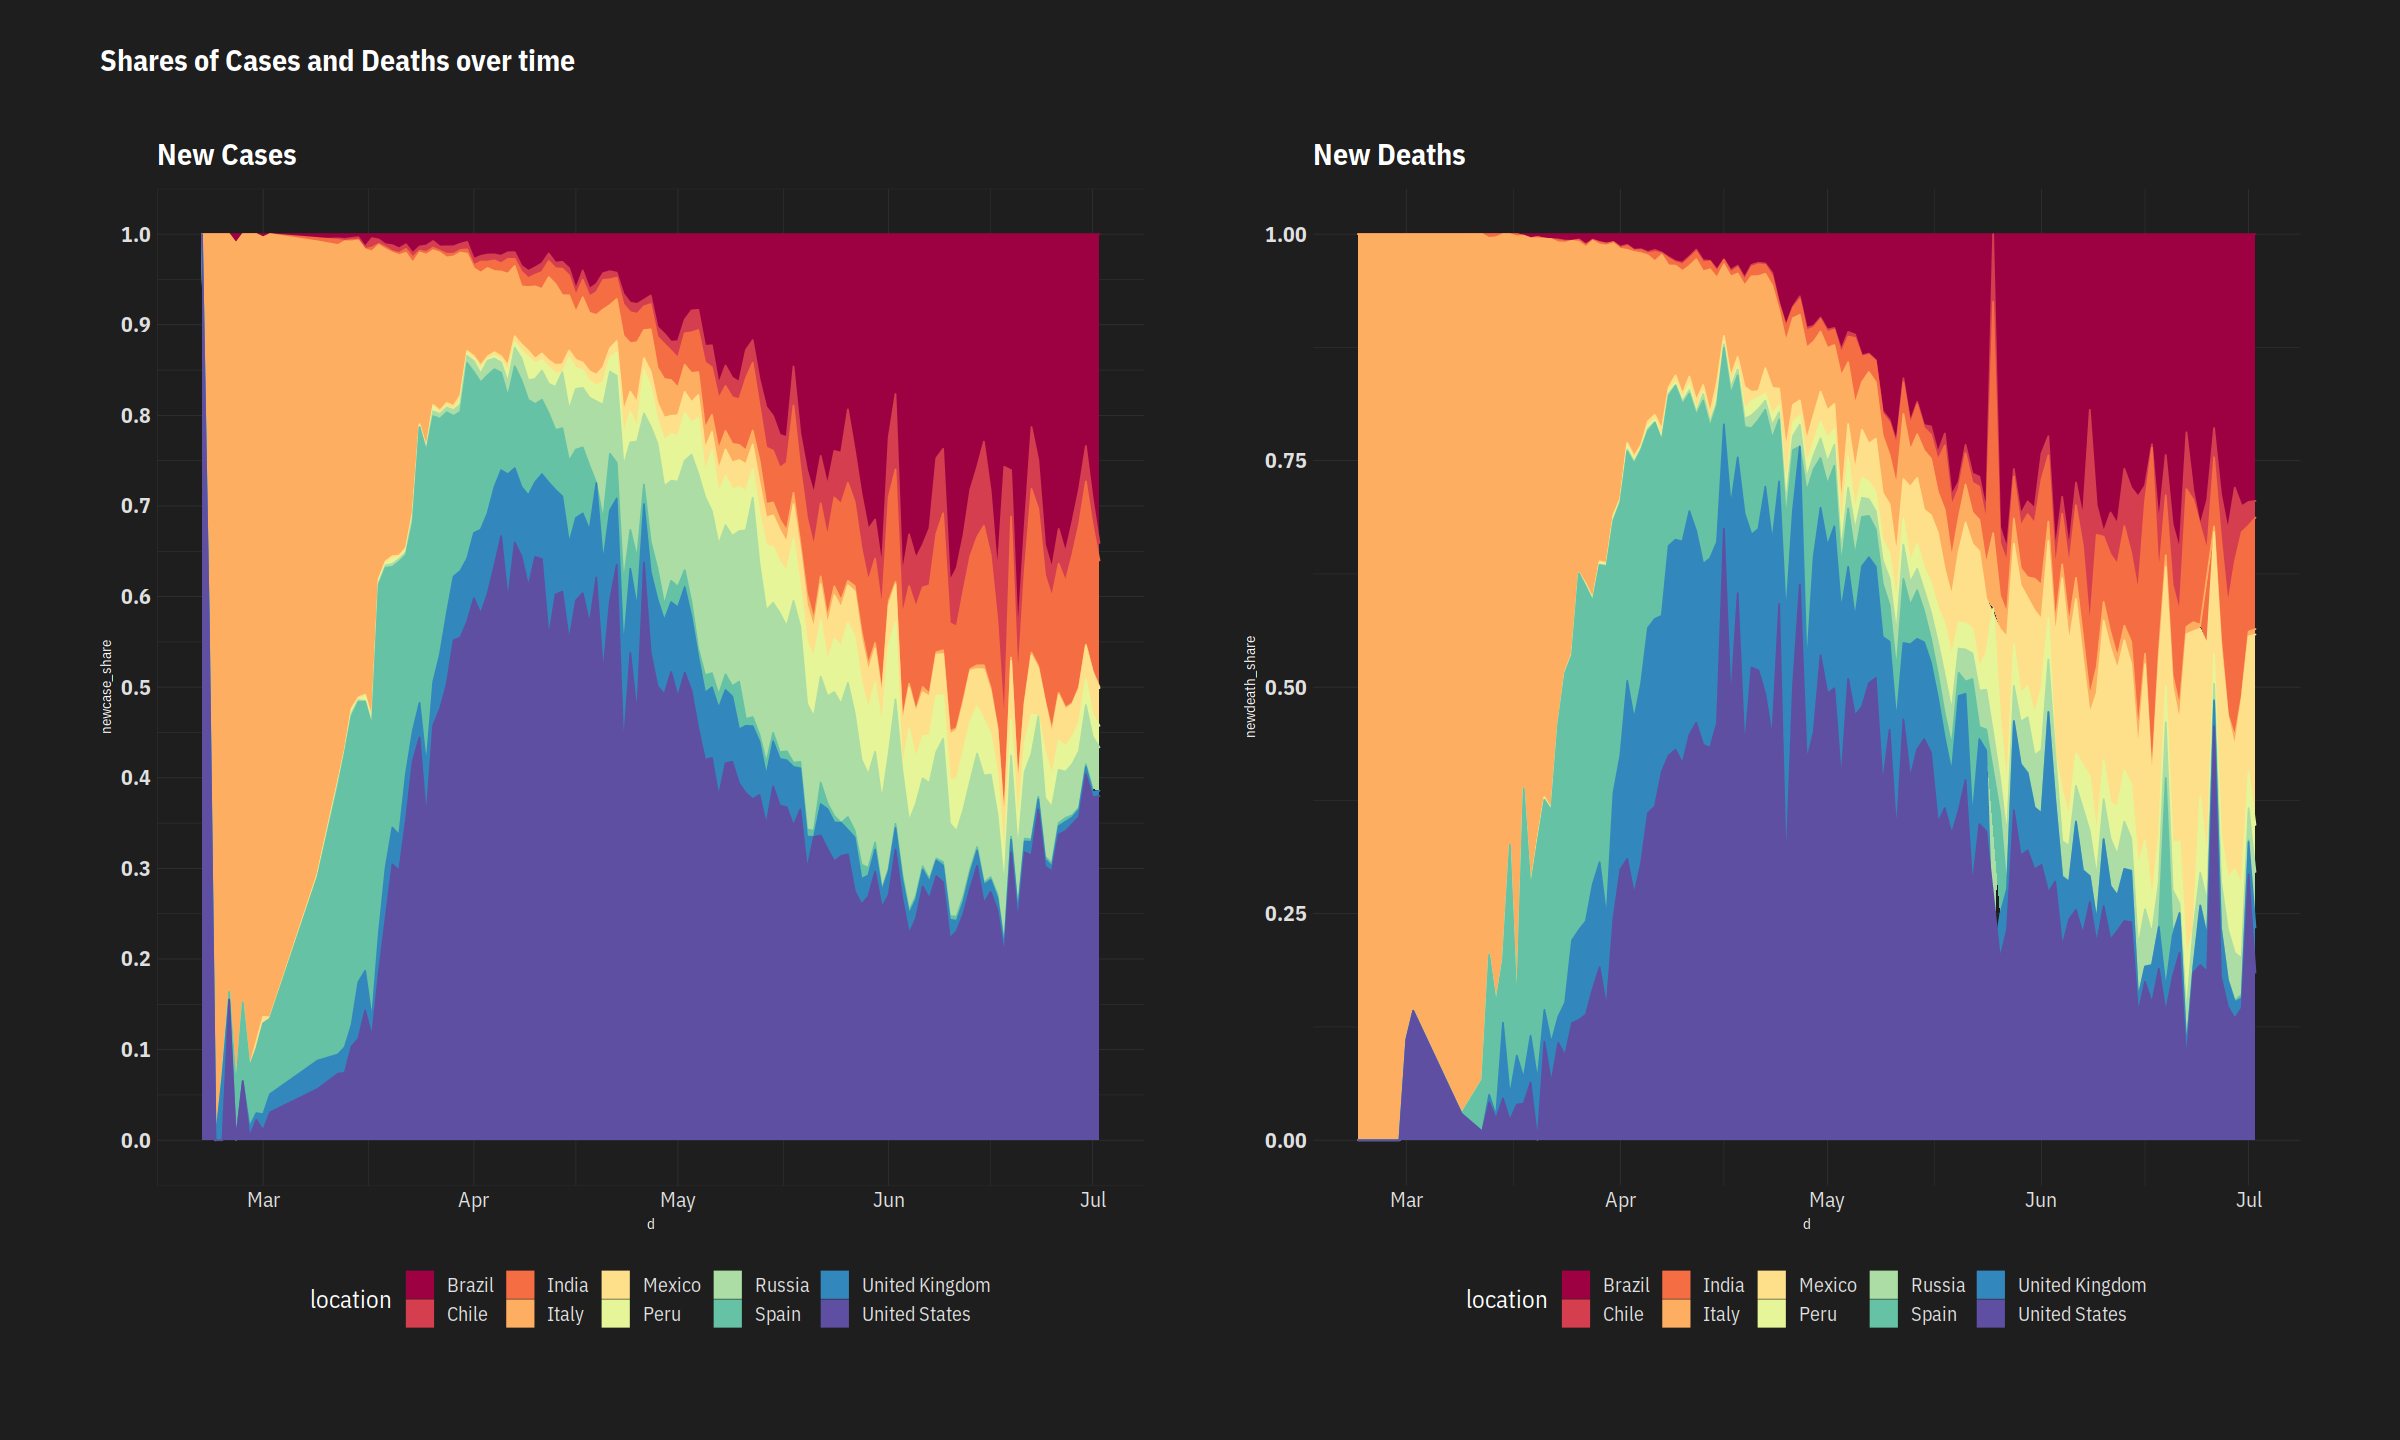

In [22]:
p1 = ggplot(owid_t10_subset[d >="2020-02-15"], aes(x = d, y = newcase_share, fill = location, colour = location)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") +
    ggtitle("New Cases")
p2 = ggplot(owid_t10_subset[d >="2020-02-15"], aes(x = d, y = newdeath_share, fill = location, colour = location)) +
    geom_area(position="fill") +
    scale_y_continuous(breaks = seq(0, 1, .1))+
    scale_fill_brewer(palette = "Spectral") +
    scale_colour_brewer(palette = "Spectral") + ylim(c(0, 1)) +
    ggtitle("New Deaths")
options(repr.plot.width = 20, repr.plot.height = 12)
(p1 | p2 ) + plot_annotation(title = "Shares of Cases and Deaths over time")

## Country Profiles 

In [23]:
country_plot = function(country){
    npl = owid[location == country][order(-date)]
    p1 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = total_cases)) + scale_y_log10() + 
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('Total Cases') 
    
    p2 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = new_cases)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('New Cases')
    
    p3 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = total_deaths)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('Total Deaths')
    
    p4 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = new_deaths)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('New Deaths')

    p5 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = total_tests)) + scale_y_log10() + 
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('Total Tests')

    p6 =  npl[d>="2020-03-15"] %>% 
        ggplot(aes(x = d, y = new_tests)) +
        geom_point(size = 0.5) +  geom_smooth(se = F) +
        ggtitle('New Tests')
    suppressMessages(suppressWarnings(print(
        (p5 | p6) / (p1 | p2) / (p3 | p4) + plot_annotation(title = paste0("Covid Profile : ", country))
    )))
}


## South Asia

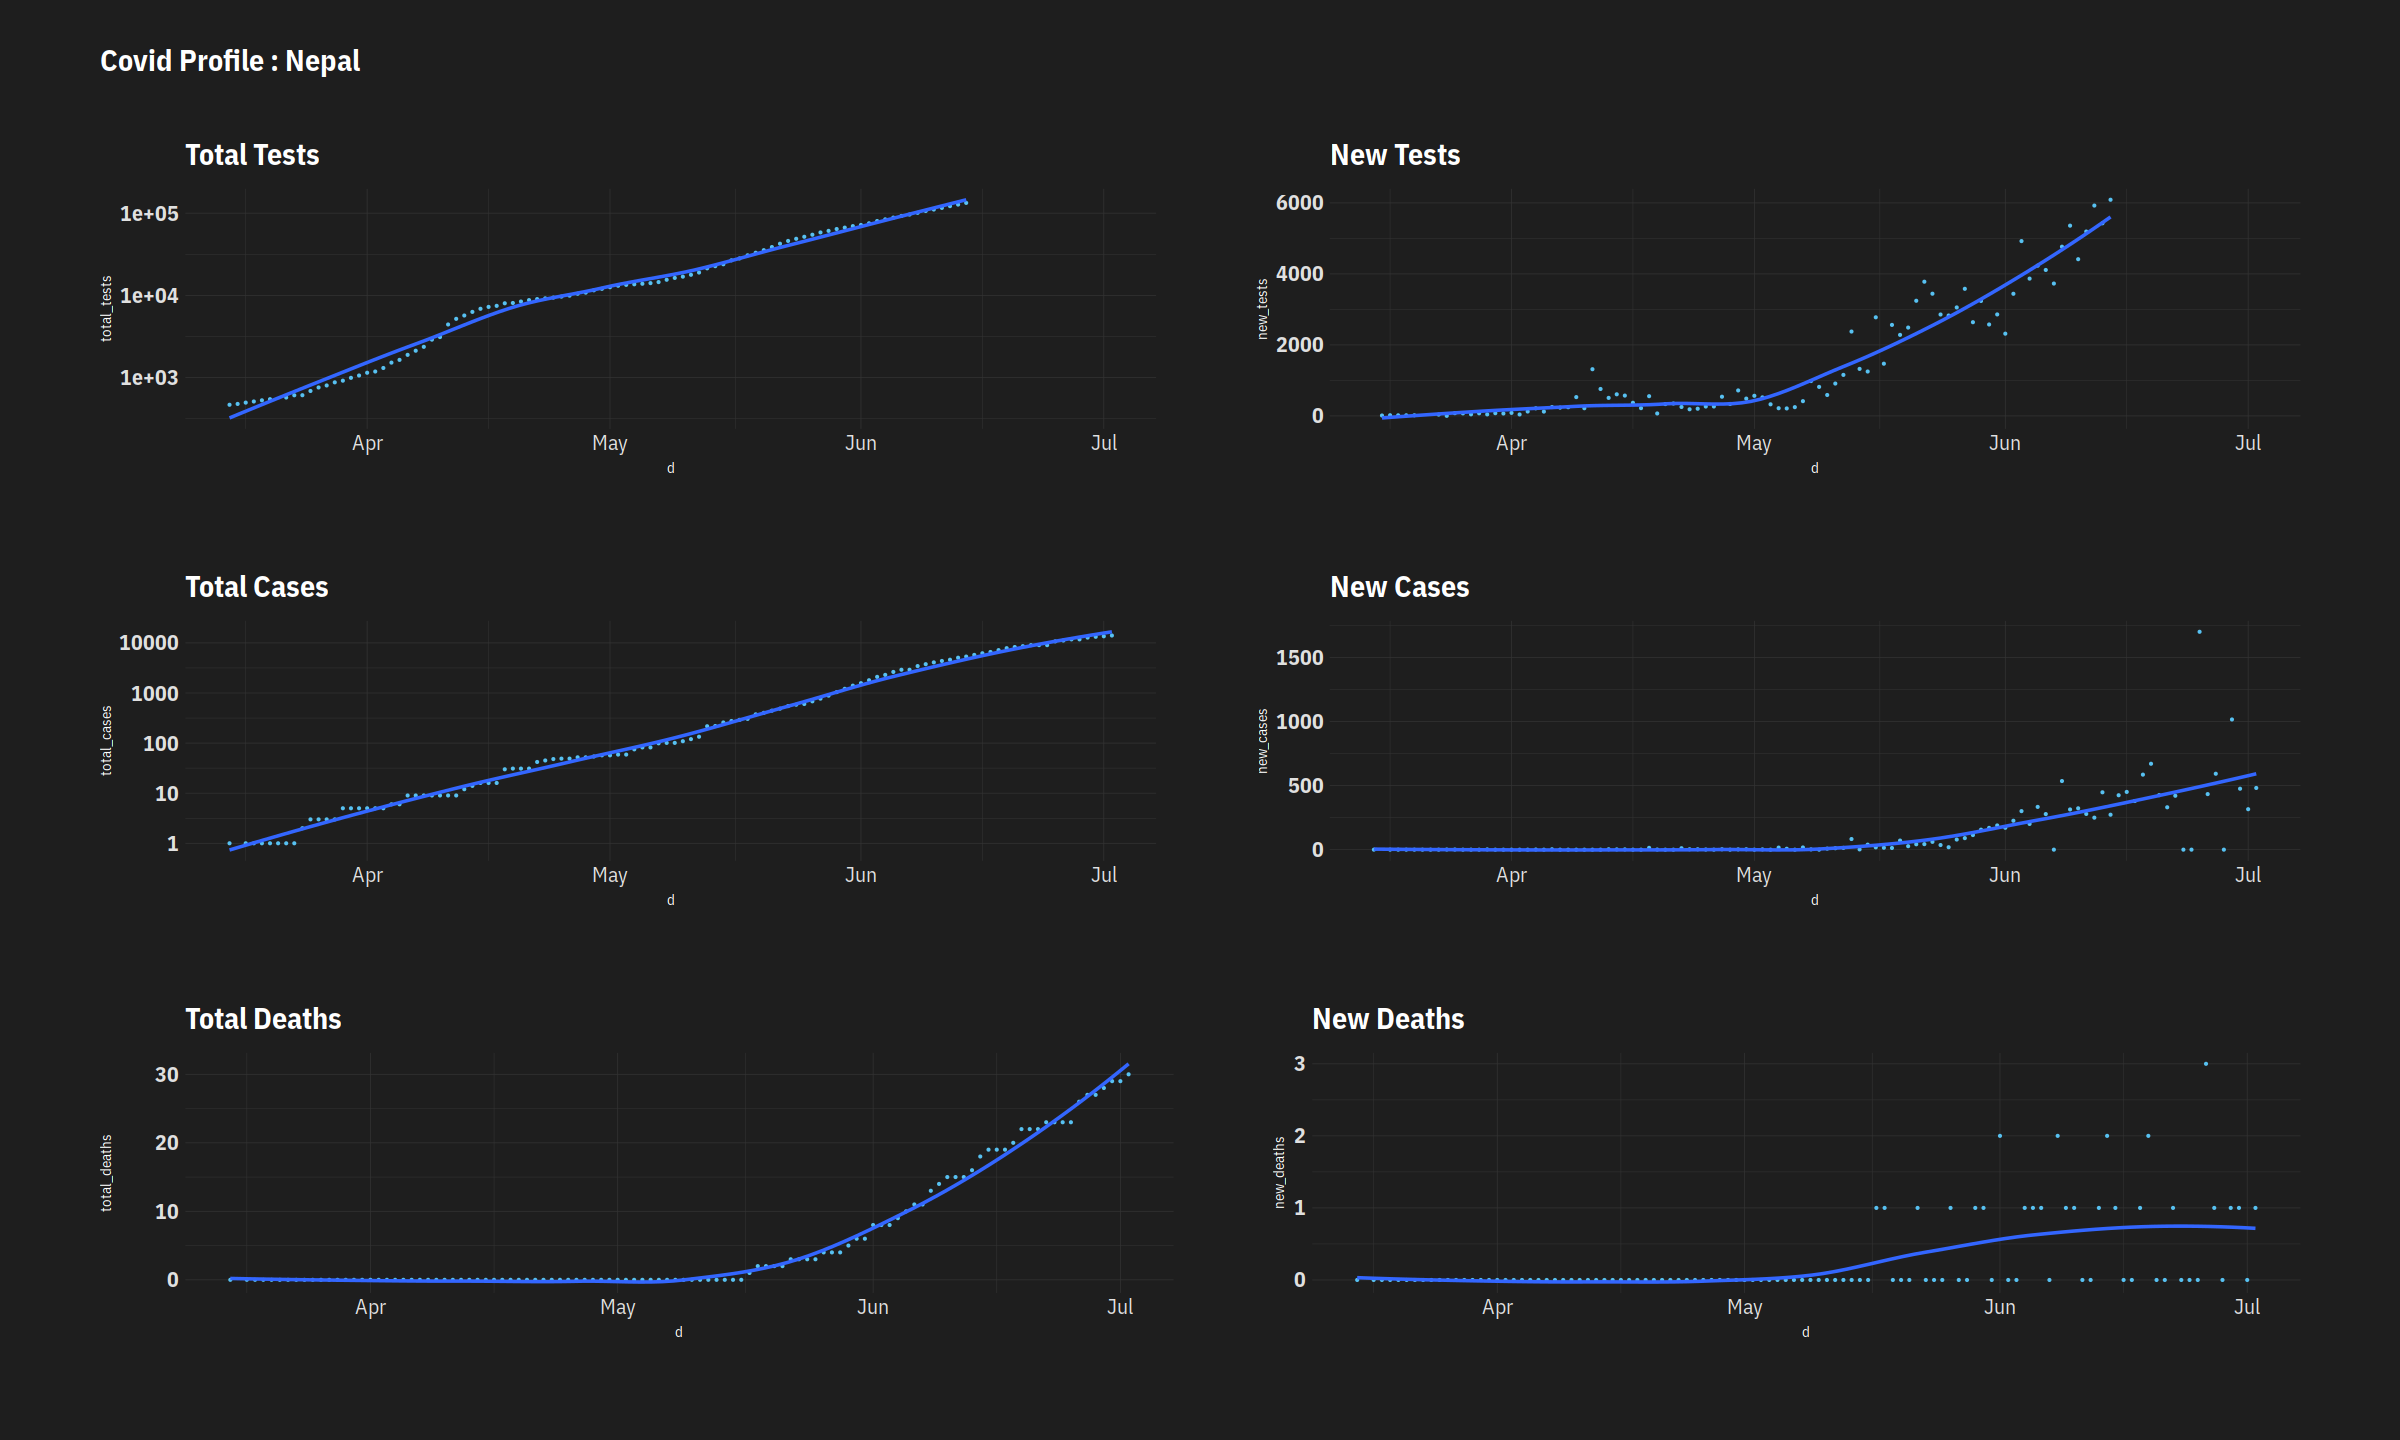

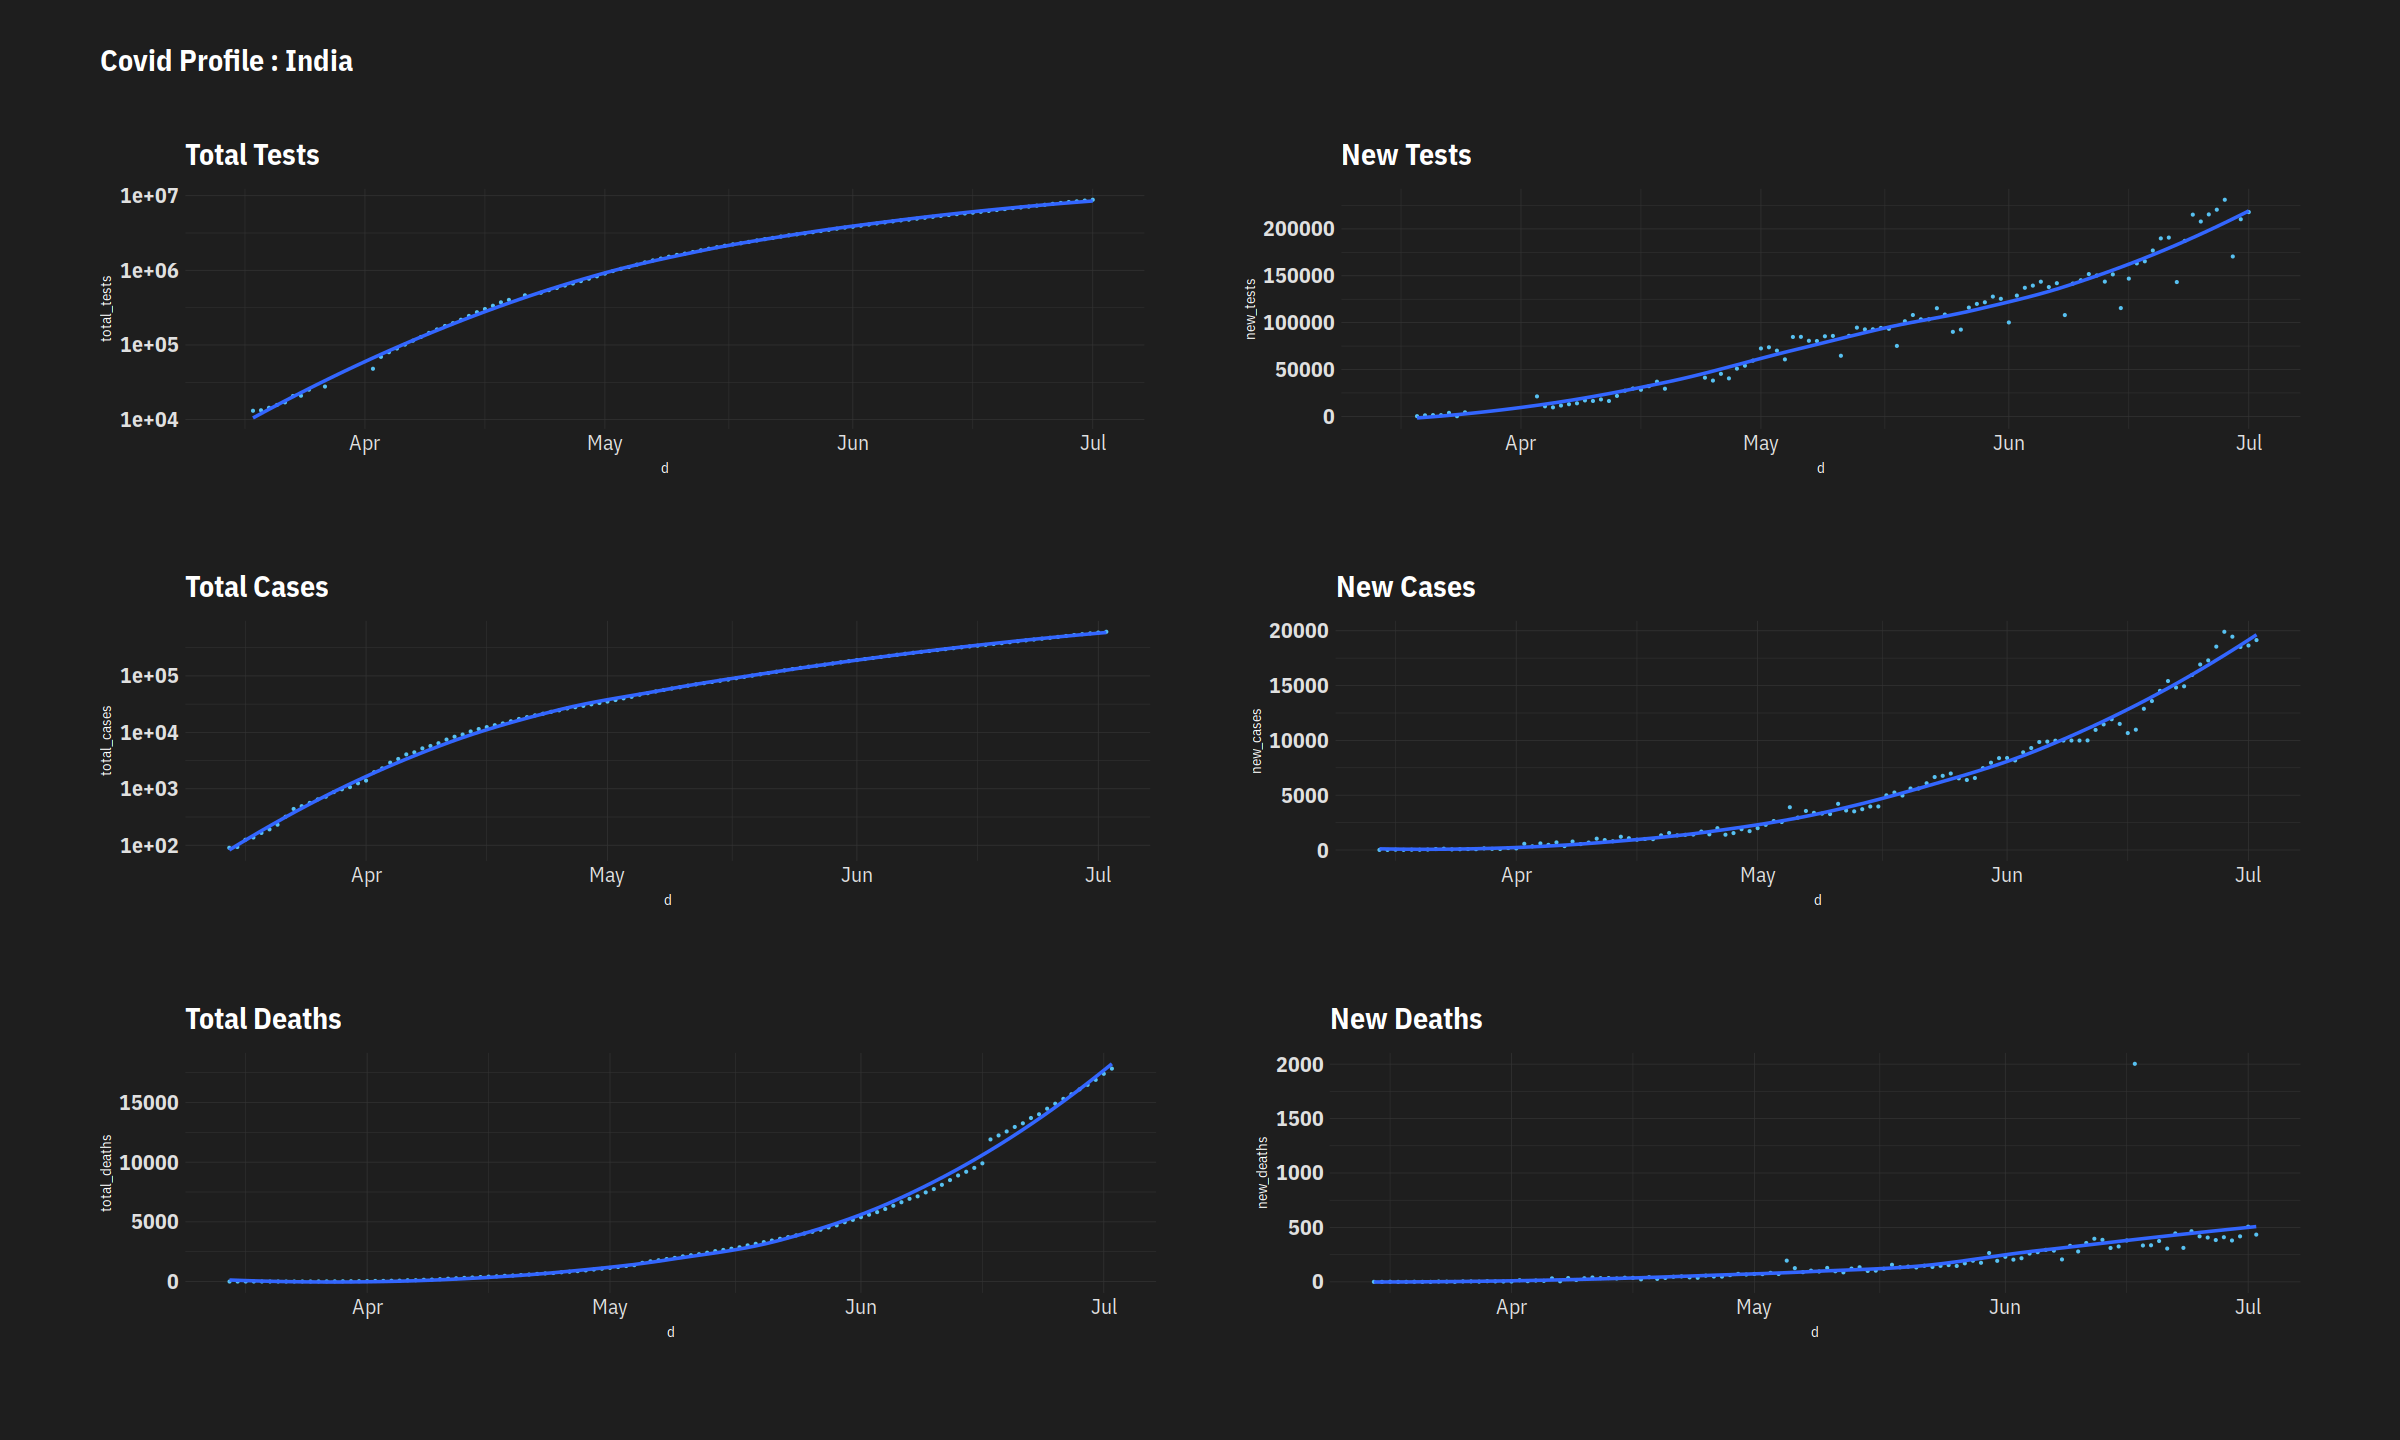

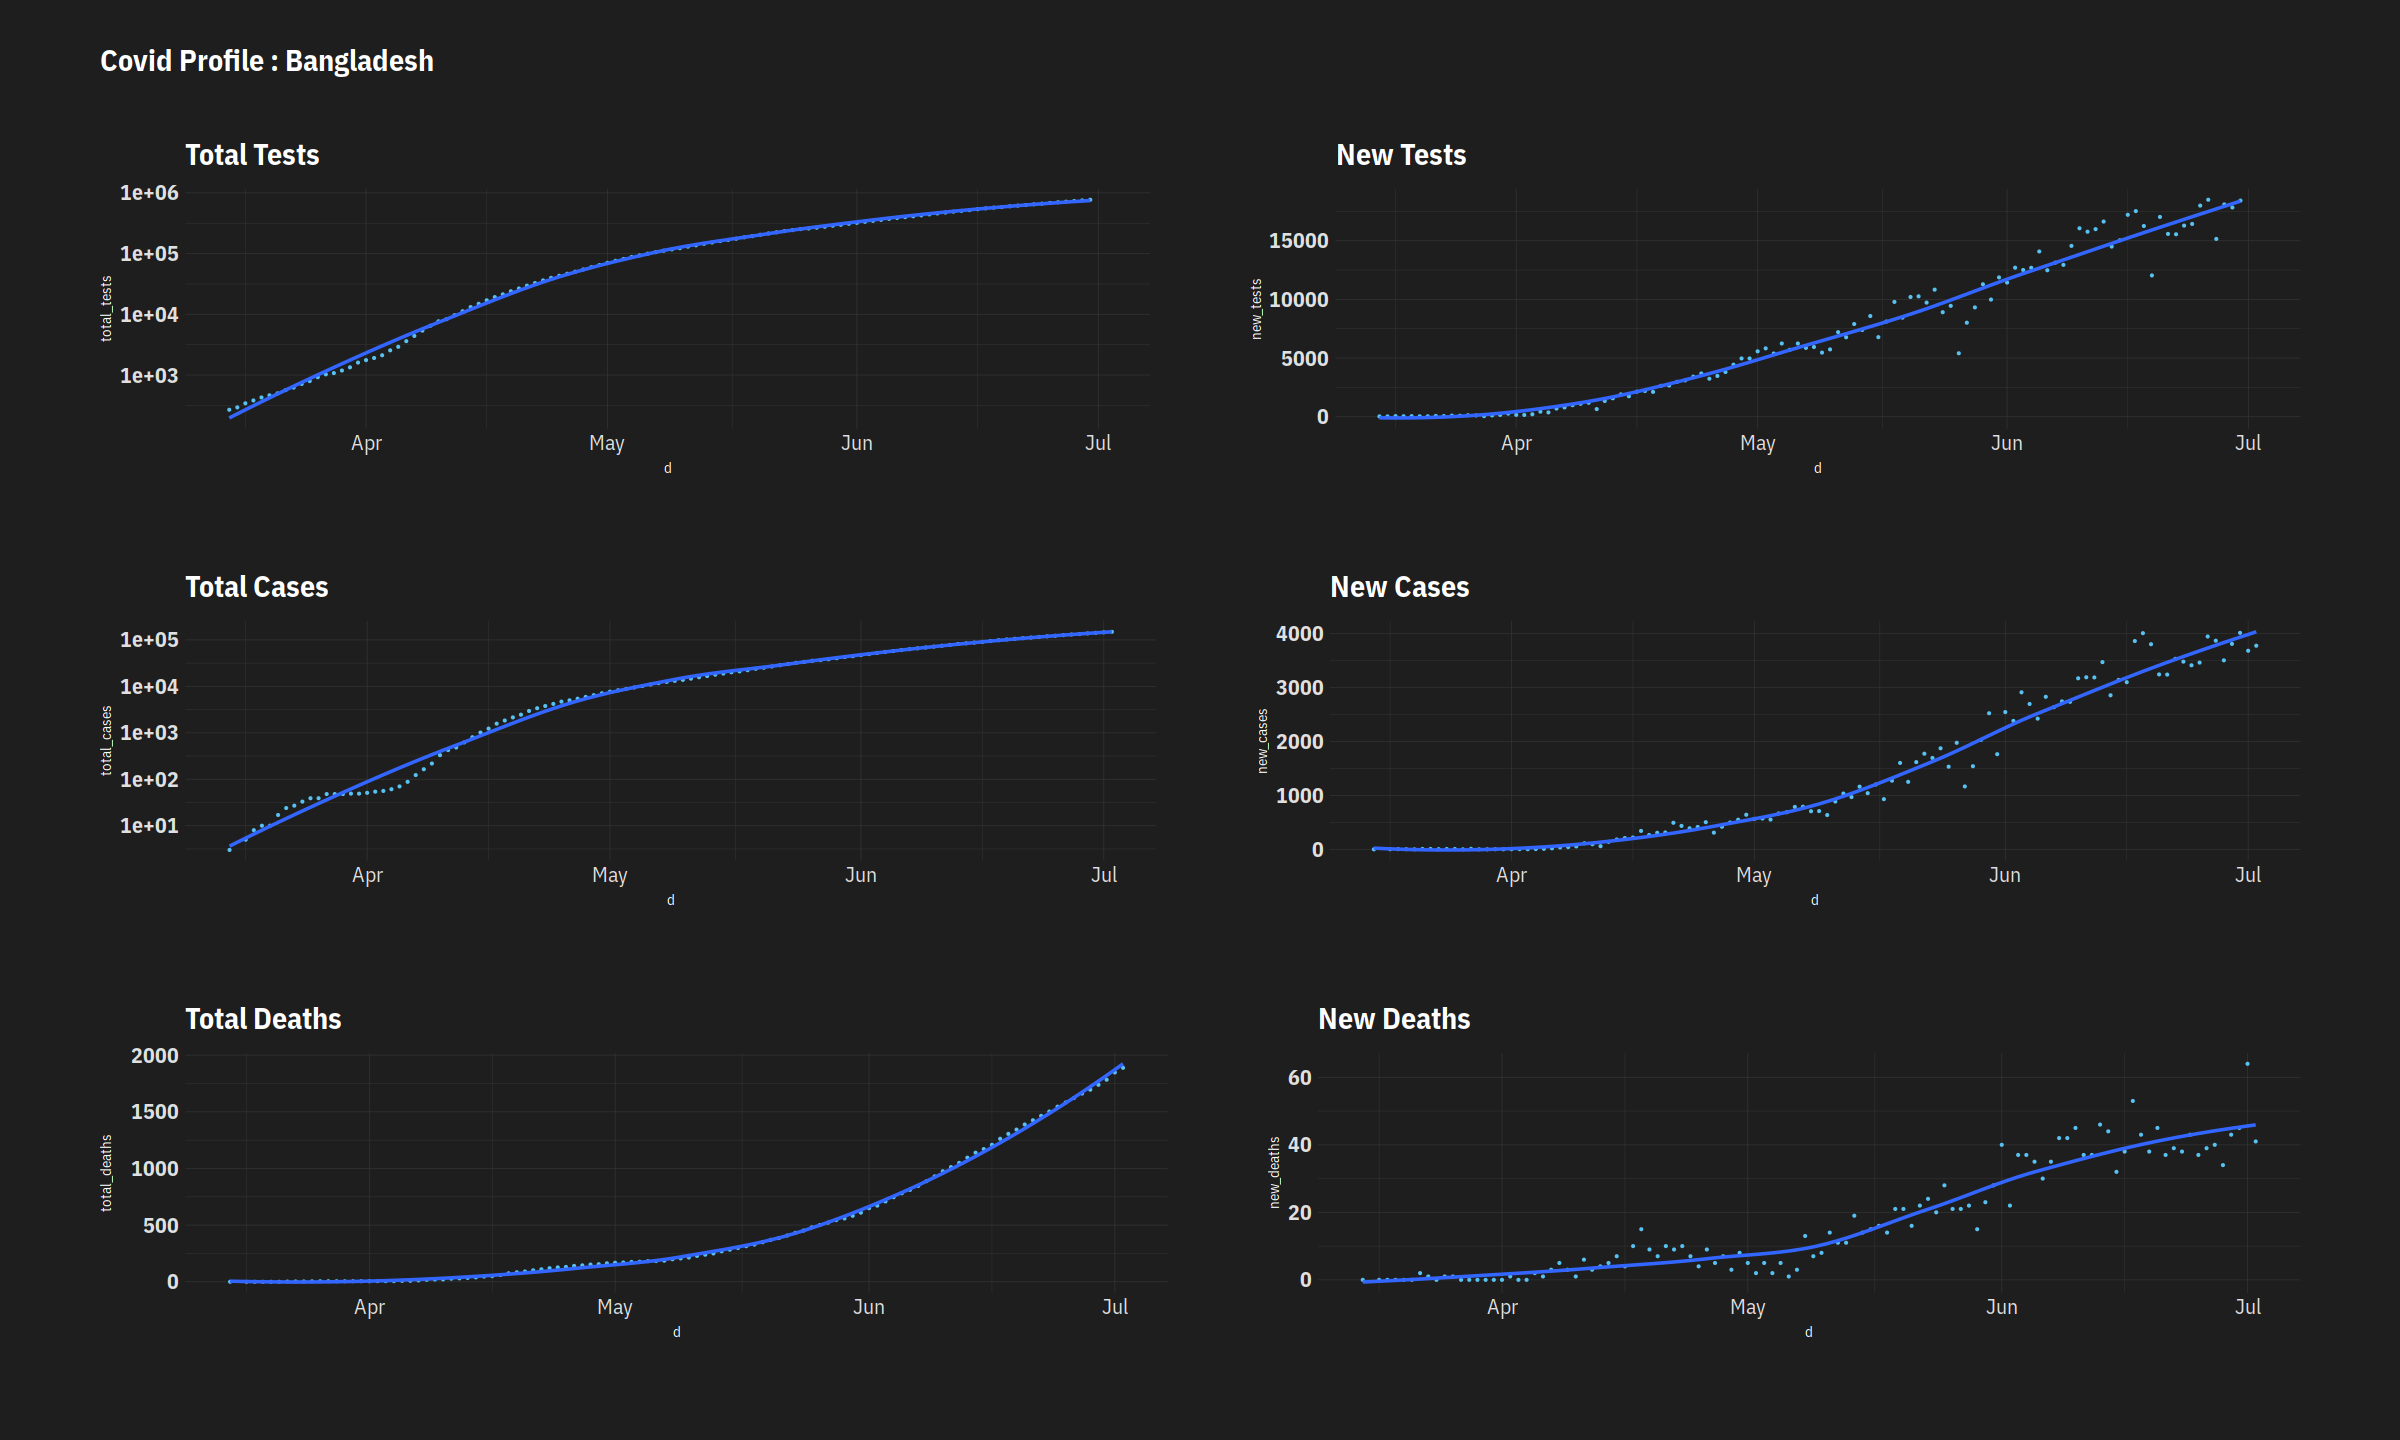

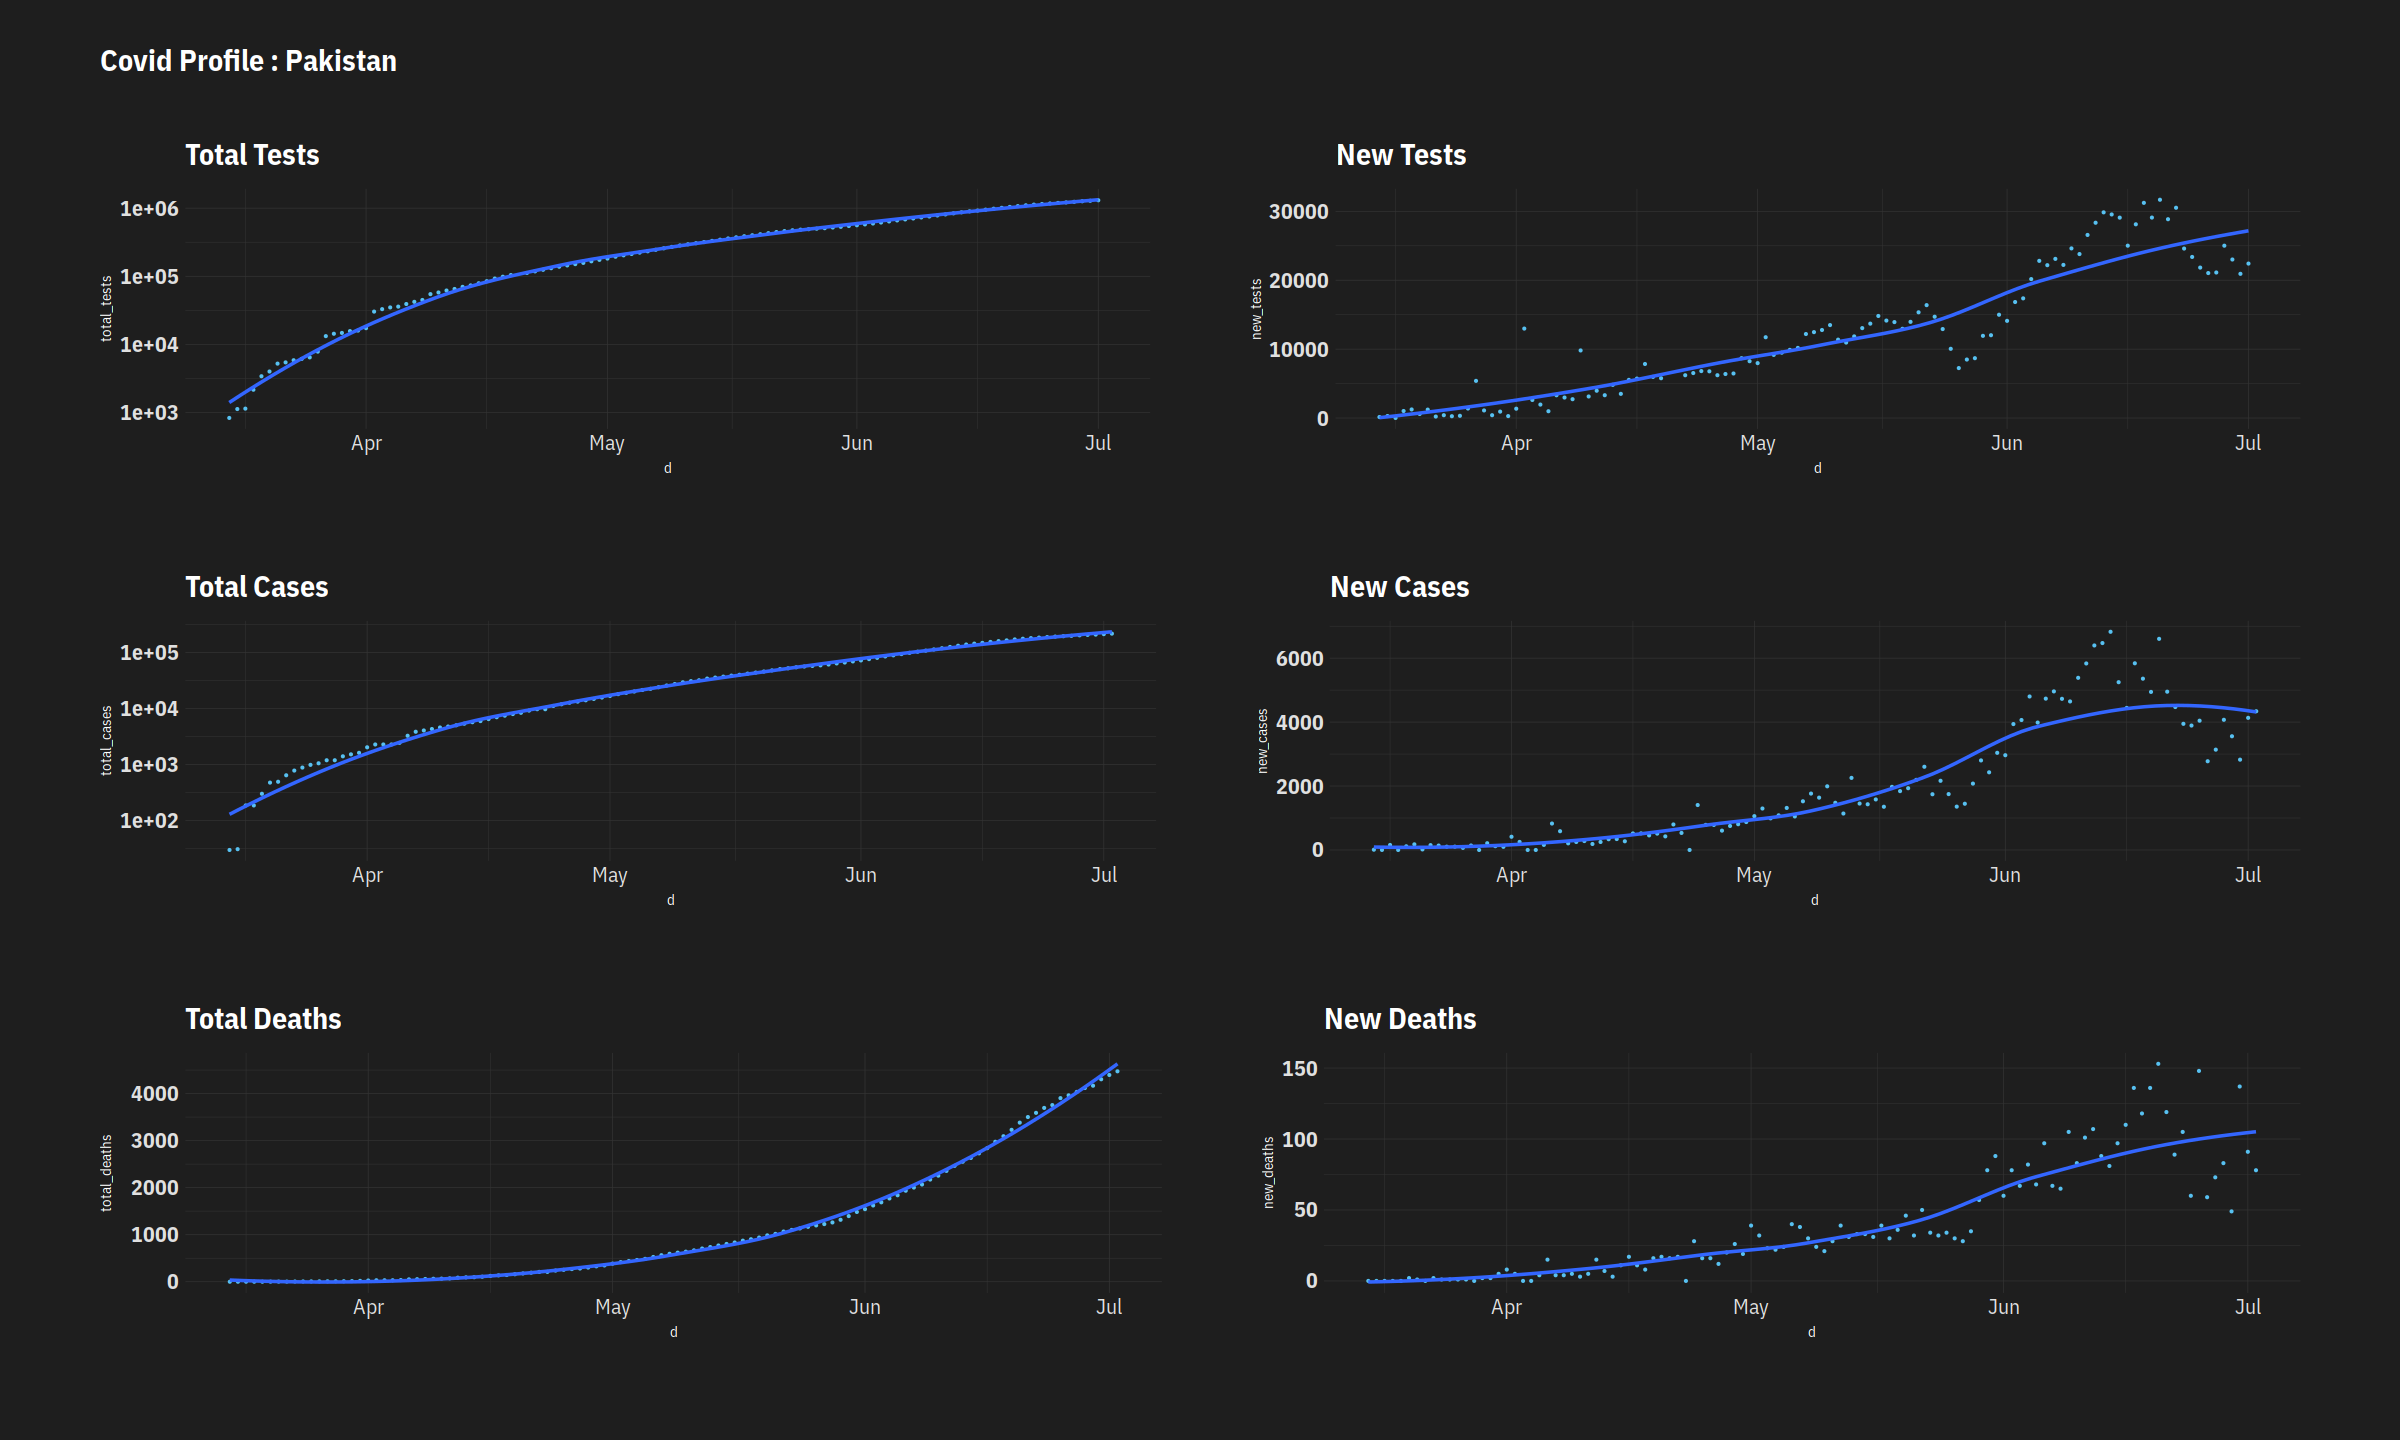

In [24]:
country_plot("Nepal") 
country_plot("India")
country_plot("Bangladesh")
country_plot("Pakistan")

## Sub-Saharan Africa

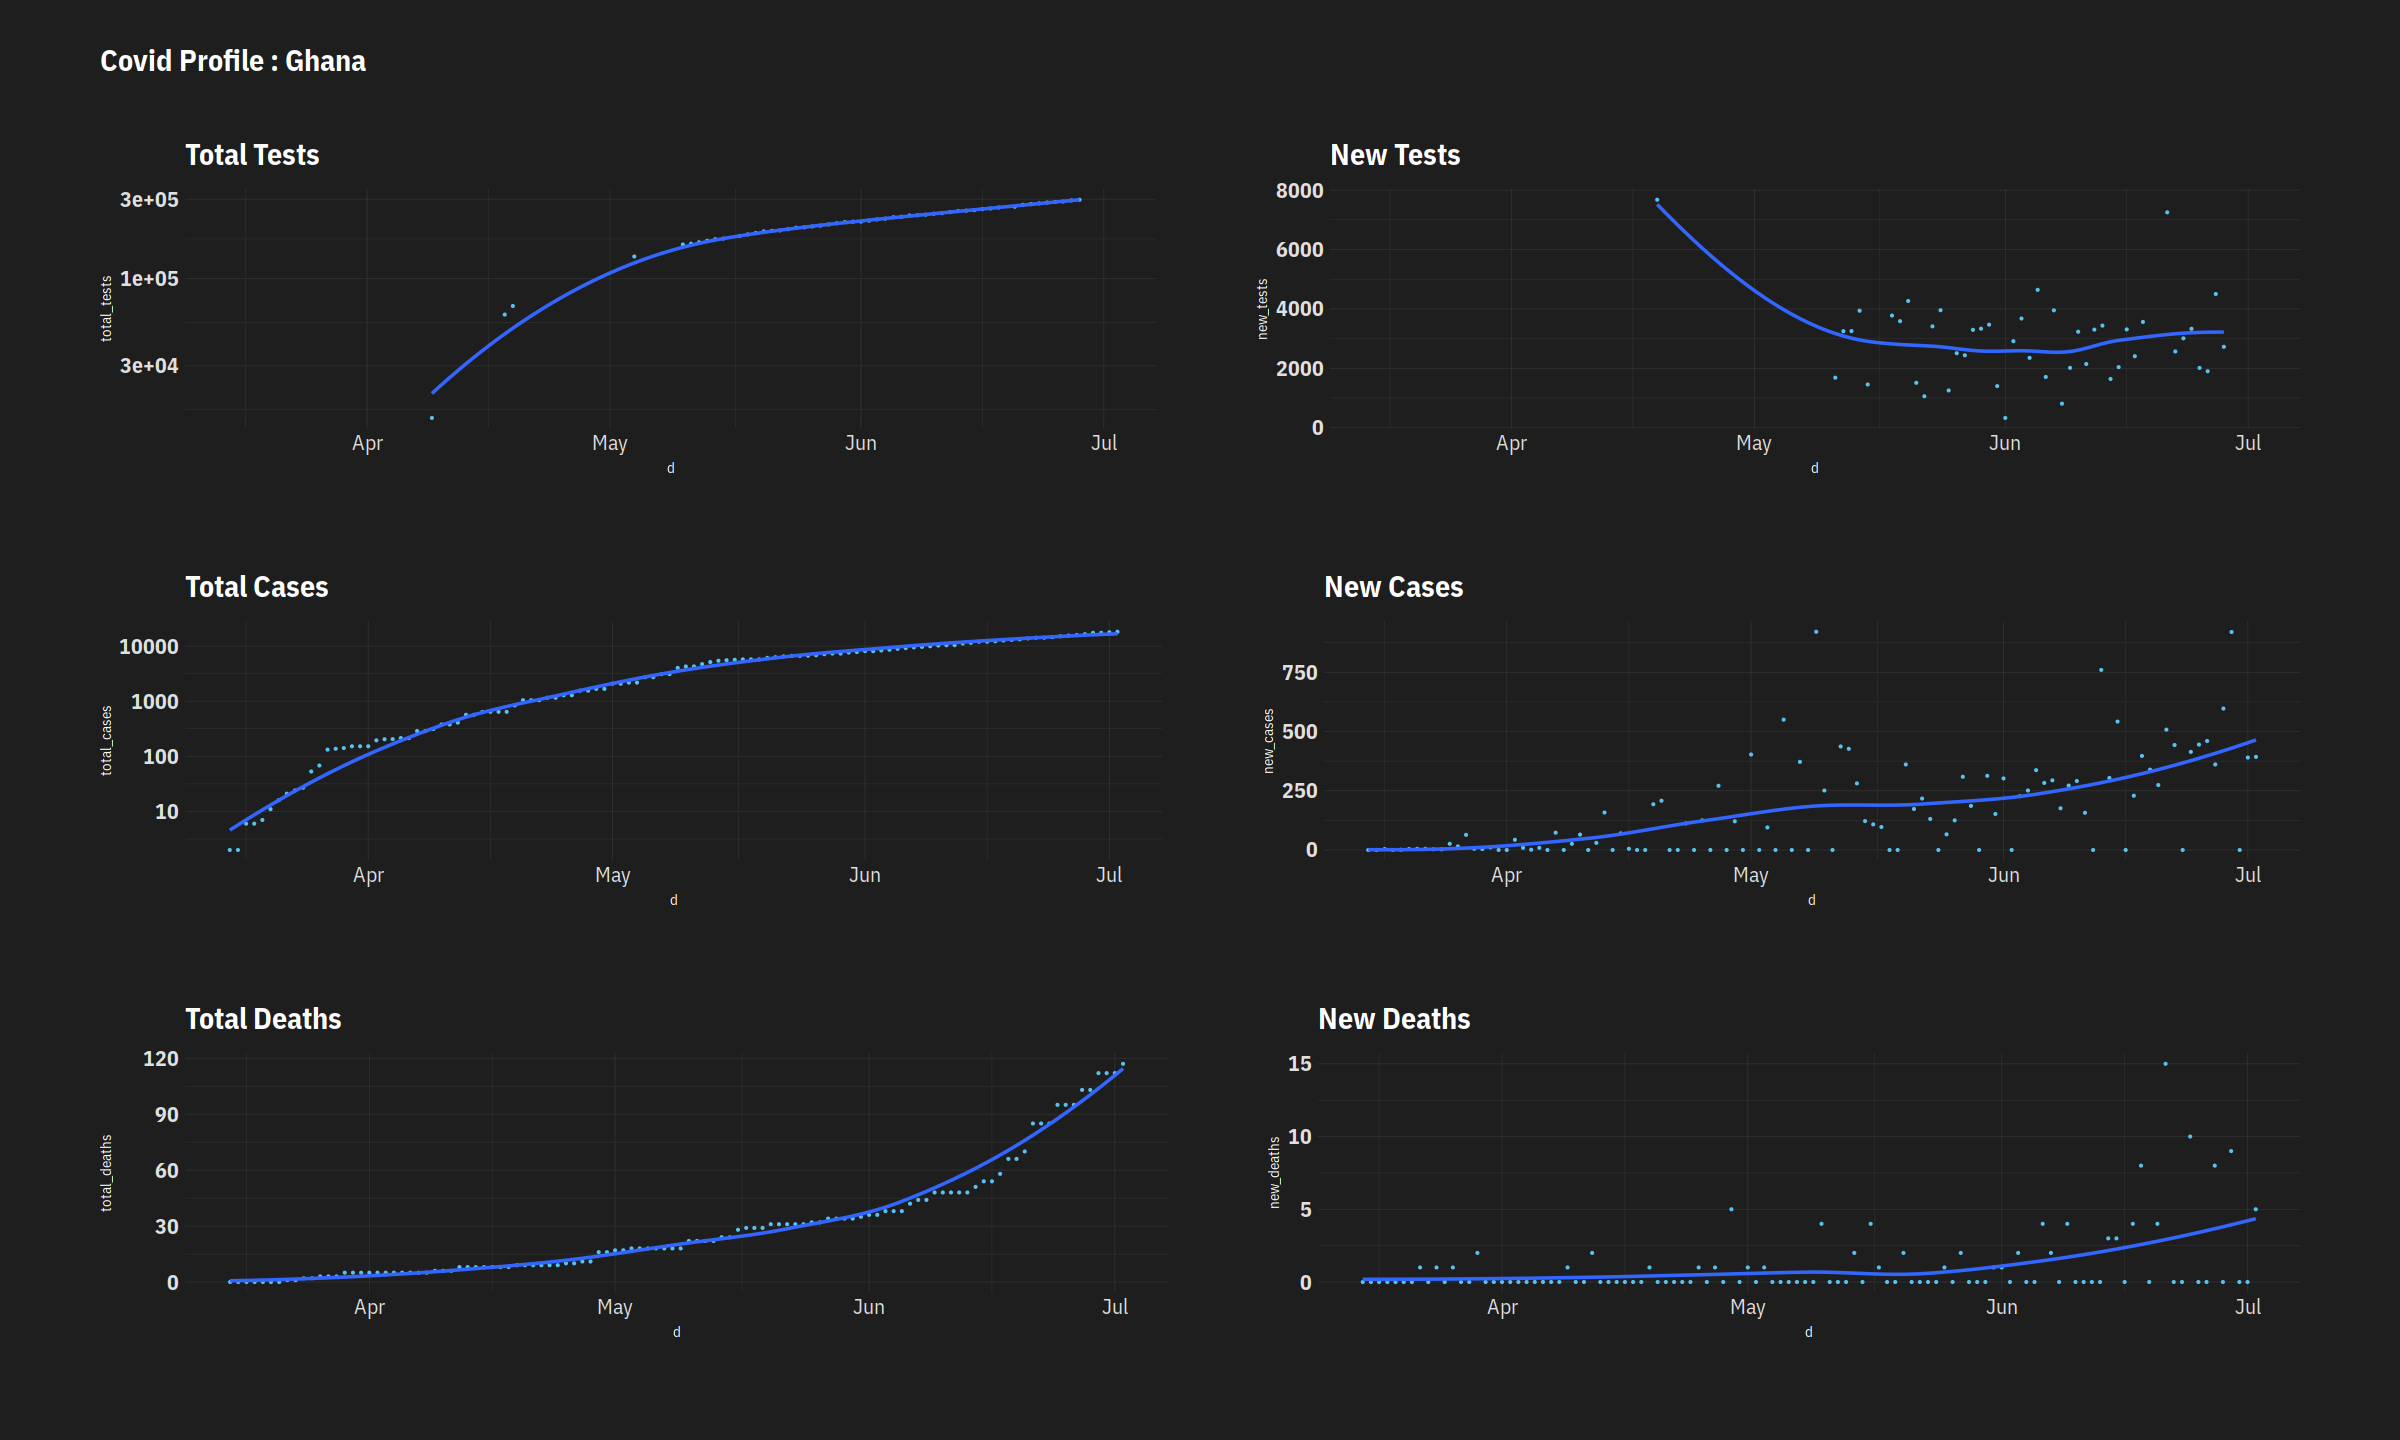

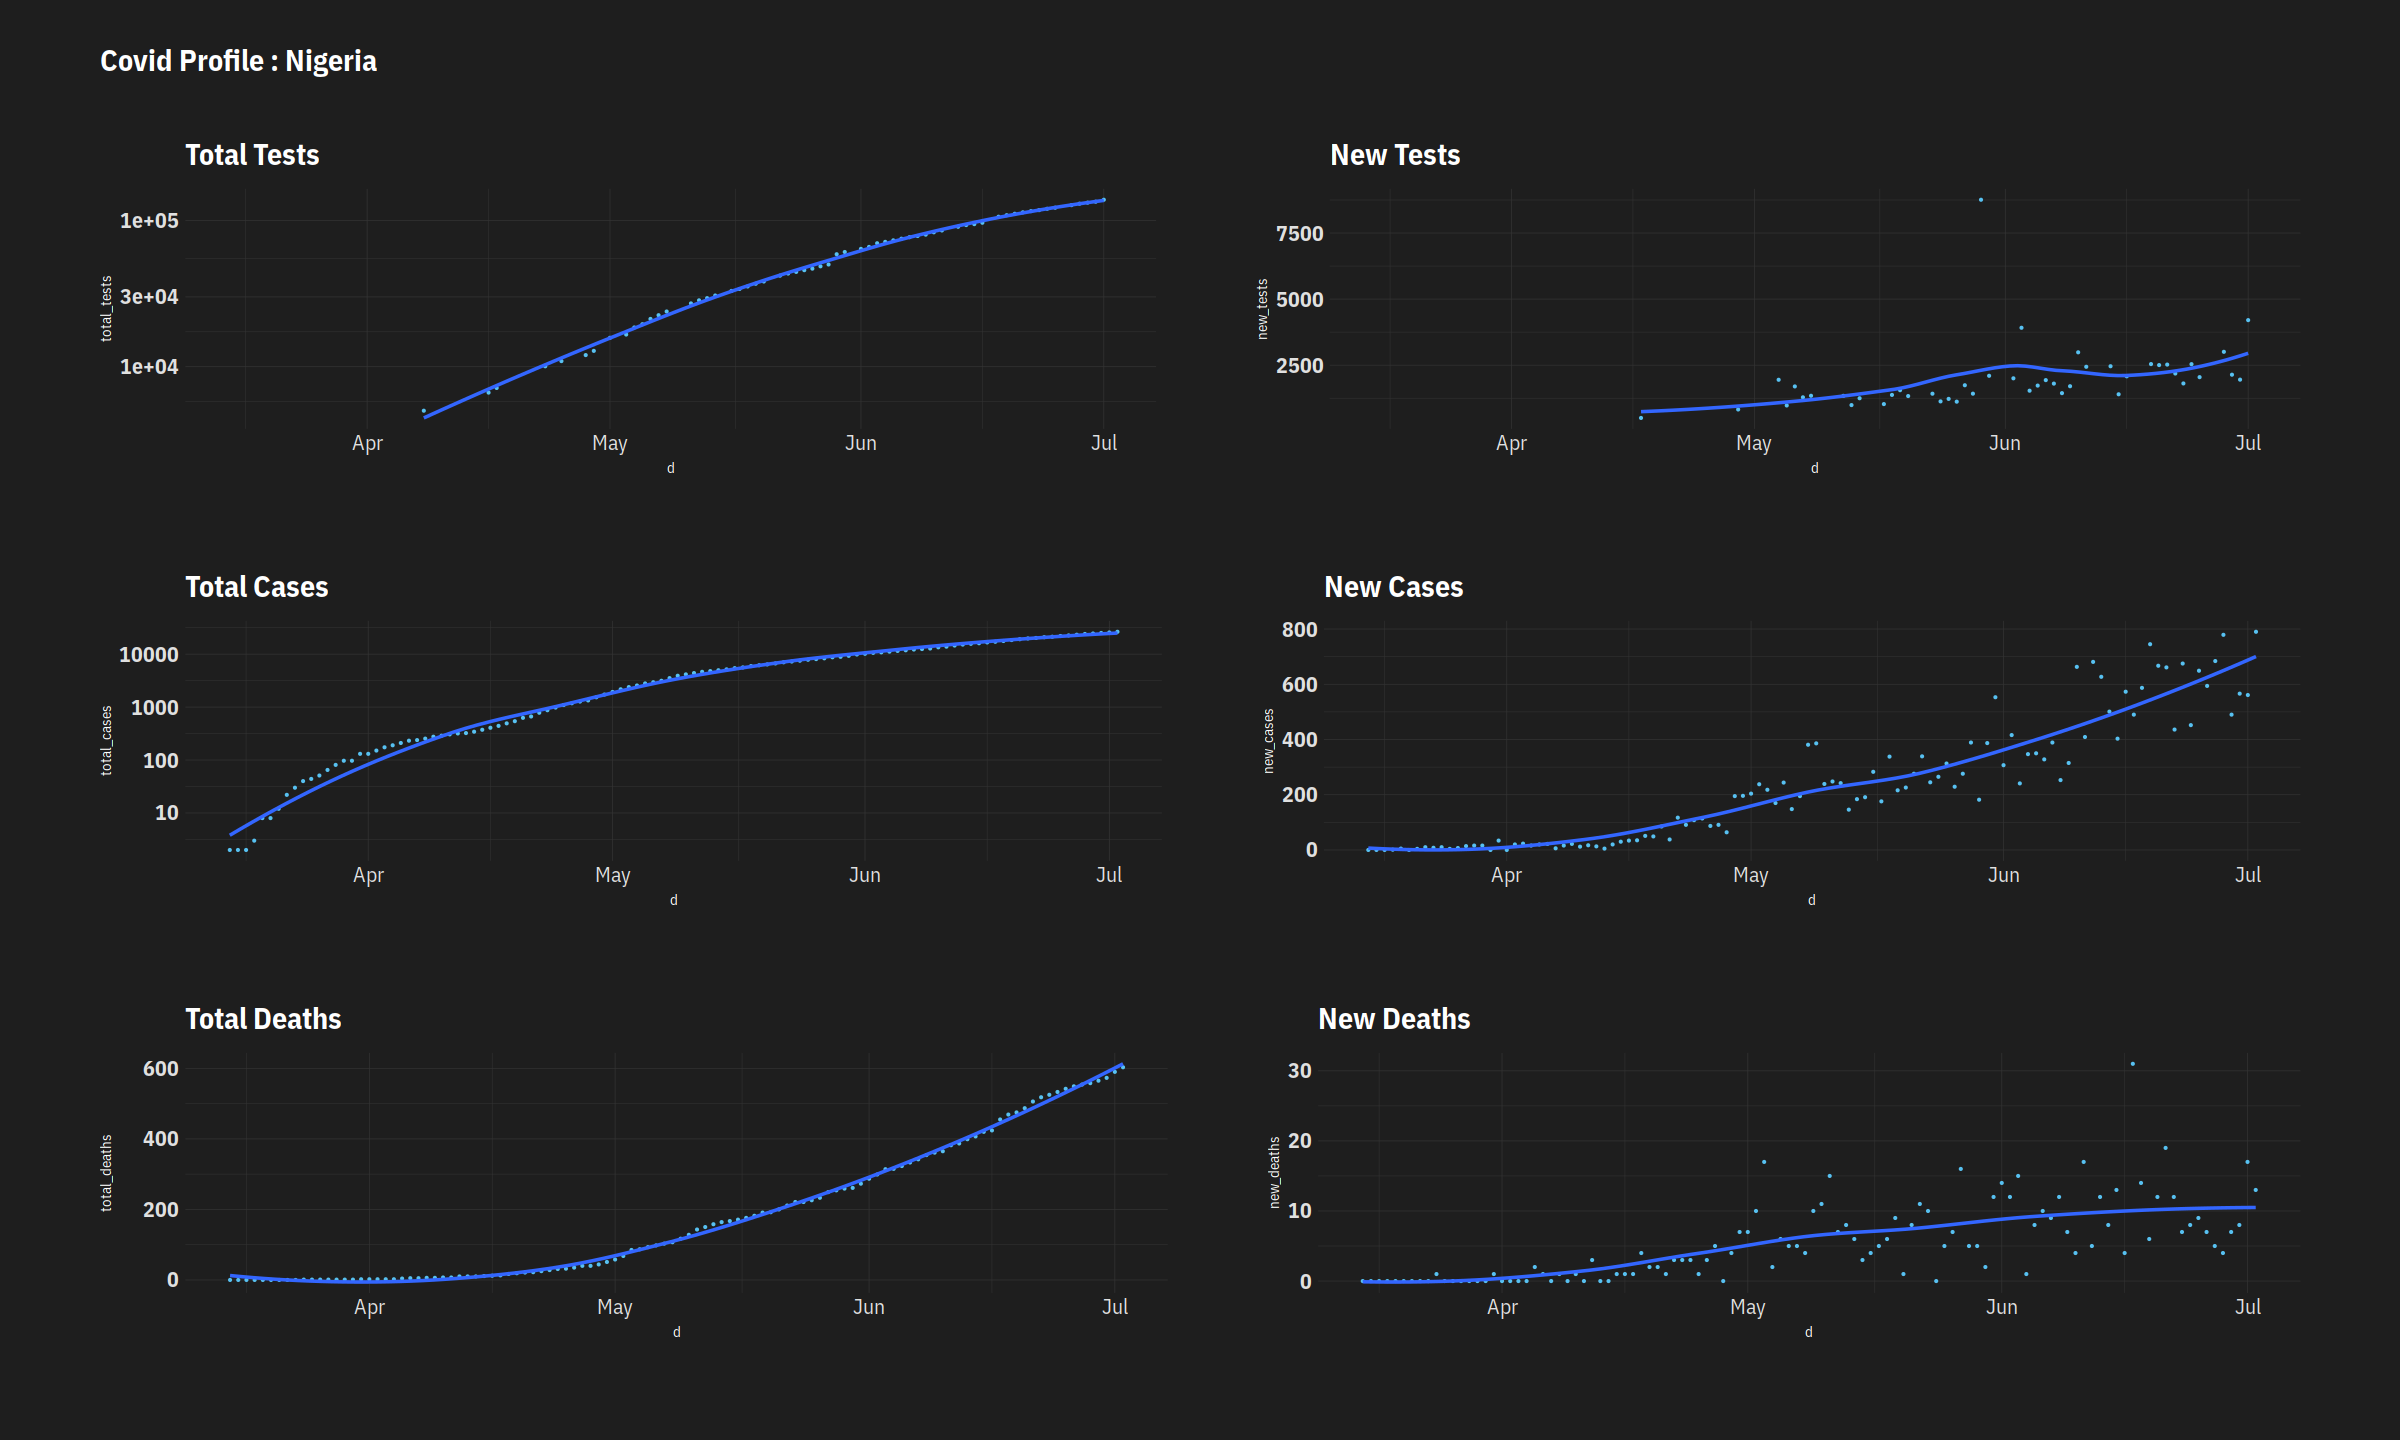

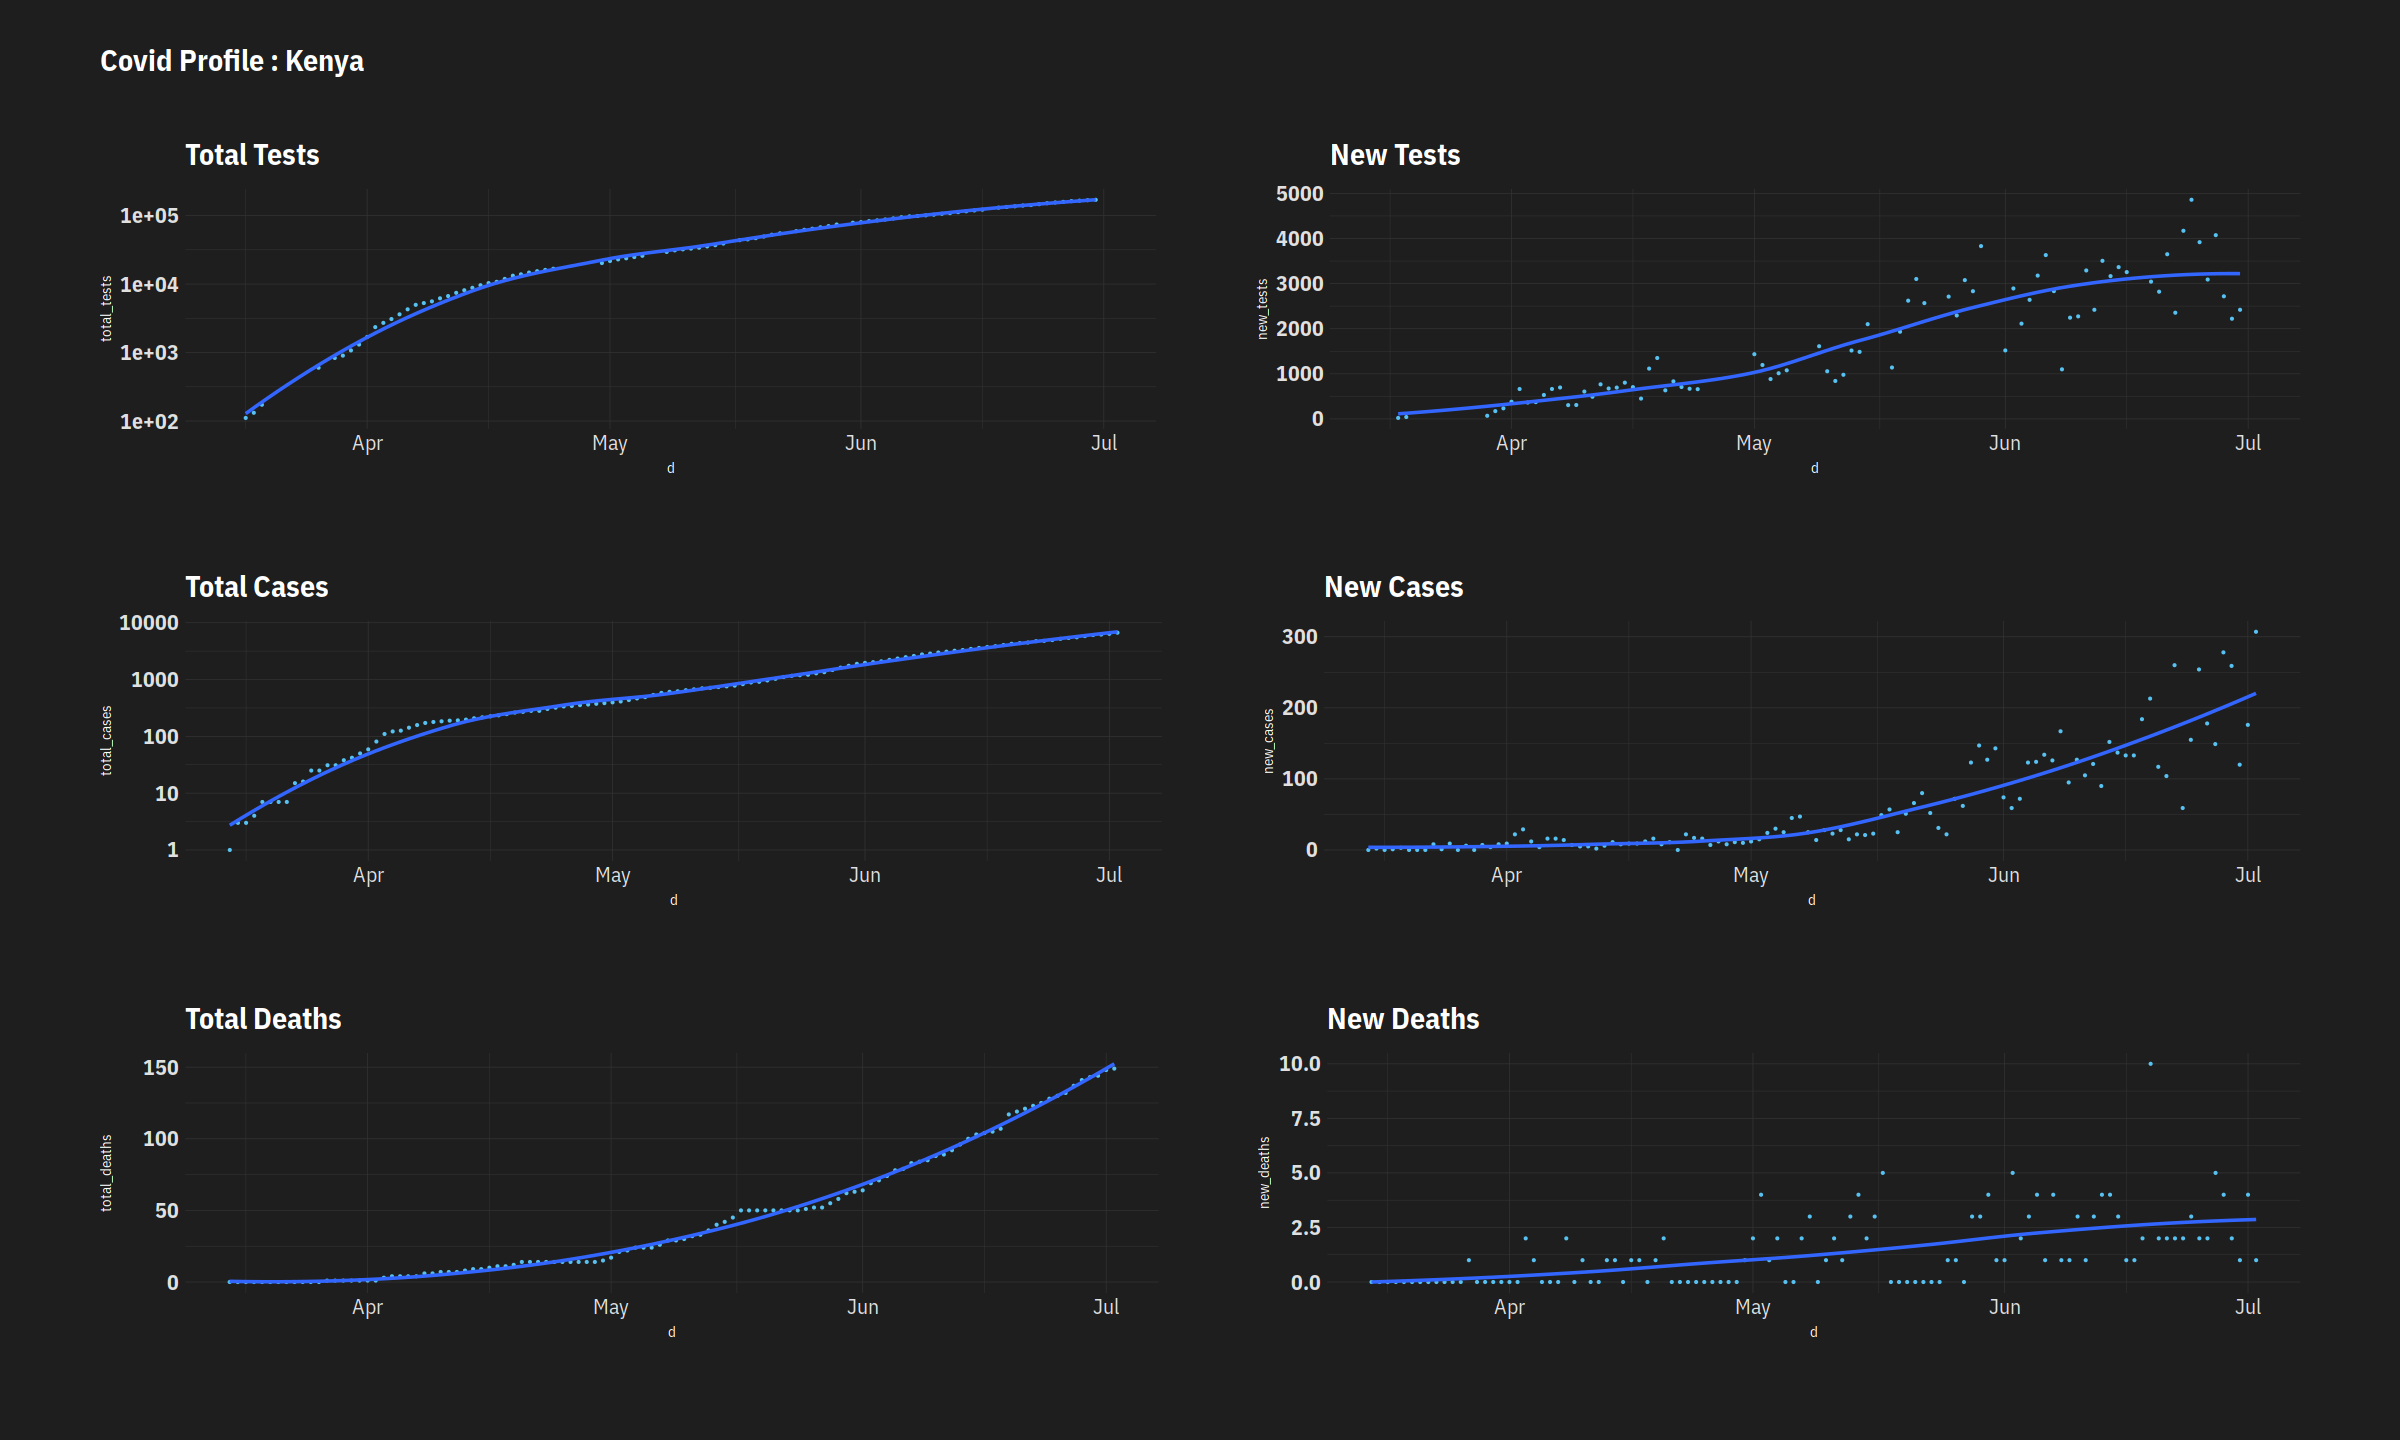

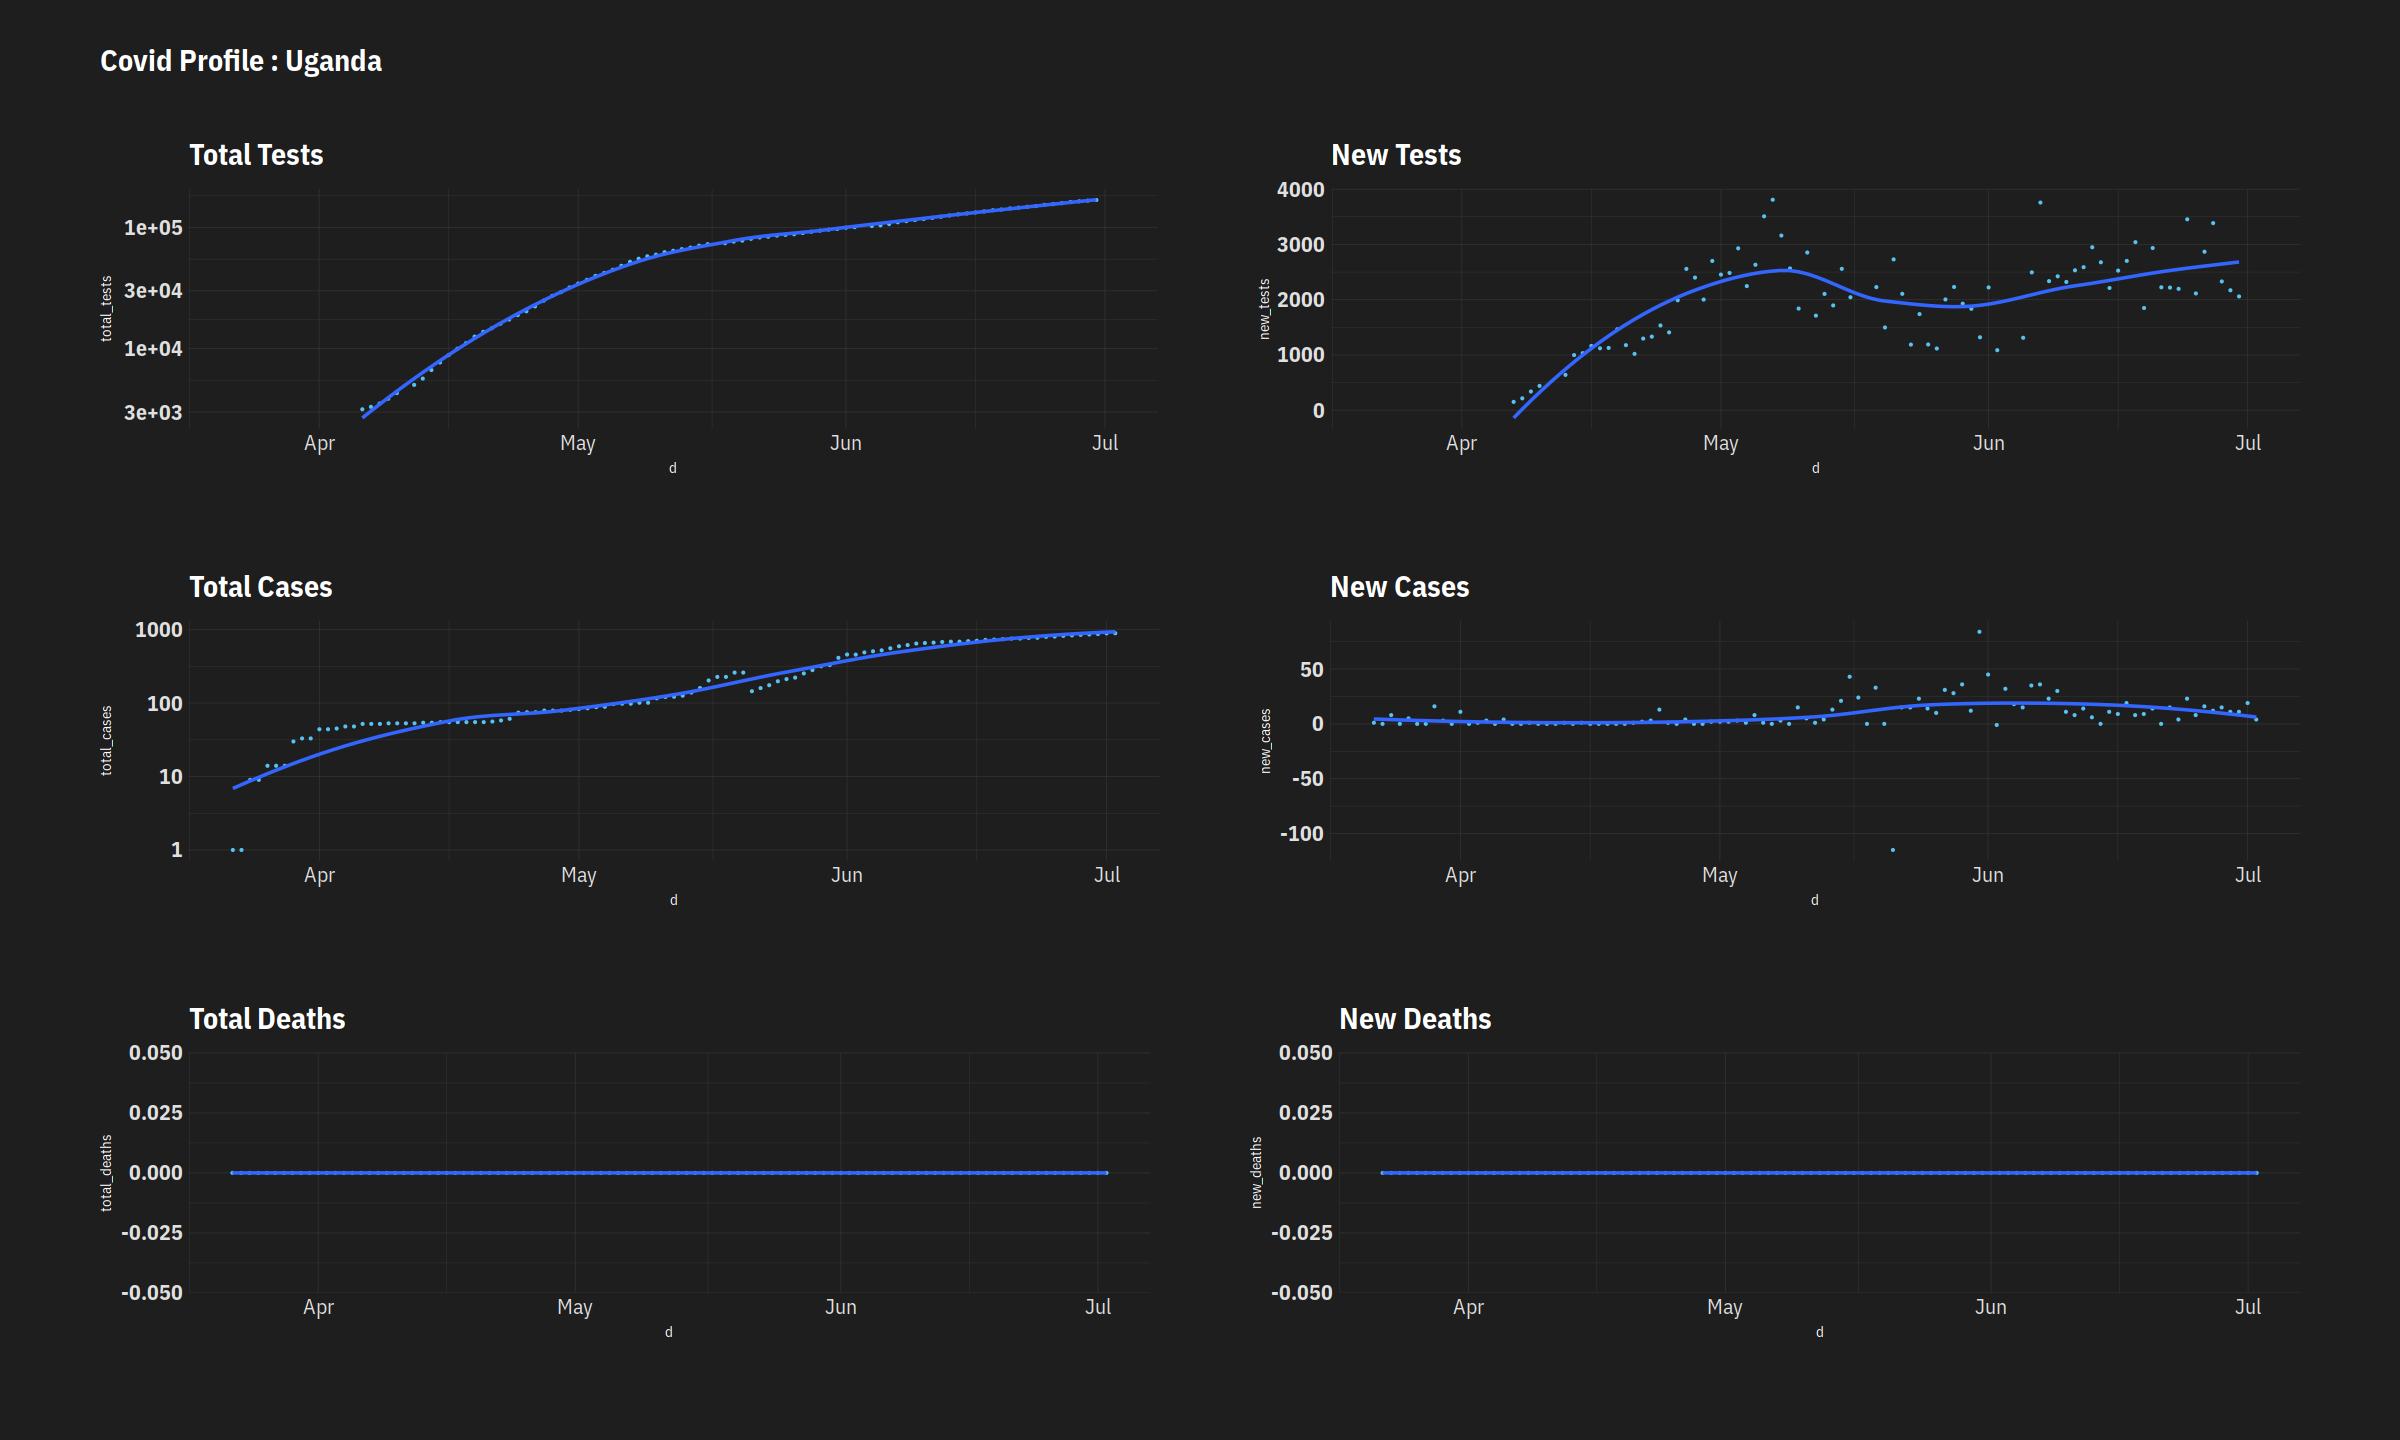

In [26]:
country_plot("Ghana")
country_plot("Nigeria")
country_plot("Kenya")
country_plot("Uganda")

## Eastern Europe

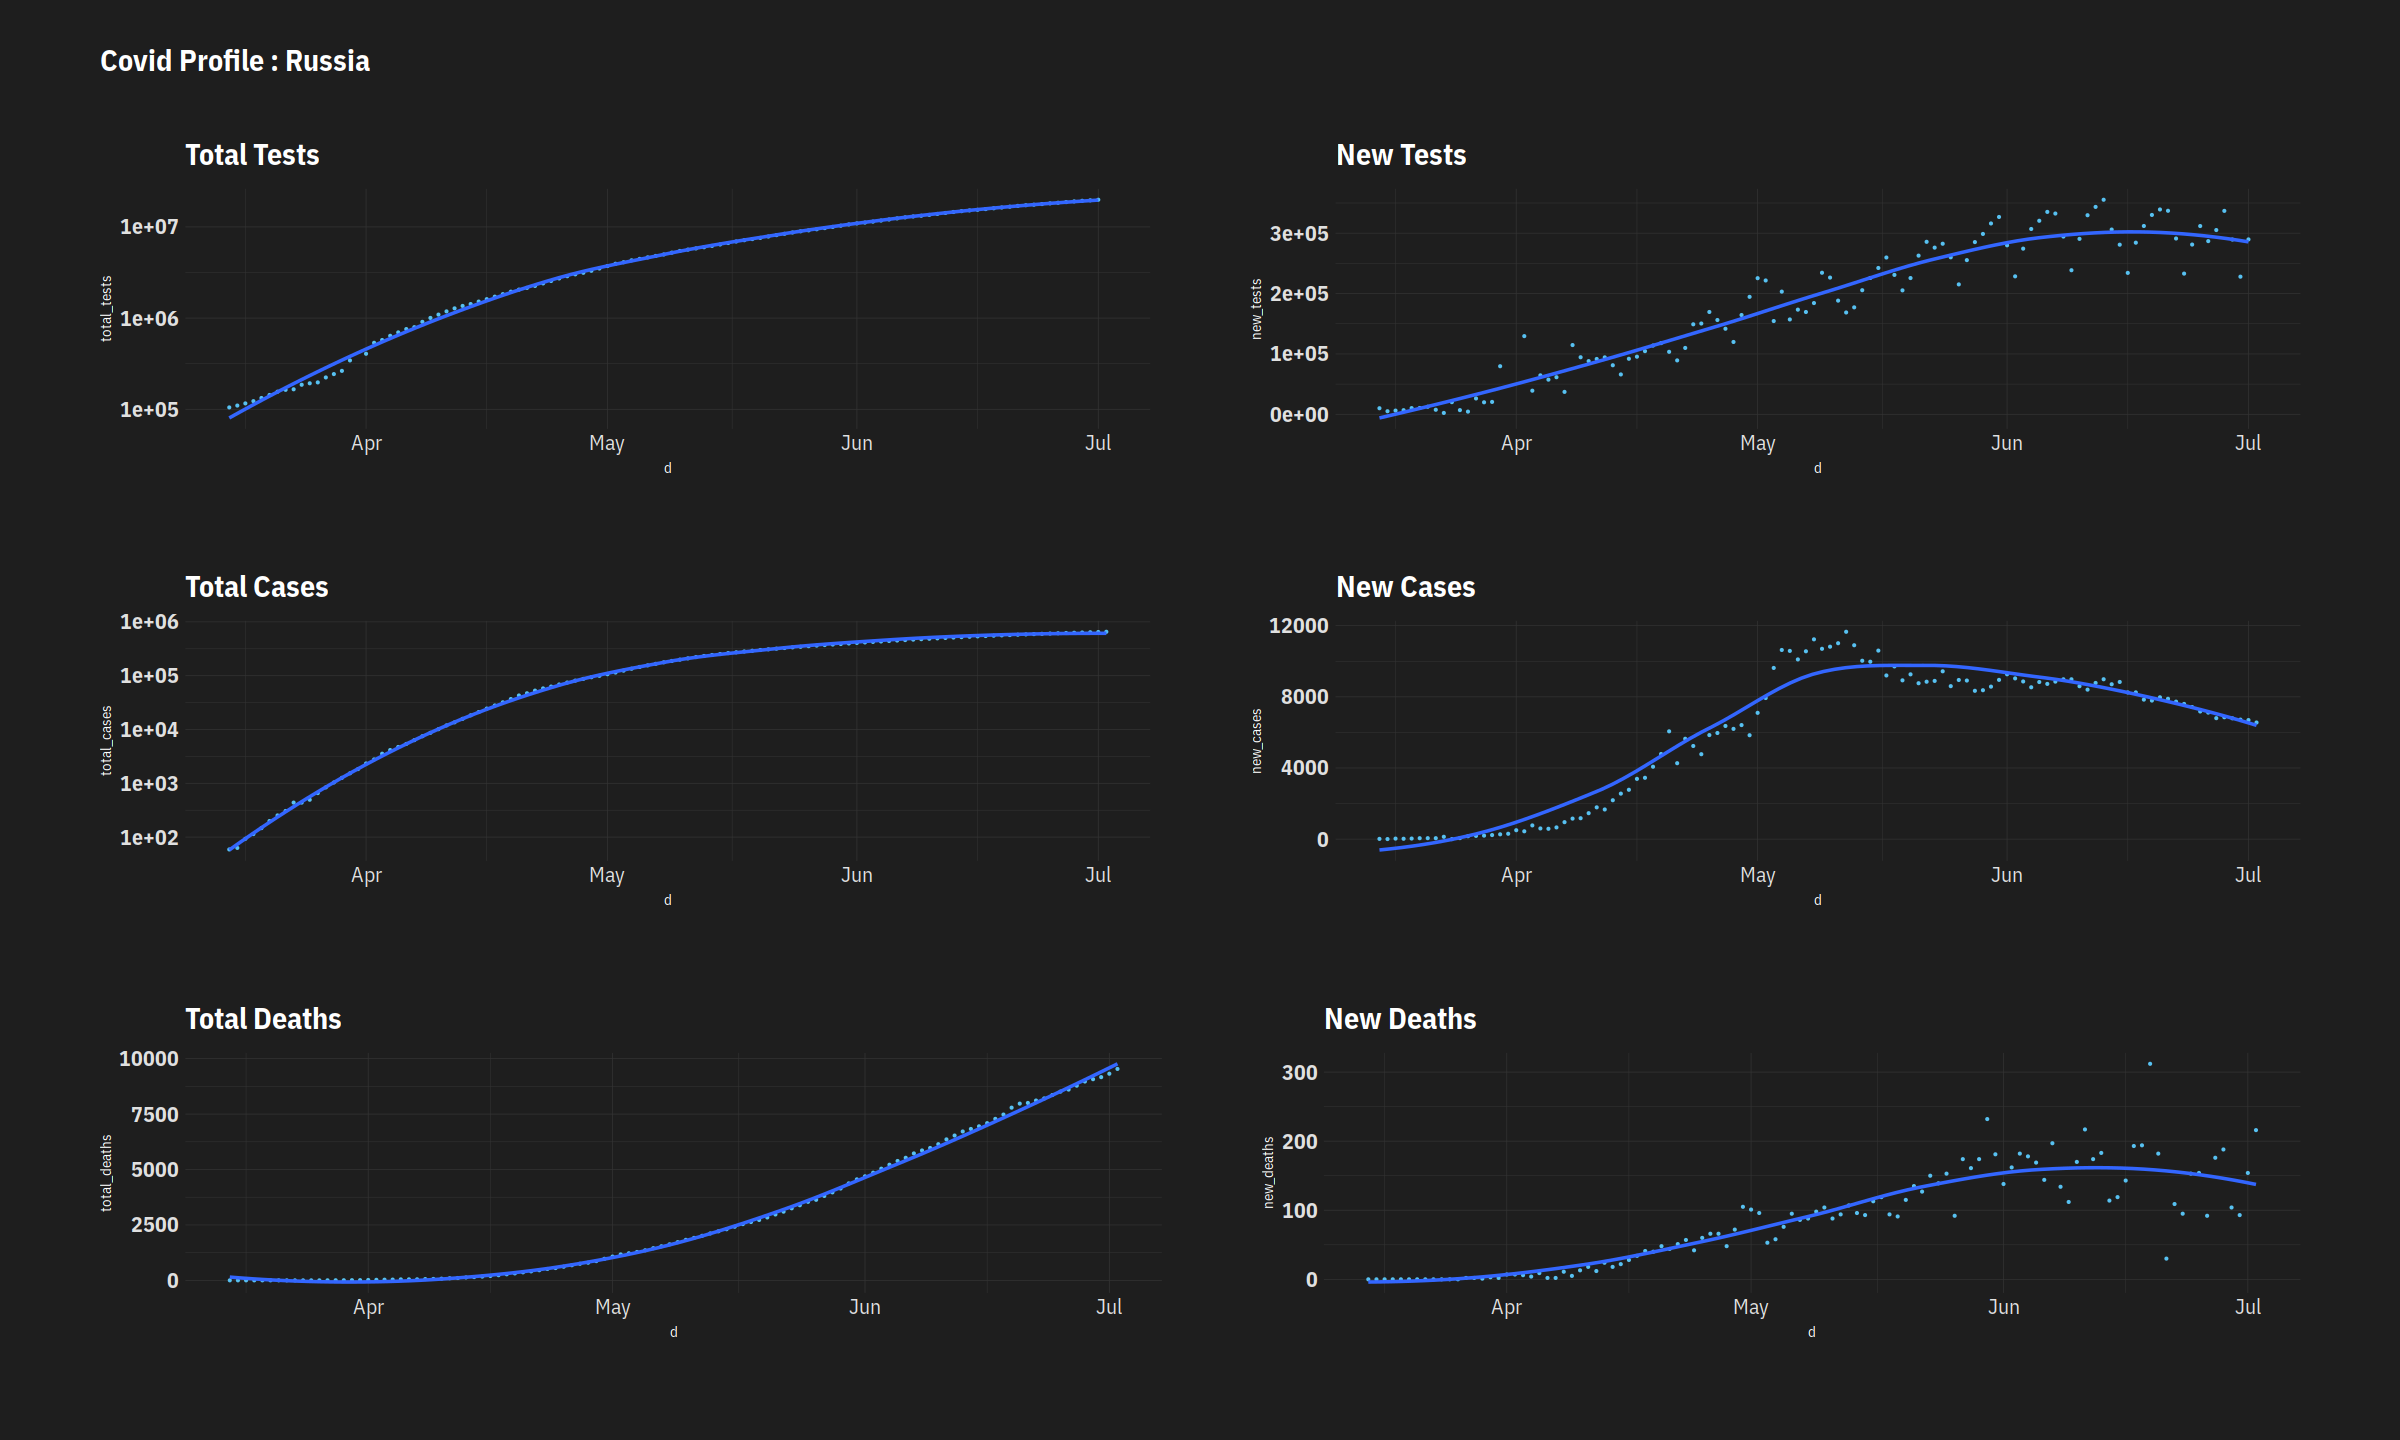

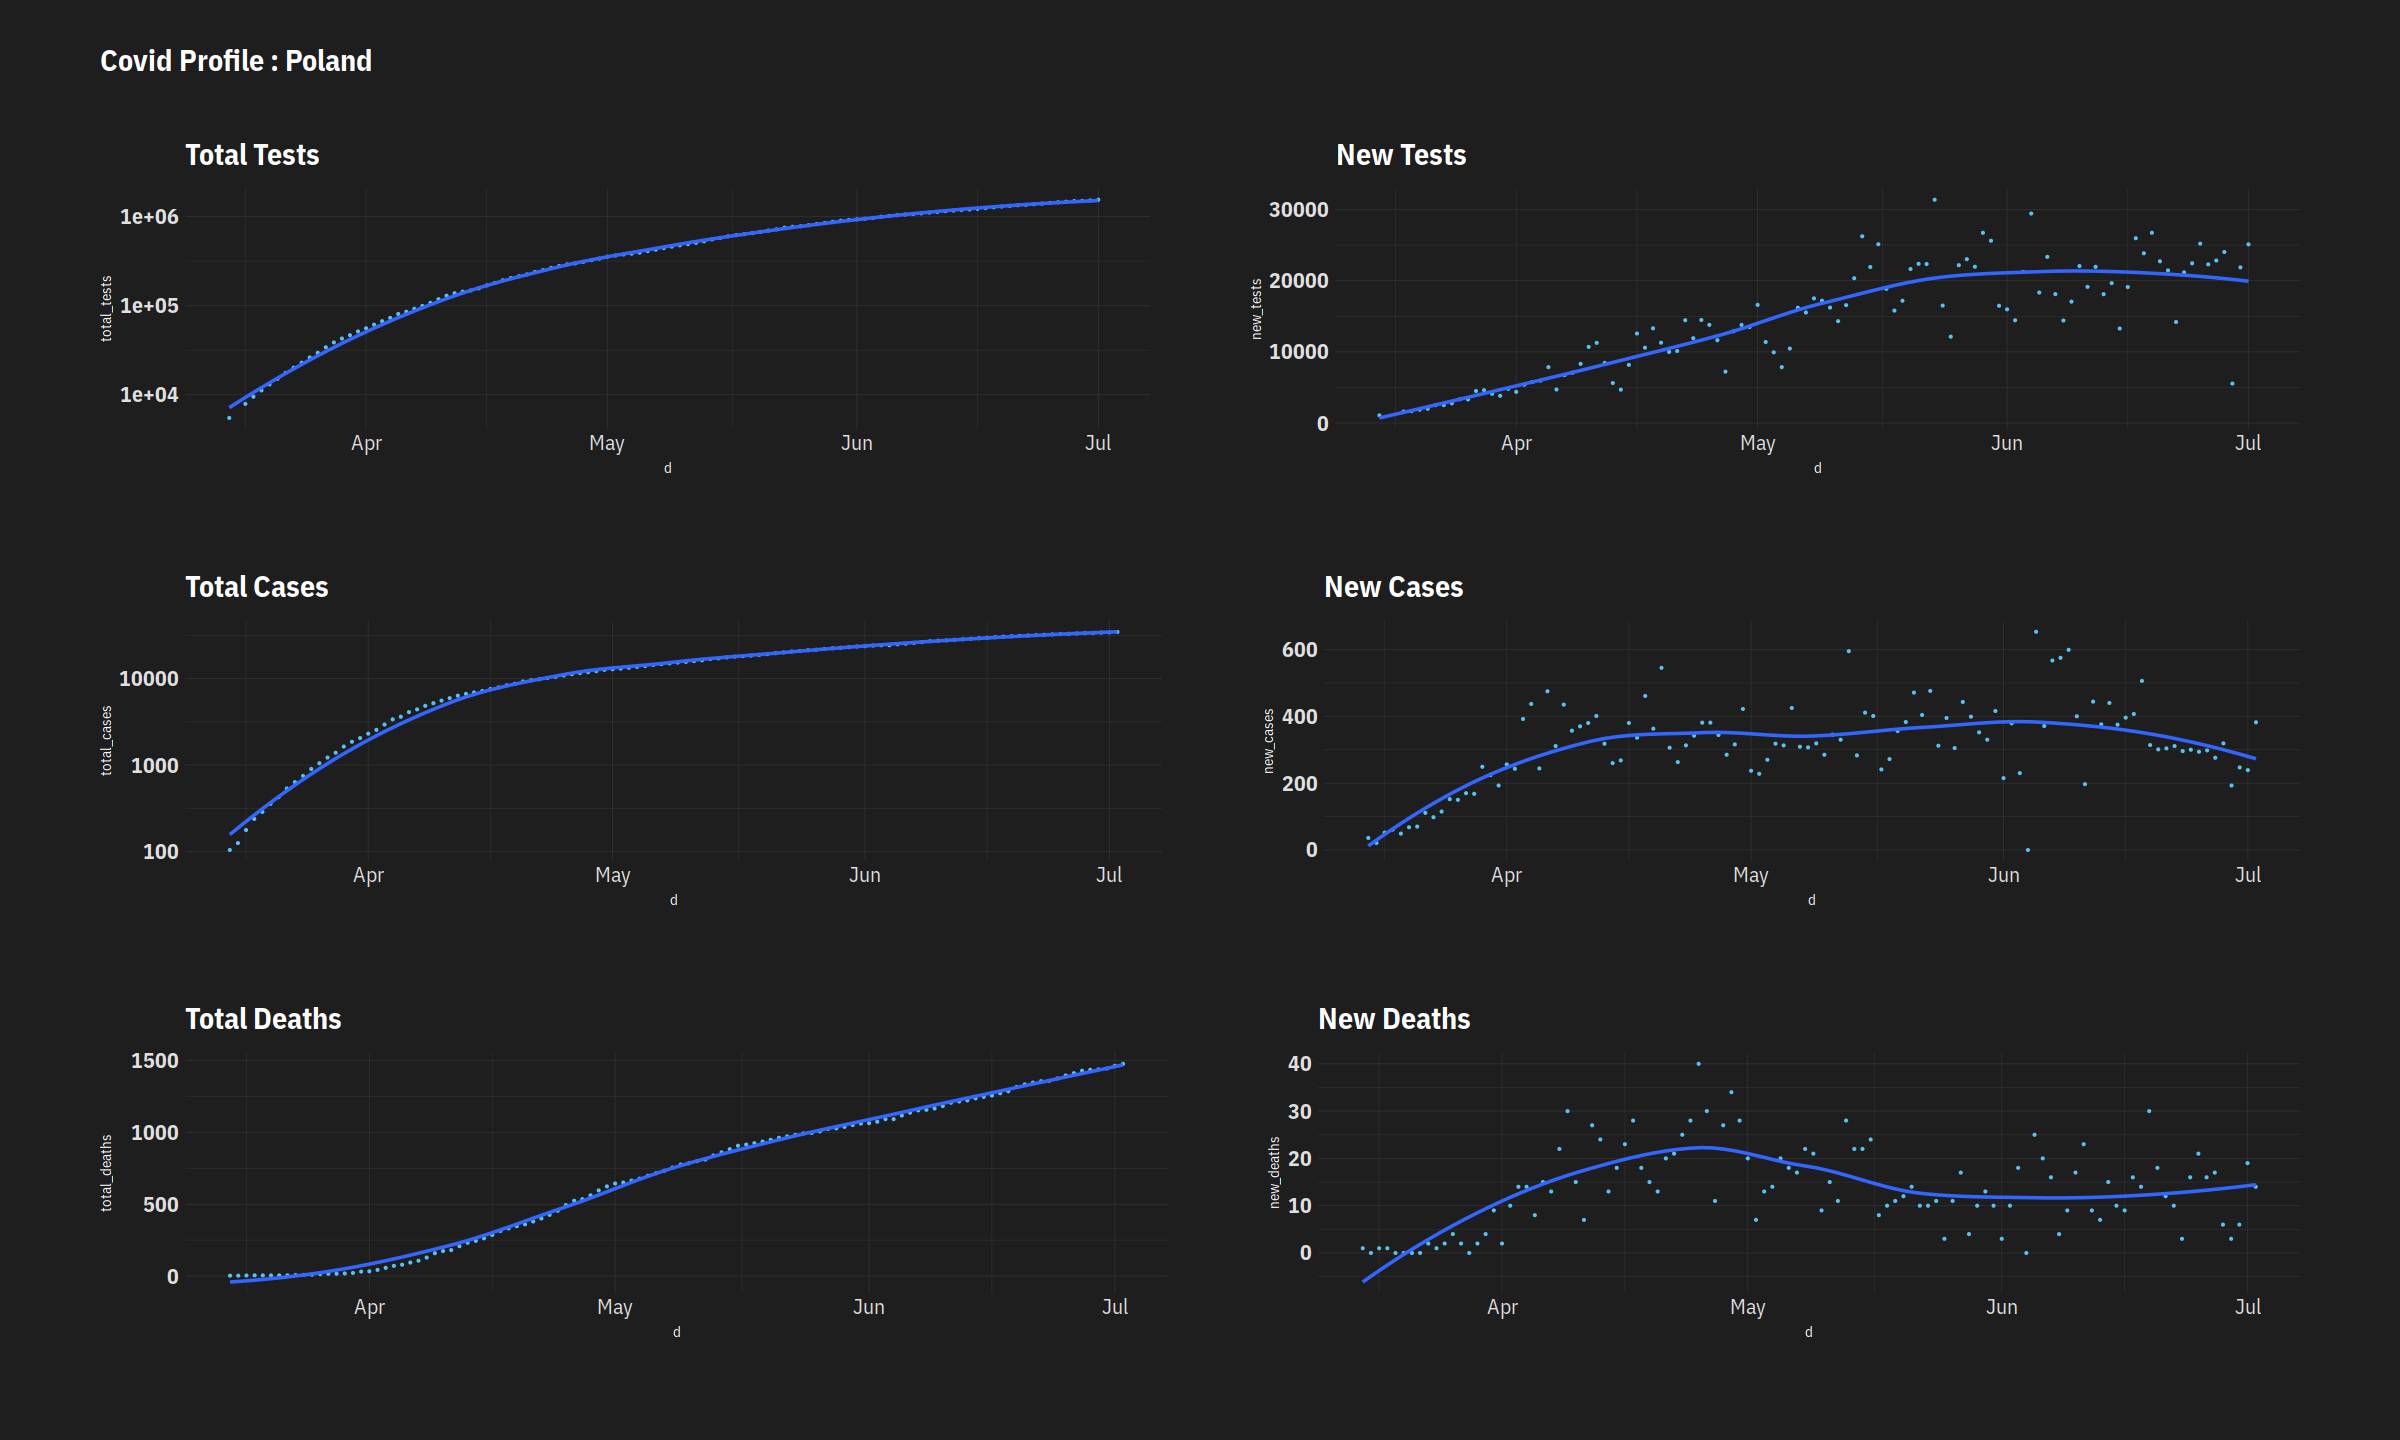

In [27]:
country_plot("Russia")
country_plot("Poland")

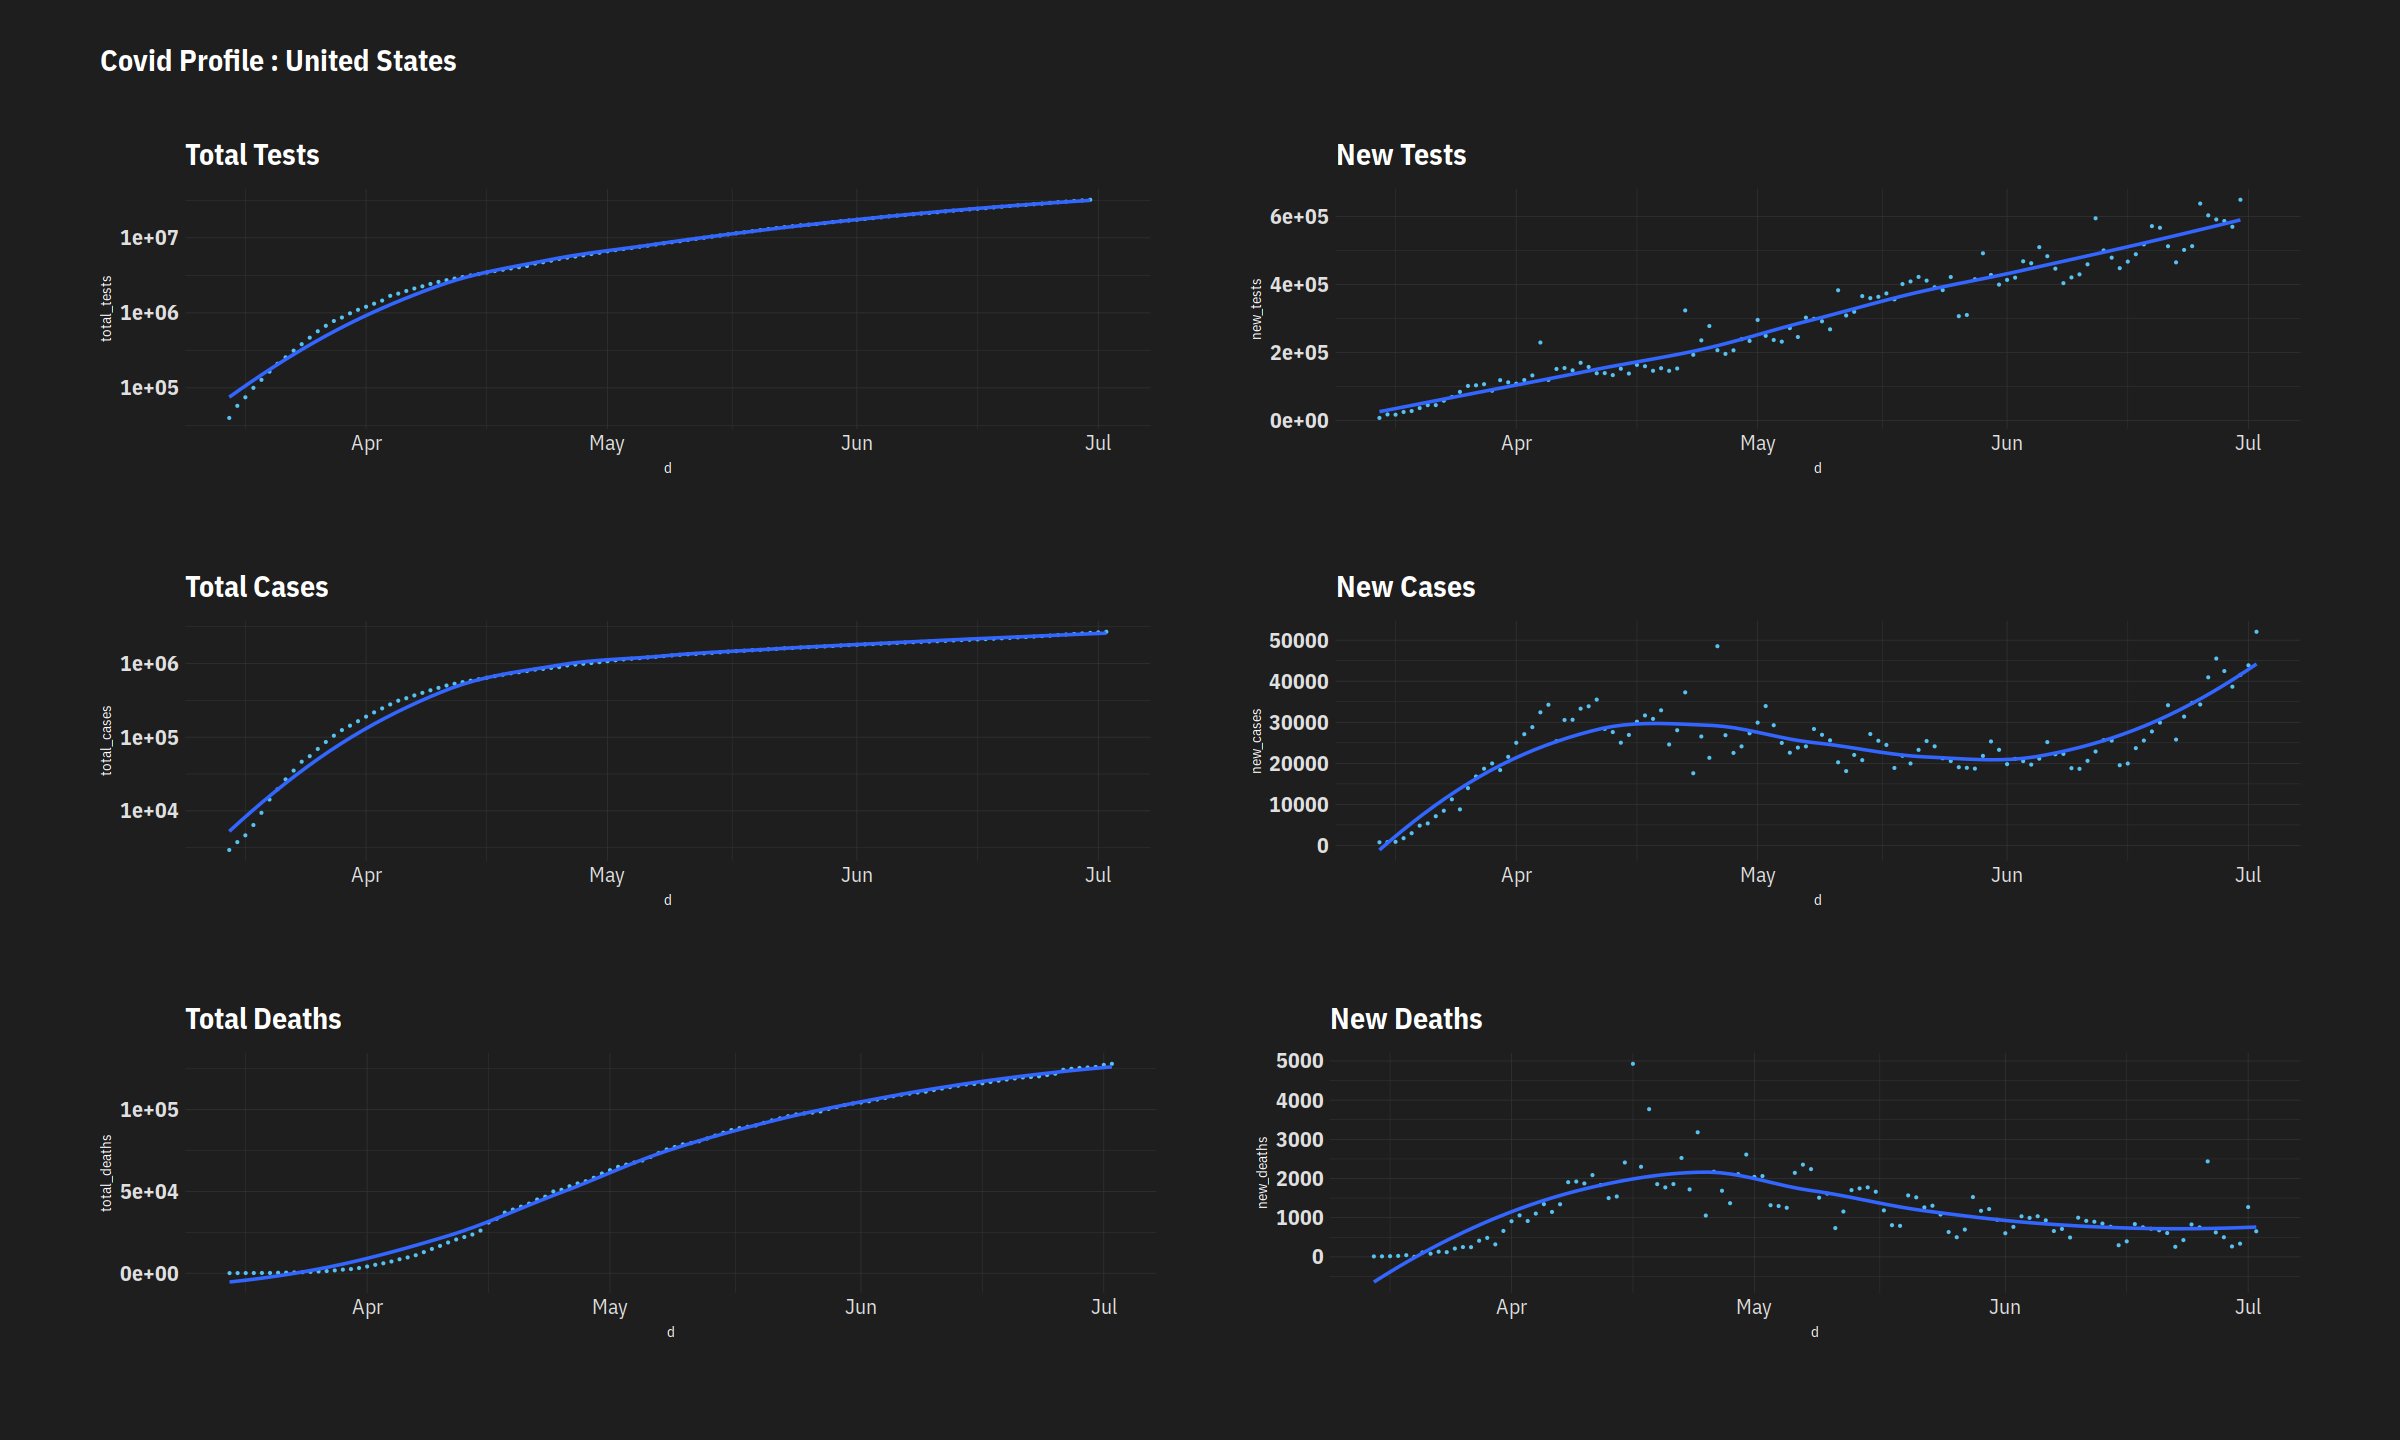

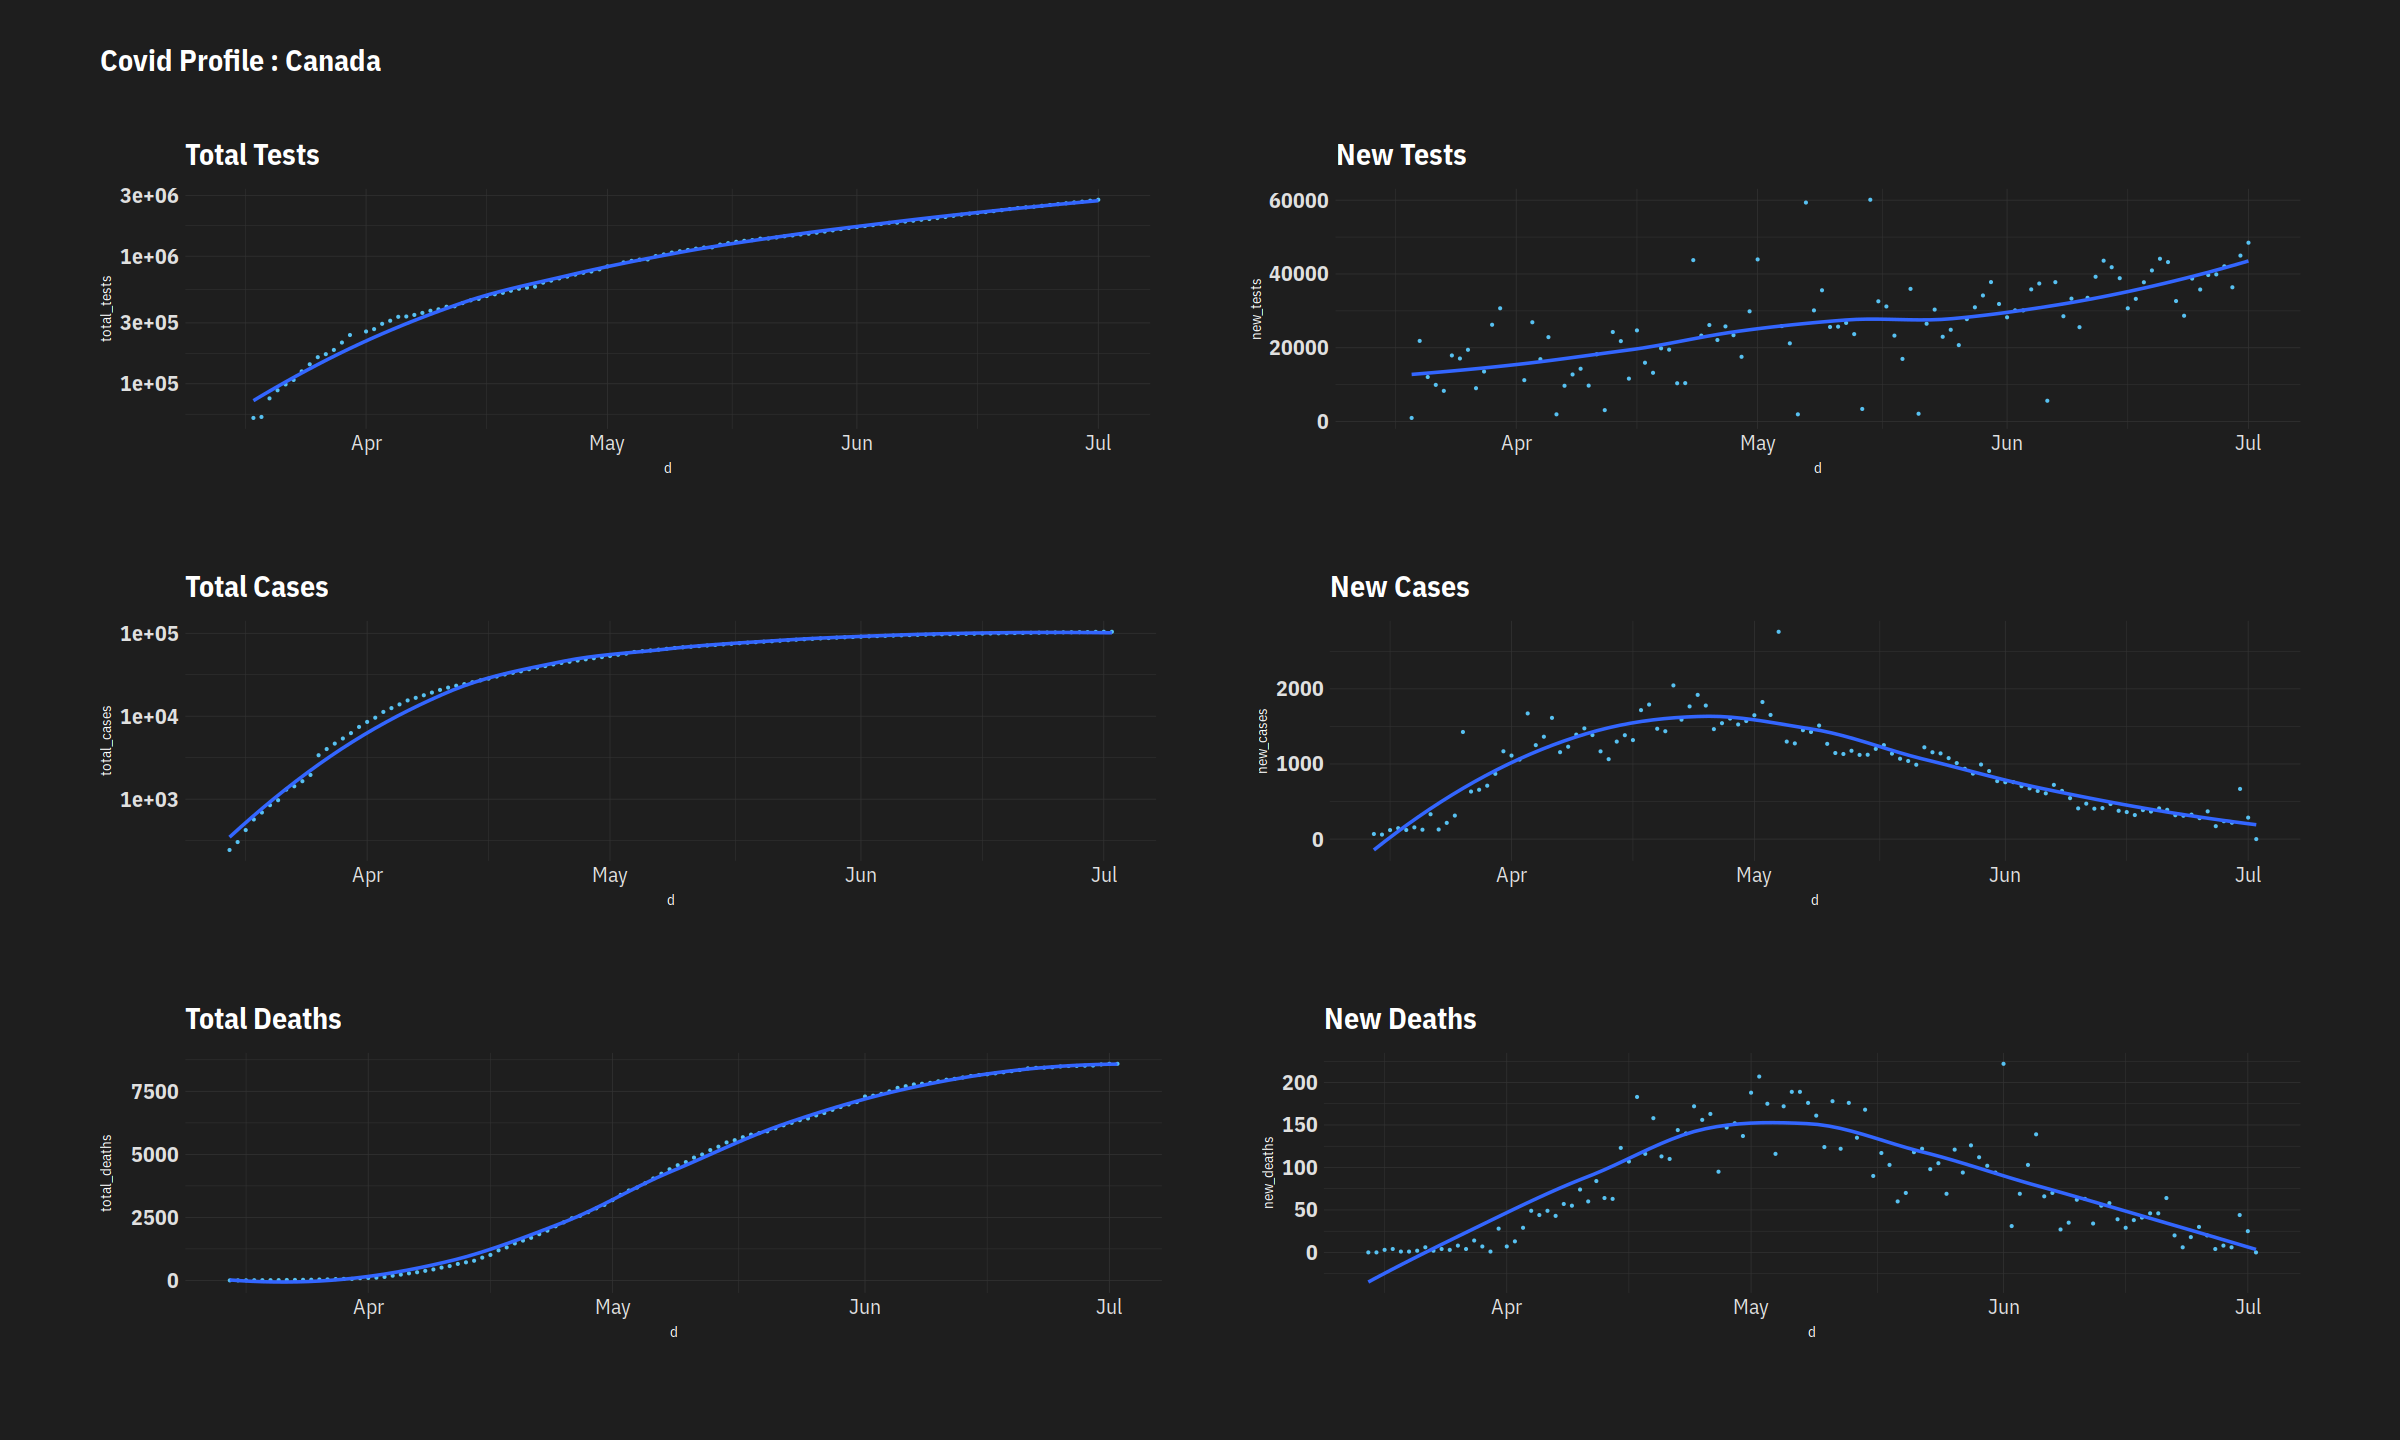

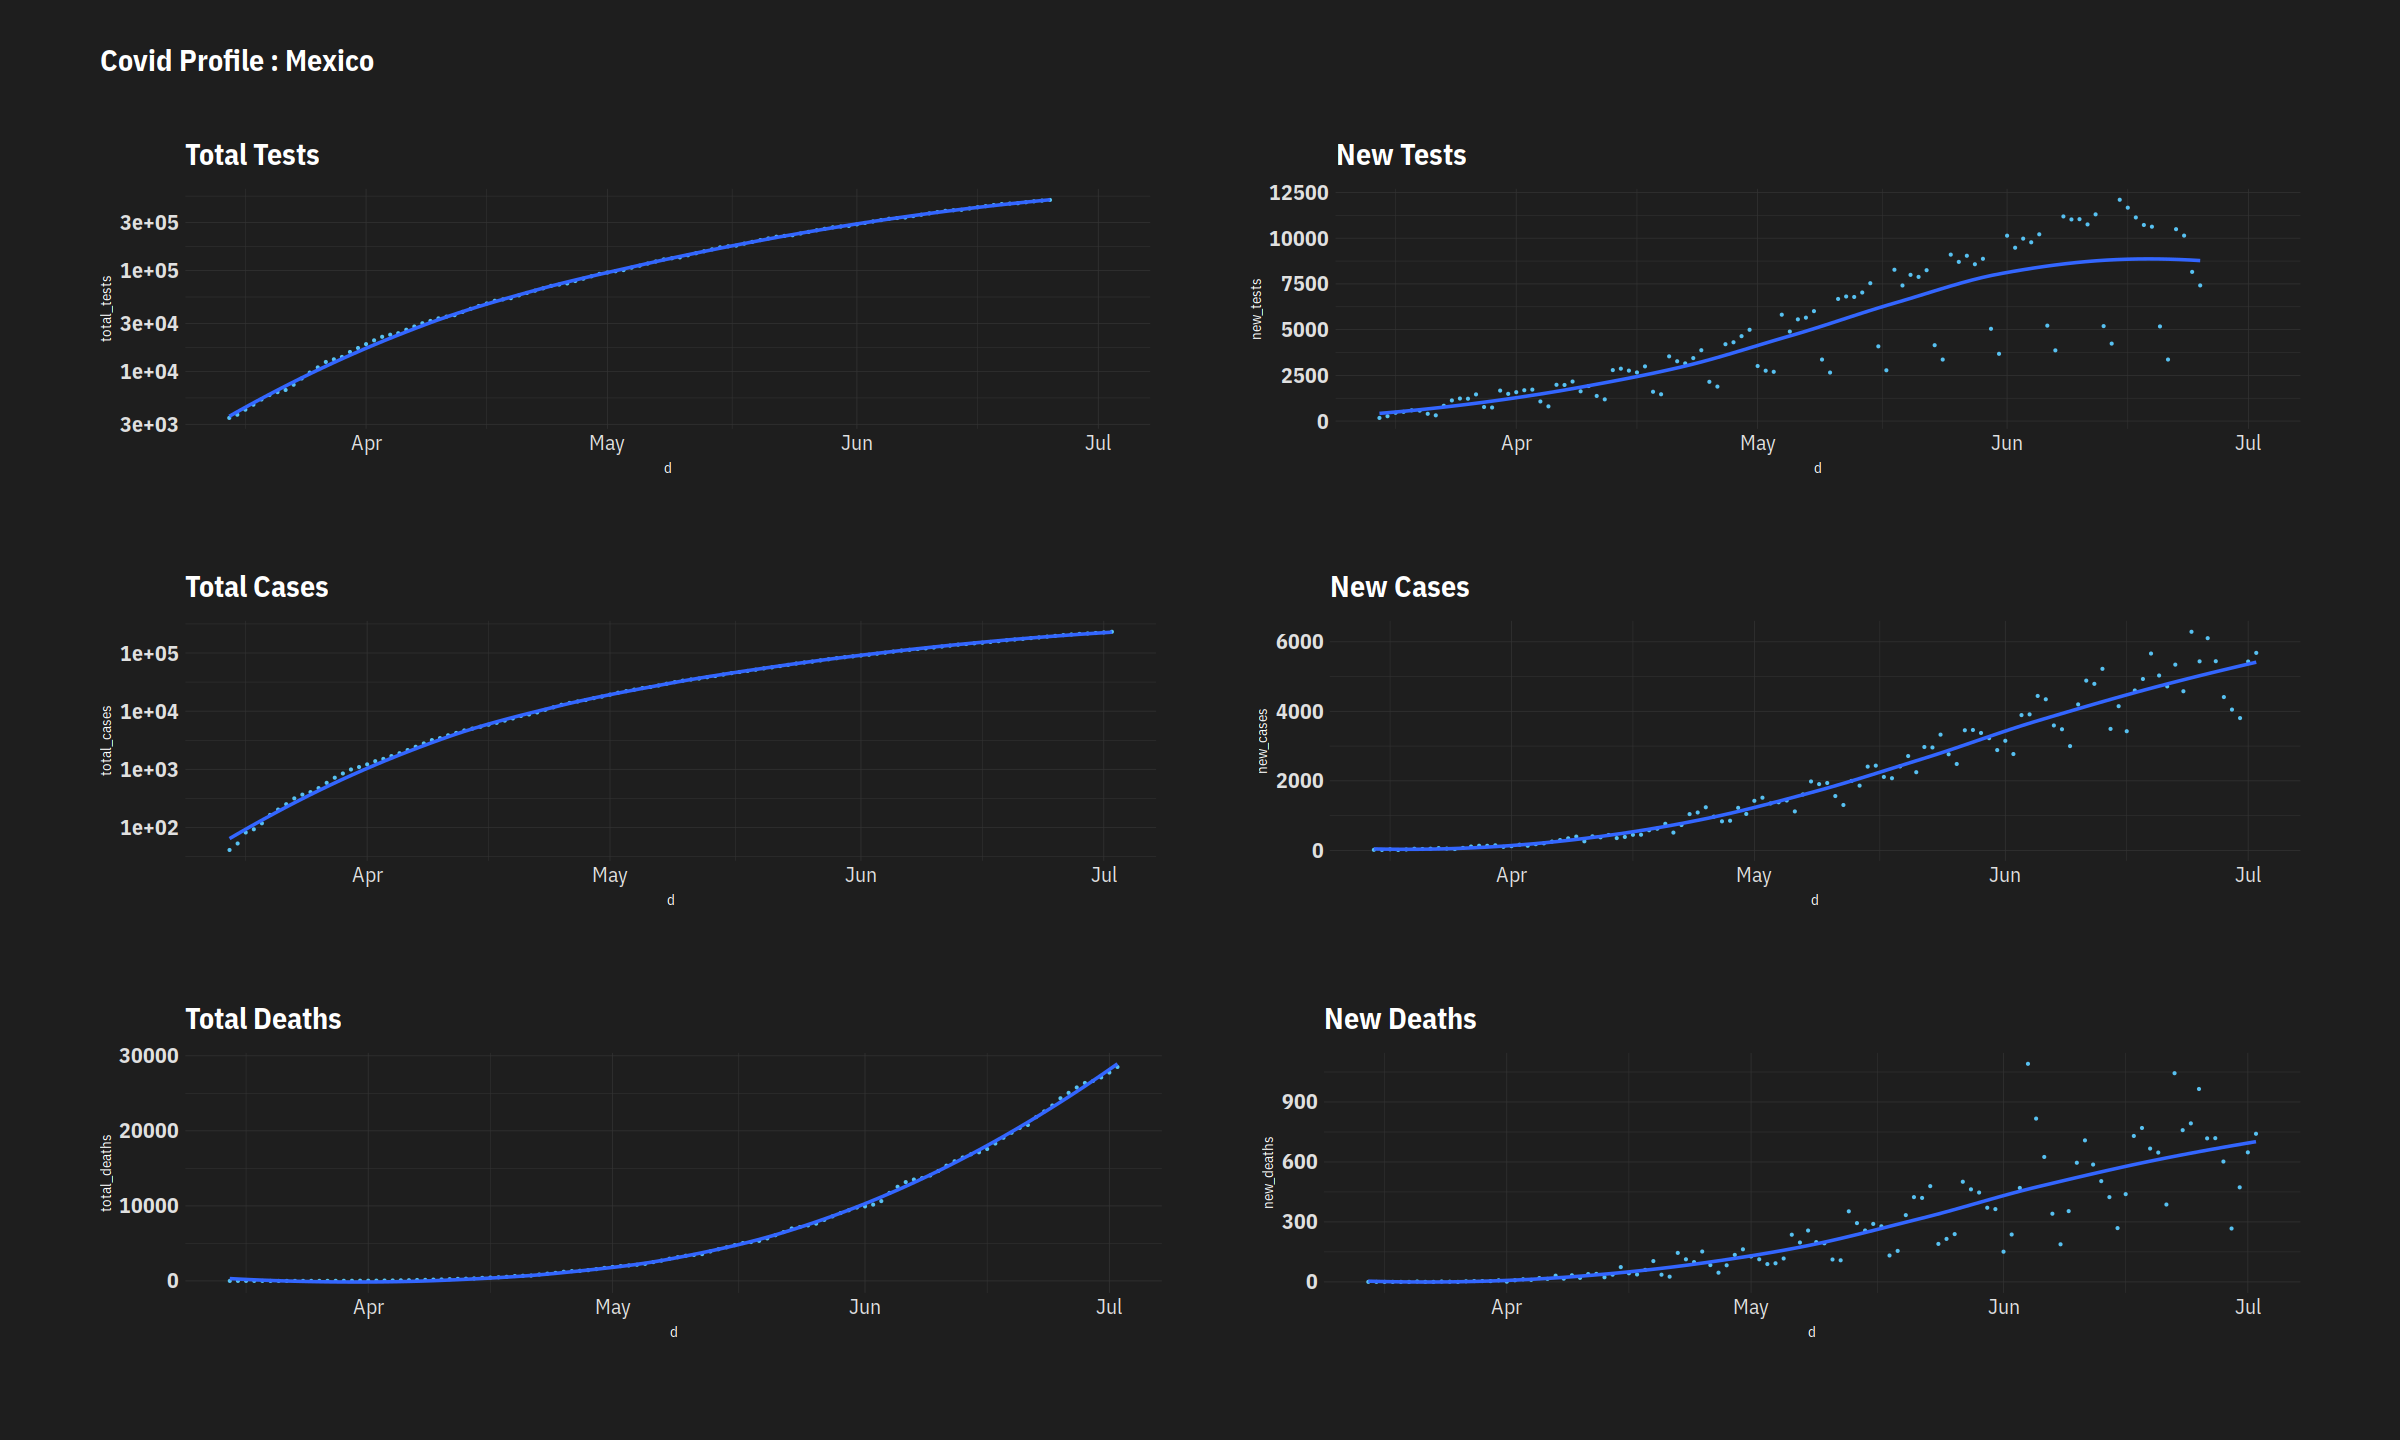

In [29]:
country_plot("United States")
country_plot("Canada")
country_plot("Mexico")

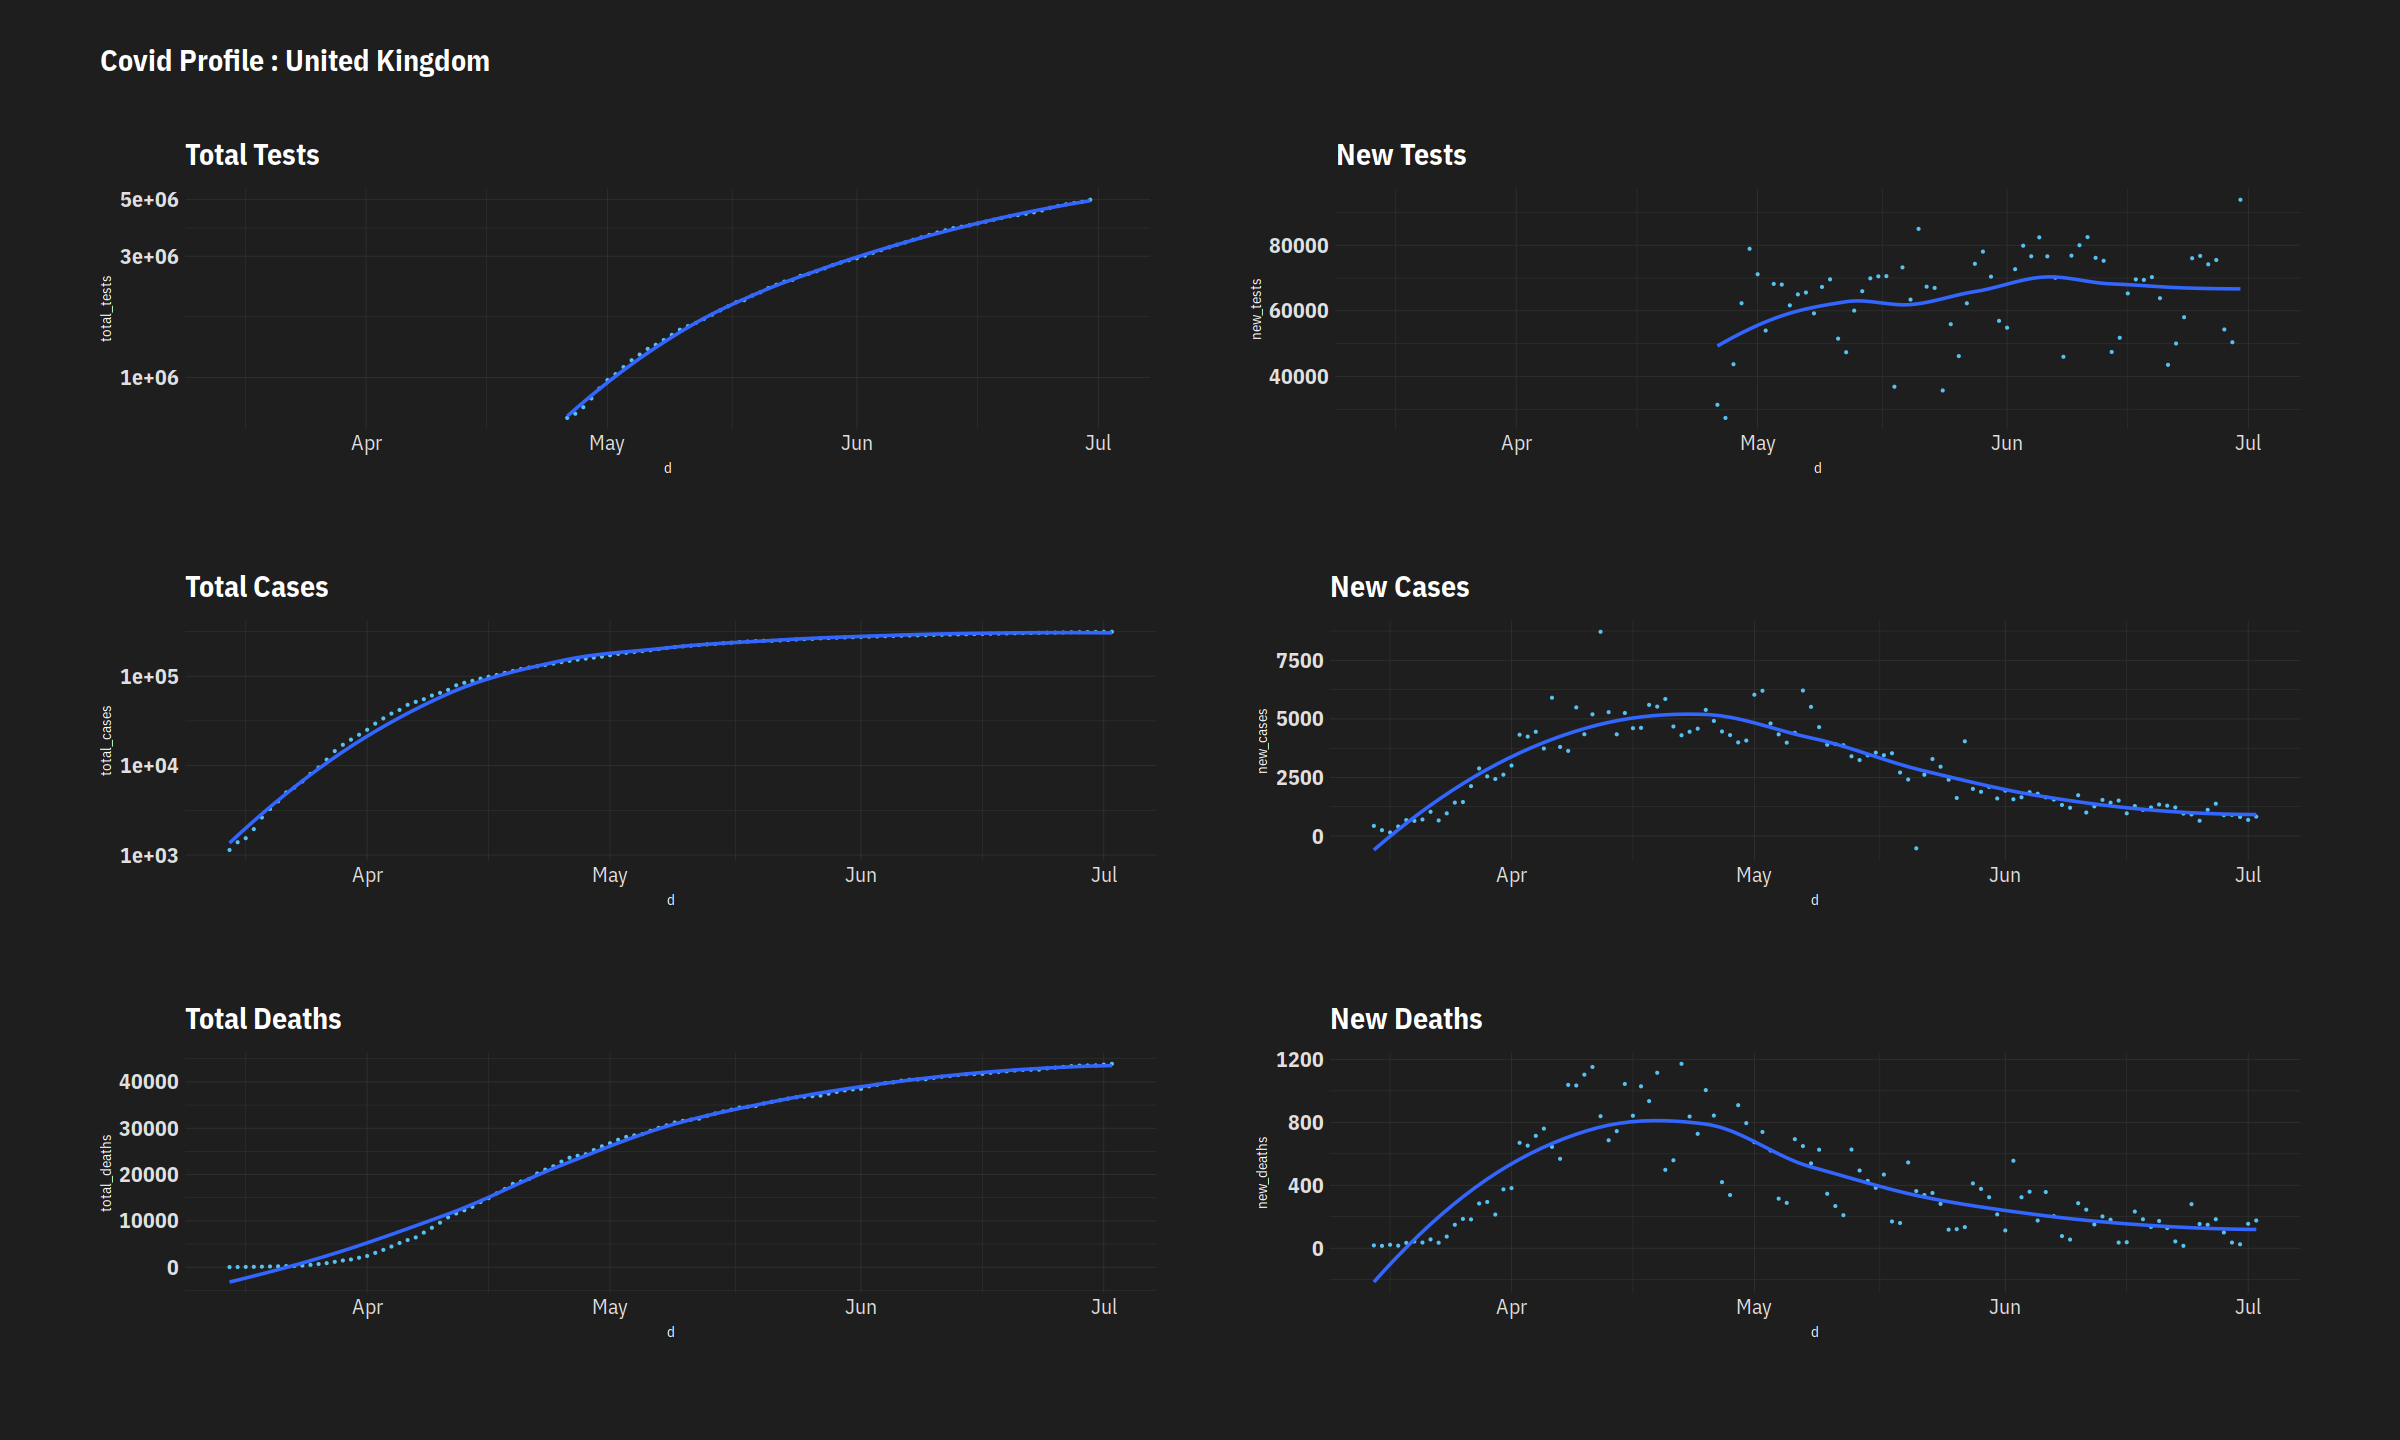

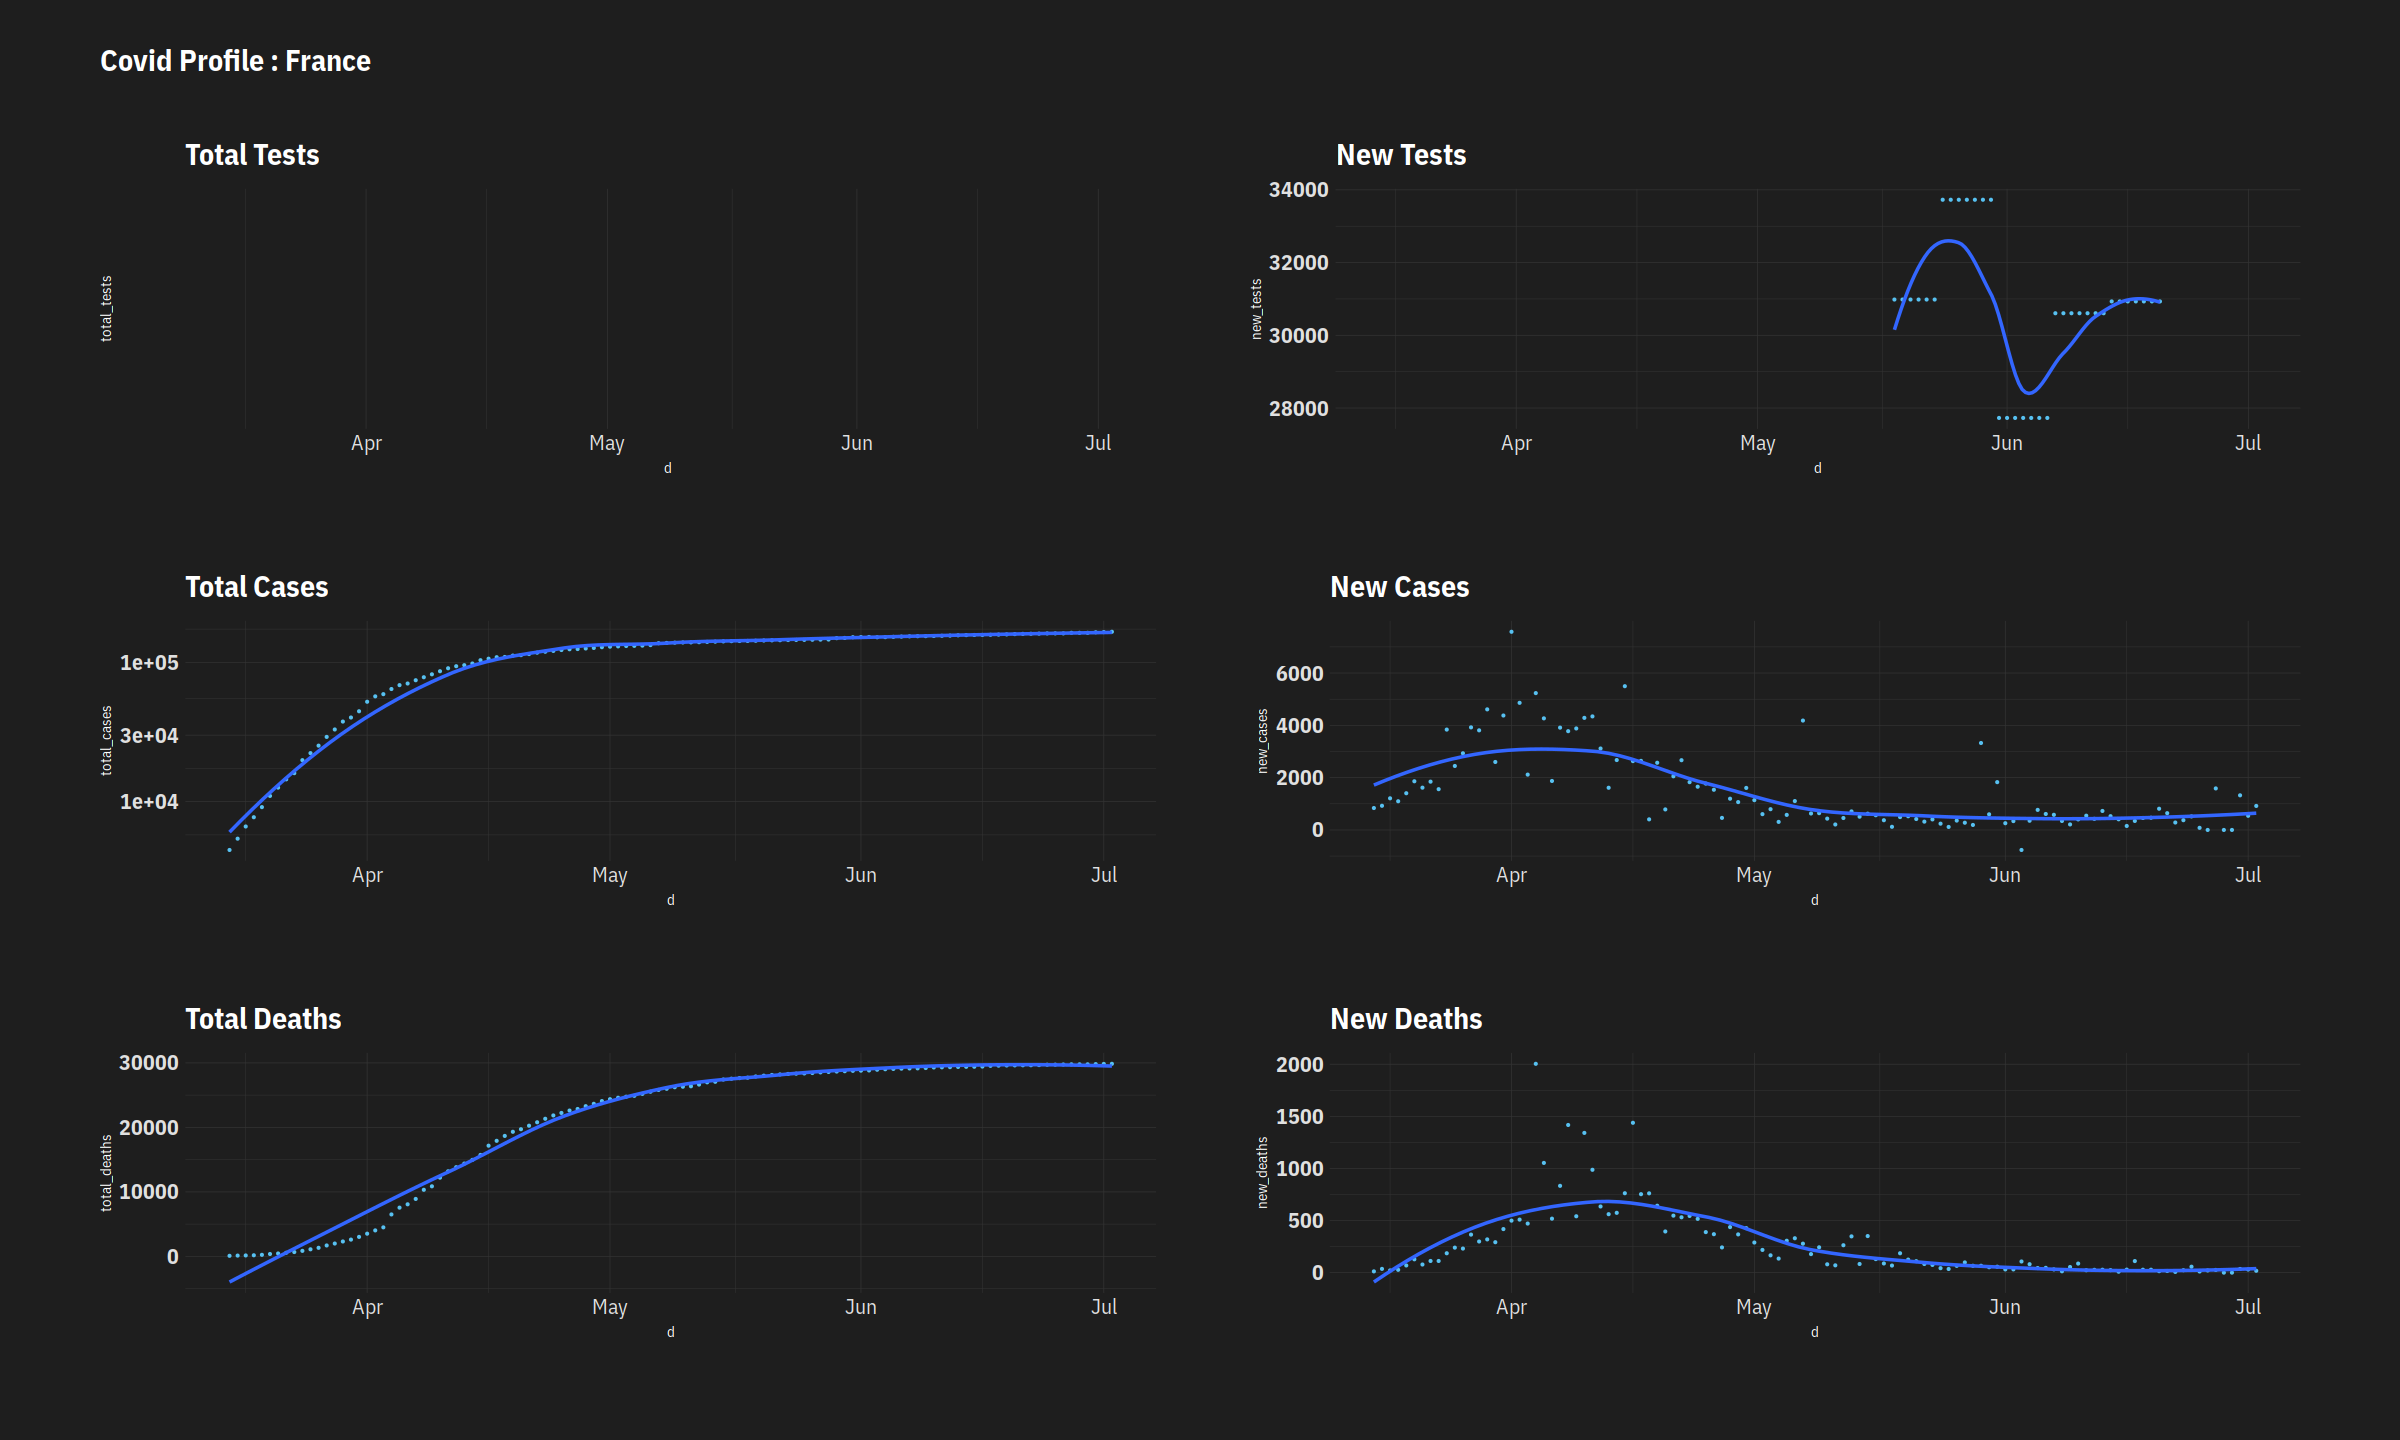

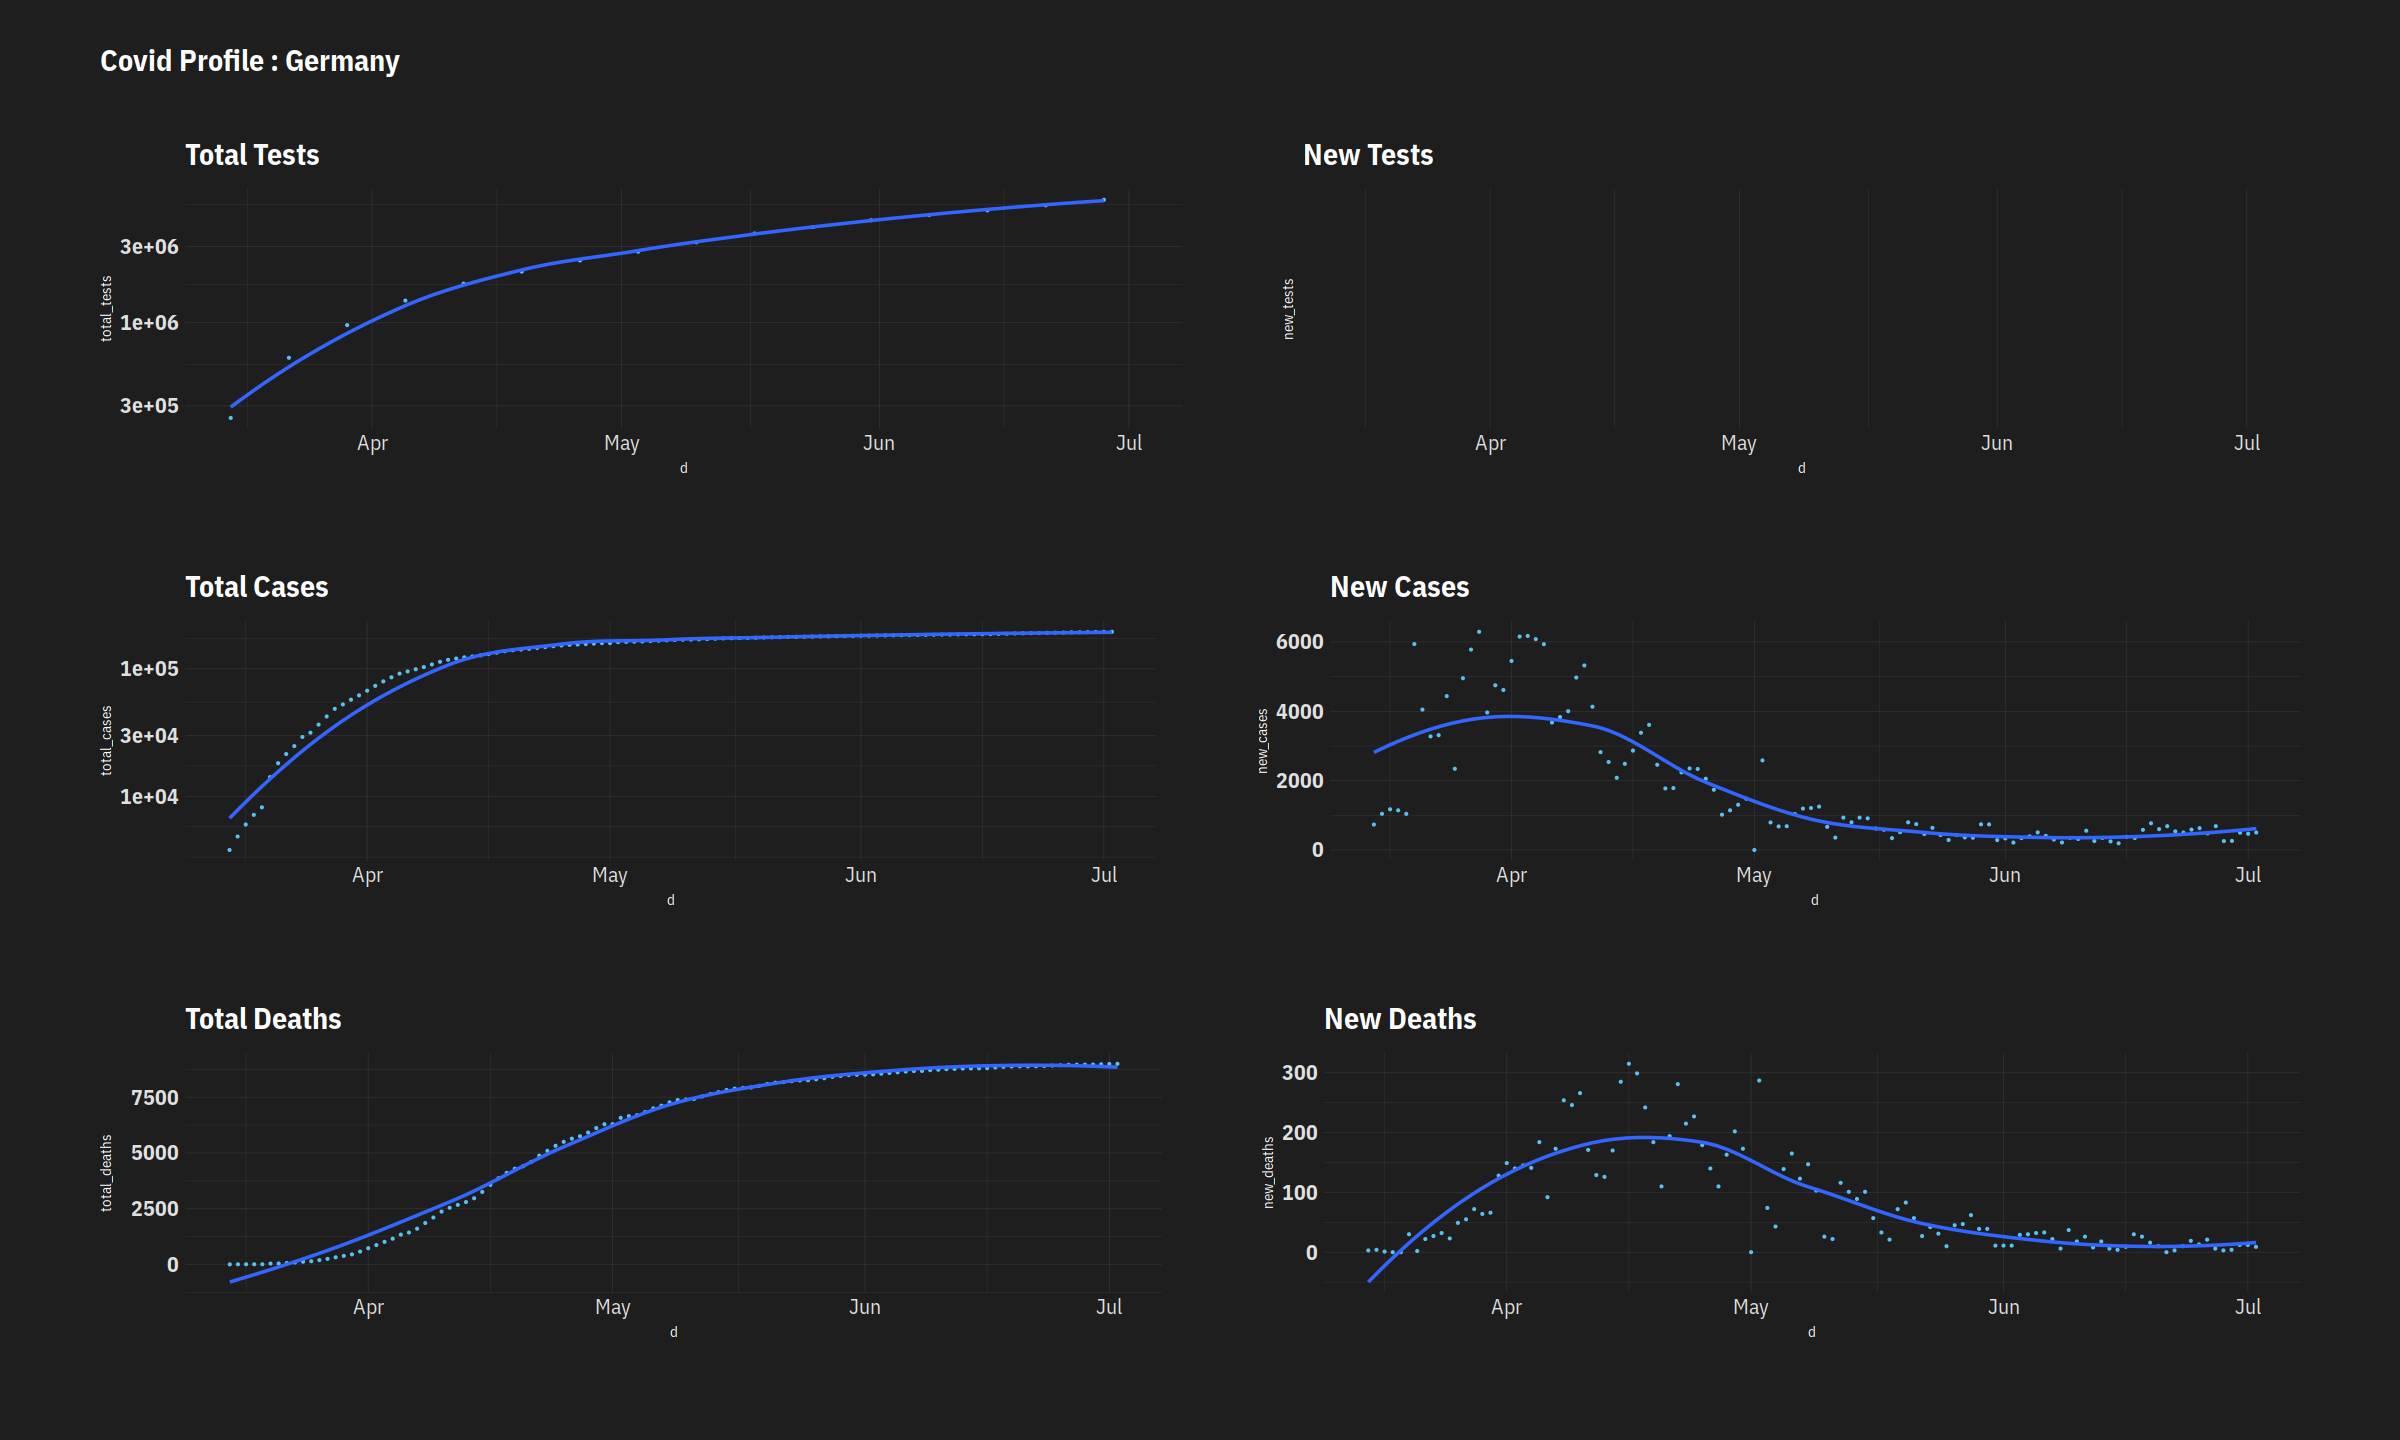

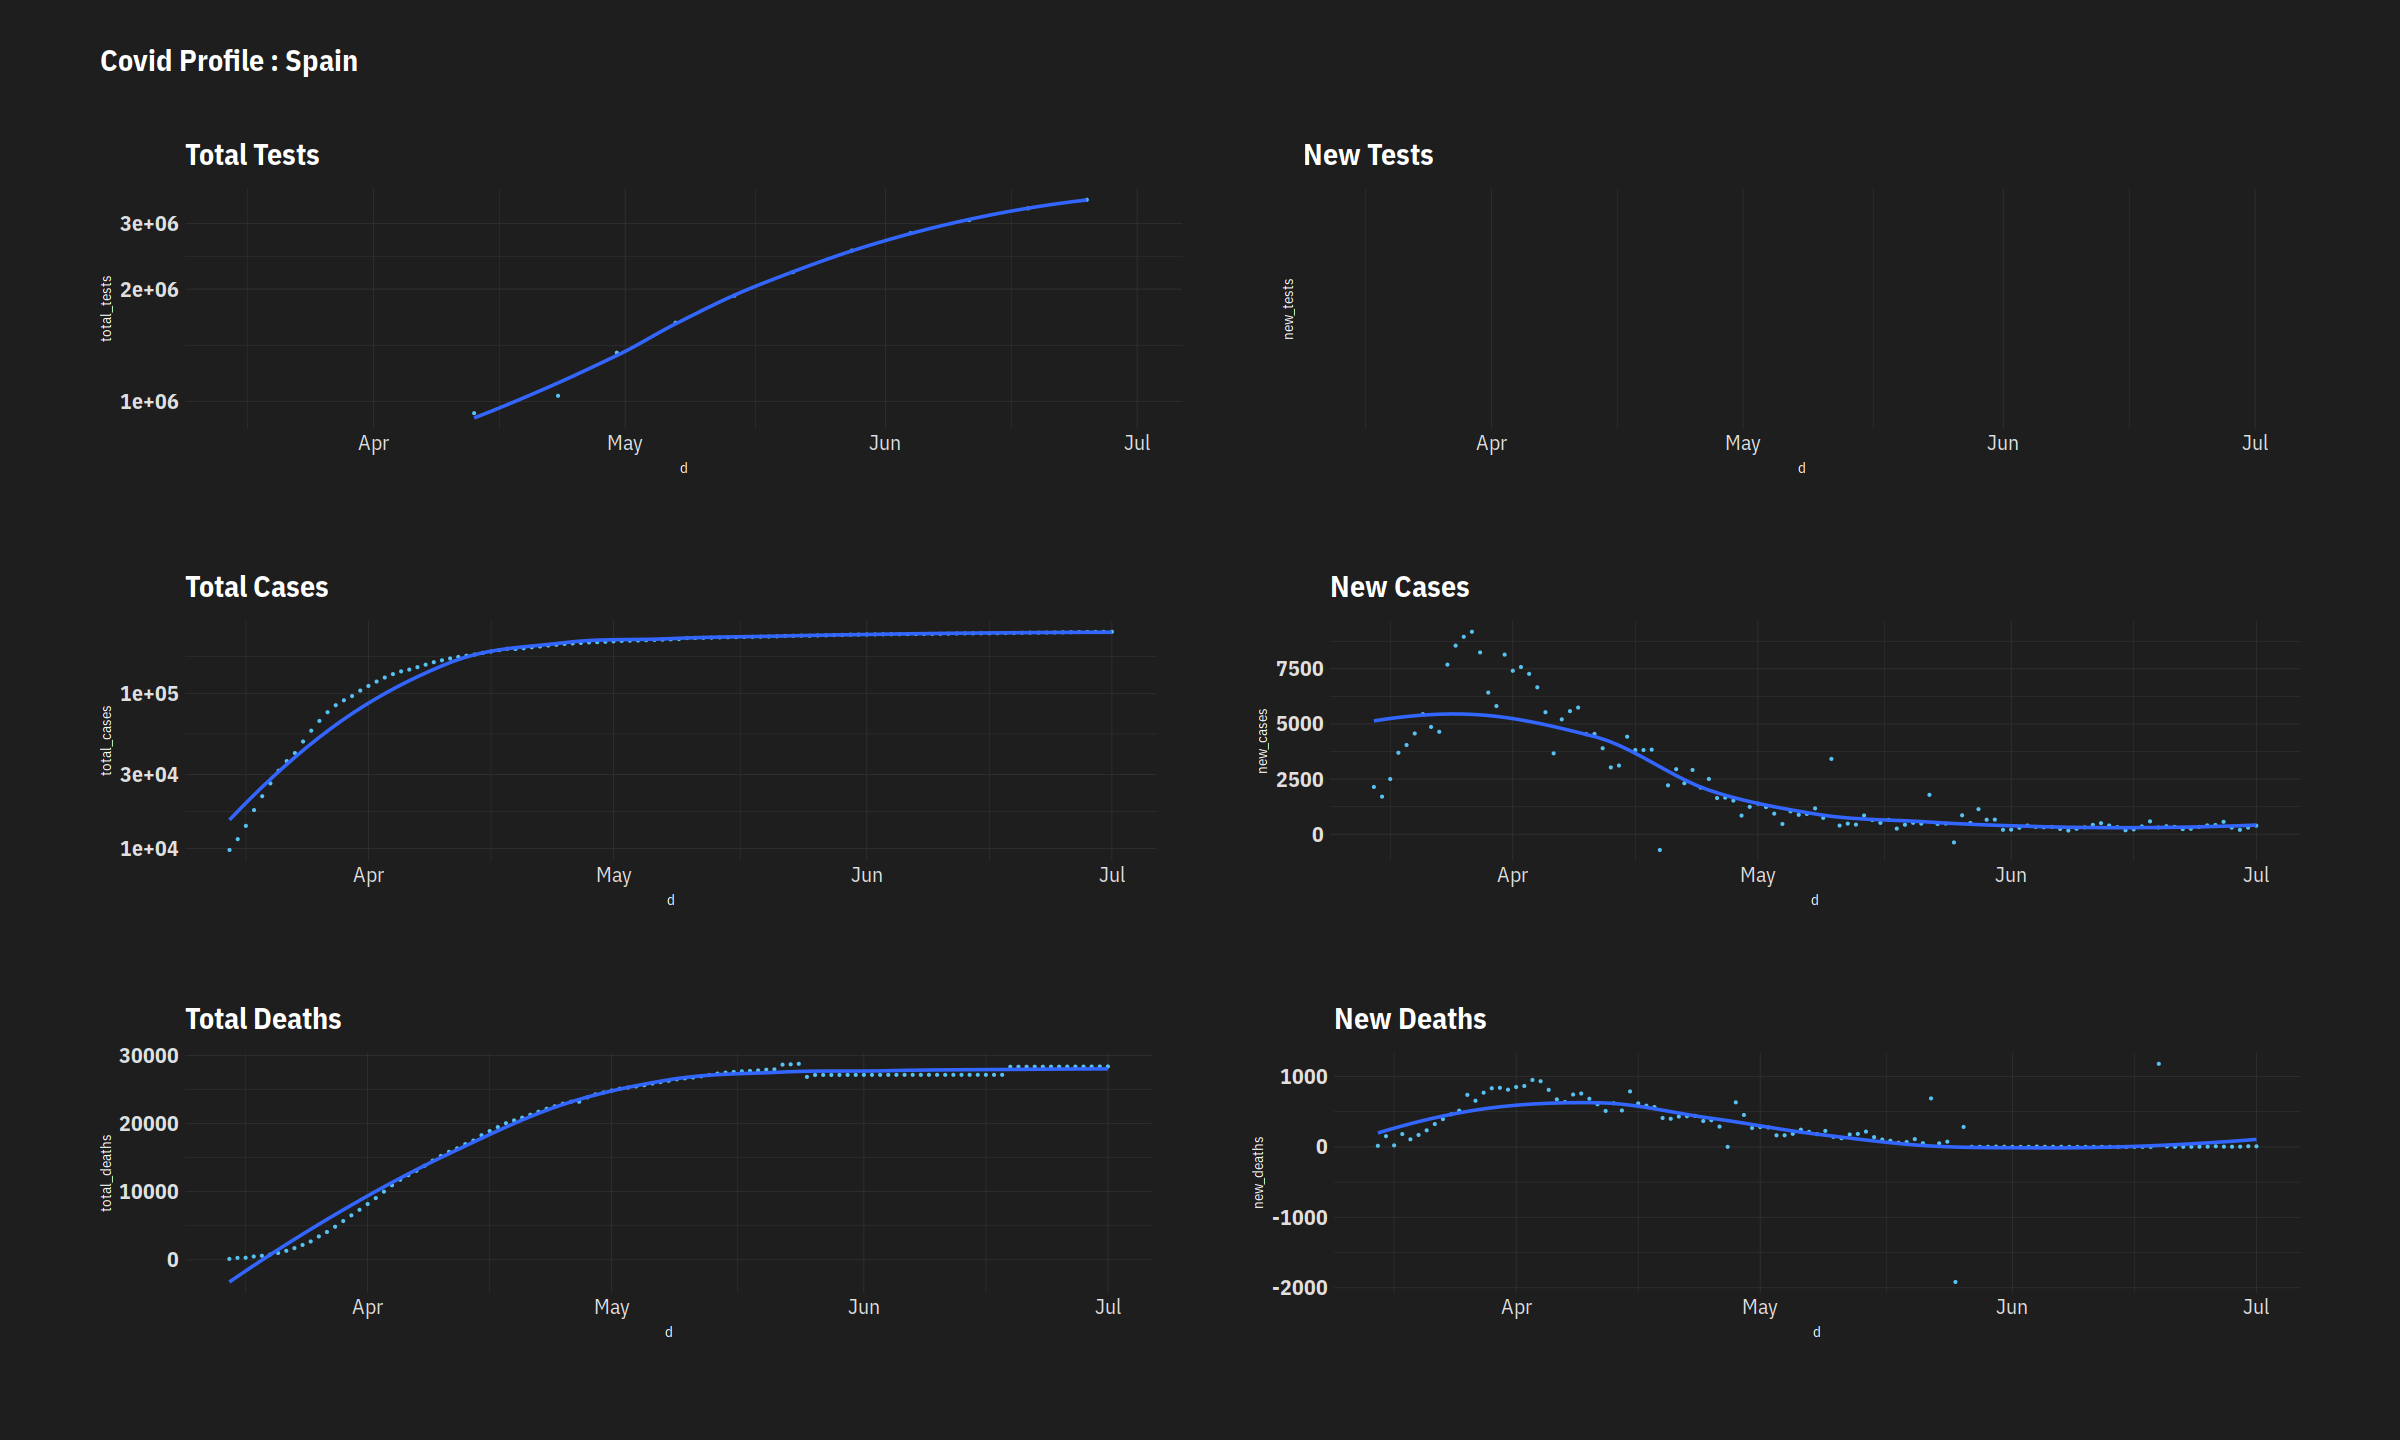

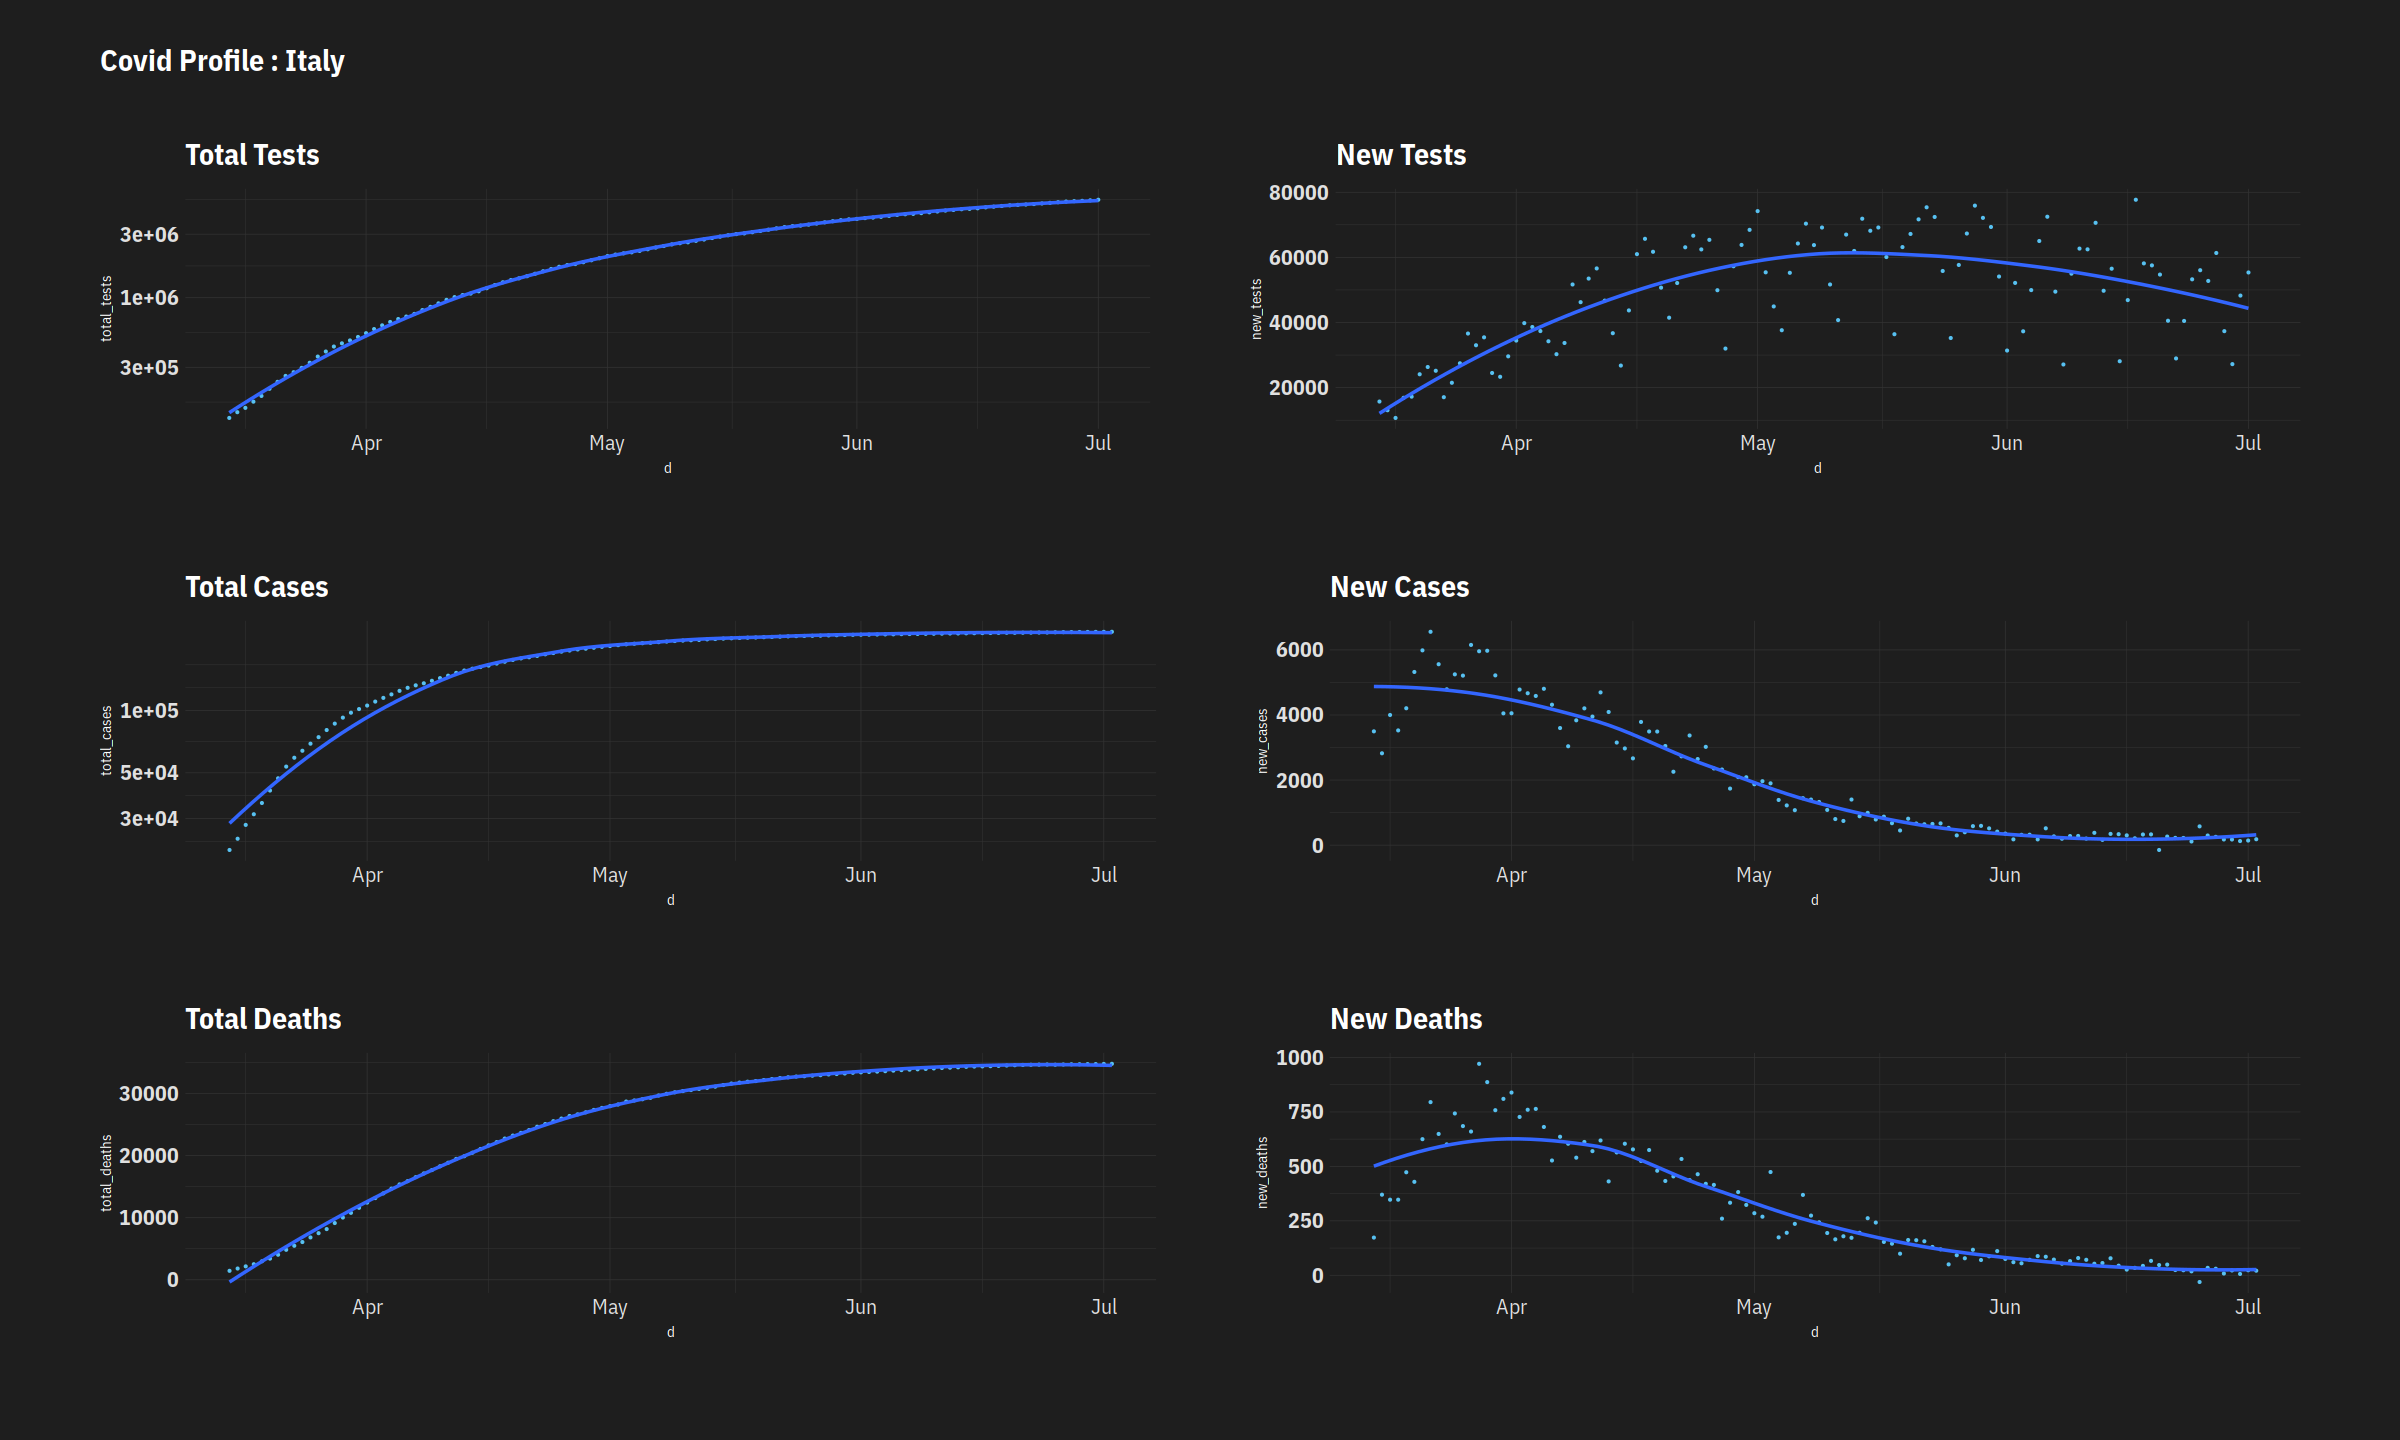

In [30]:
country_plot("United Kingdom")
country_plot("France")
country_plot("Germany")
country_plot("Spain")
country_plot("Italy")

# Excess Mortality

In [31]:
exmort_nyt = fread("https://raw.githubusercontent.com/nytimes/covid-19-data/master/excess-deaths/deaths.csv")
exmort_nyt[, `:=`(
             start_date = ymd(start_date),
             end_date   = ymd(start_date),
             year = as.numeric(year)
           )
           ]
exmort_nyt %>% glimpse

Warning message in eval(jsub, SDenv, parent.frame()):
“NAs introduced by coercion”


Rows: 6,712
Columns: 12
$ country         <chr> "Austria", "Austria", "Austria", "Austria", "Austria"…
$ placename       <chr> "", "", "", "", "", "", "", "", "", "", "", "", "", "…
$ frequency       <chr> "weekly", "weekly", "weekly", "weekly", "weekly", "we…
$ start_date      <date> 2020-01-06, 2020-01-13, 2020-01-20, 2020-01-27, 2020…
$ end_date        <date> 2020-01-06, 2020-01-13, 2020-01-20, 2020-01-27, 2020…
$ year            <dbl> 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020, 2020,…
$ month           <int> 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5,…
$ week            <int> 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1…
$ deaths          <int> 1702, 1797, 1778, 1947, 1678, 1721, 1715, 1768, 1744,…
$ expected_deaths <int> 1814, 1824, 1832, 1836, 1835, 1826, 1809, 1784, 1754,…
$ excess_deaths   <int> -112, -27, -54, 111, -157, -105, -94, -16, -10, -1, 1…
$ baseline        <chr> "2015-2019 historical data", "2015-2019 historical da…


In [32]:
exmort_nyt[, .N, by = .(country, placename, frequency)]

country        placename      frequency N  
1  Austria                       weekly    271
2  Belgium                       weekly    220
3  Brazil         Belem          monthly    53
4  Brazil         Fortaleza      monthly    53
5  Brazil         Manaus         monthly    53
6  Brazil         Recife         monthly    53
7  Brazil         Rio de Janeiro monthly    53
8  Brazil         Sao Paulo      monthly    53
9  Chile                         monthly    53
10 Denmark                       weekly    272
11 Ecuador        Guayas         monthly    32
12 Ecuador                       monthly    41
13 Finland                       weekly    169
14 France         Paris          weekly     51
15 France                        weekly    491
16 Germany                       weekly    219
17 Indonesia      Jakarta        monthly   125
18 Israel                        monthly    63
19 Italy          Bergamo        monthly     6
20 Italy          Milan          monthly     6
21 Italy                         monthly     8
22 Japan          Tokyo          monthly    56
23 Mexico         Mexico City    weekly    176
24 Netherlands                   weekly    221
25 Norway         Oslo           weekly    269
26 Norway                        weekly    269
27 Peru           Lima           monthly    53
28 Peru                          monthly    53
29 Portugal                      weekly    270
30 Russia         St. Petersburg monthly    65
31 Russia         Moscow         monthly    65
32 South Africa                  weekly     71
33 South Korea                   monthly    63
34 Spain          Catalonia      weekly    103
35 Spain          Madrid         weekly    105
36 Spain                         weekly    112
37 Sweden         Stockholm      weekly     68
38 Sweden                        weekly    272
39 Switzerland                   weekly    221
40 Thailand                      monthly    64
41 Turkey         Istanbul       weekly     60
42 United Kingdom London         weekly    270
43 United Kingdom                weekly    521
44 United States  Boston         weekly    268
45 United States  New York City  weekly    270
46 United States  Miami          monthly    65
47 United States  Chicago        weekly     60
48 United States  Denver         monthly    41
49 United States  Detroit        weekly    167
50 United States                 weekly     69

In [33]:
wksamp = exmort_nyt[frequency == "weekly" & year == 2020]

In [34]:
eur = exmort_nyt[country %in% c(
    'Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Italy', 'Netherlands', 
    'Norway', 'Portugal', 'Spain', 'Sweden', 'United Kingdom', "Switzerland"
    ) & year == 2020 & placename == ""]
eur[, .SD[1], by = country]

country        placename frequency start_date end_date   year month week
1  Austria                  weekly    2020-01-06 2020-01-06 2020 1      2  
2  Belgium                  weekly    2020-01-06 2020-01-06 2020 1      2  
3  Denmark                  weekly    2020-01-06 2020-01-06 2020 1      2  
4  Finland                  weekly    2020-01-06 2020-01-06 2020 1      2  
5  France                   weekly    2020-01-06 2020-01-06 2020 1      2  
6  Germany                  weekly    2020-01-06 2020-01-06 2020 1      2  
7  Italy                    monthly   <NA>       <NA>       2020 1     NA  
8  Netherlands              weekly    2020-01-06 2020-01-06 2020 1      2  
9  Norway                   weekly    2020-01-06 2020-01-06 2020 1      2  
10 Portugal                 weekly    2020-01-06 2020-01-06 2020 1      2  
11 Spain                    weekly    2020-01-06 2020-01-06 2020 1      2  
12 Sweden                   weekly    2020-01-06 2020-01-06 2020 1      2  
13 Switzerland              weekly    2020-01-06 2020-01-06 2020 1      2  
14 United Kingdom           weekly    2020-01-04 2020-01-04 2020 1      2  
   deaths expected_deaths excess_deaths baseline                 
1   1702   1814            -112         2015-2019 historical data
2   2368   2381             -13         2016-2019 historical data
3   1149   1121              28         2015-2019 historical data
4   1068   1155             -87         2017-2019 historical data
5  13404  13623            -219         2010-2019 historical data
6  19403  19652            -249         2016-2019 historical data
7  57517  60617           -3100         2015-2019 historical data
8   3364   3327              37         2016-2019 historical data
9    948    911              37         2015-2019 historical data
10  2654   2903            -249         2015-2019 historical data
11  8936   9211            -275         2018-2019 historical data
12  1890   1881               9         2015-2019 historical data
13  1348   1476            -128         2016-2019 historical data
14 16020  15469             551         2010-2019 historical data

In [35]:
eur[is.na(start_date), start_date := ymd(paste0(year, '-', month, "-01"))]
eur[, excess := fifelse(excess_deaths > 0, 1, 0)]

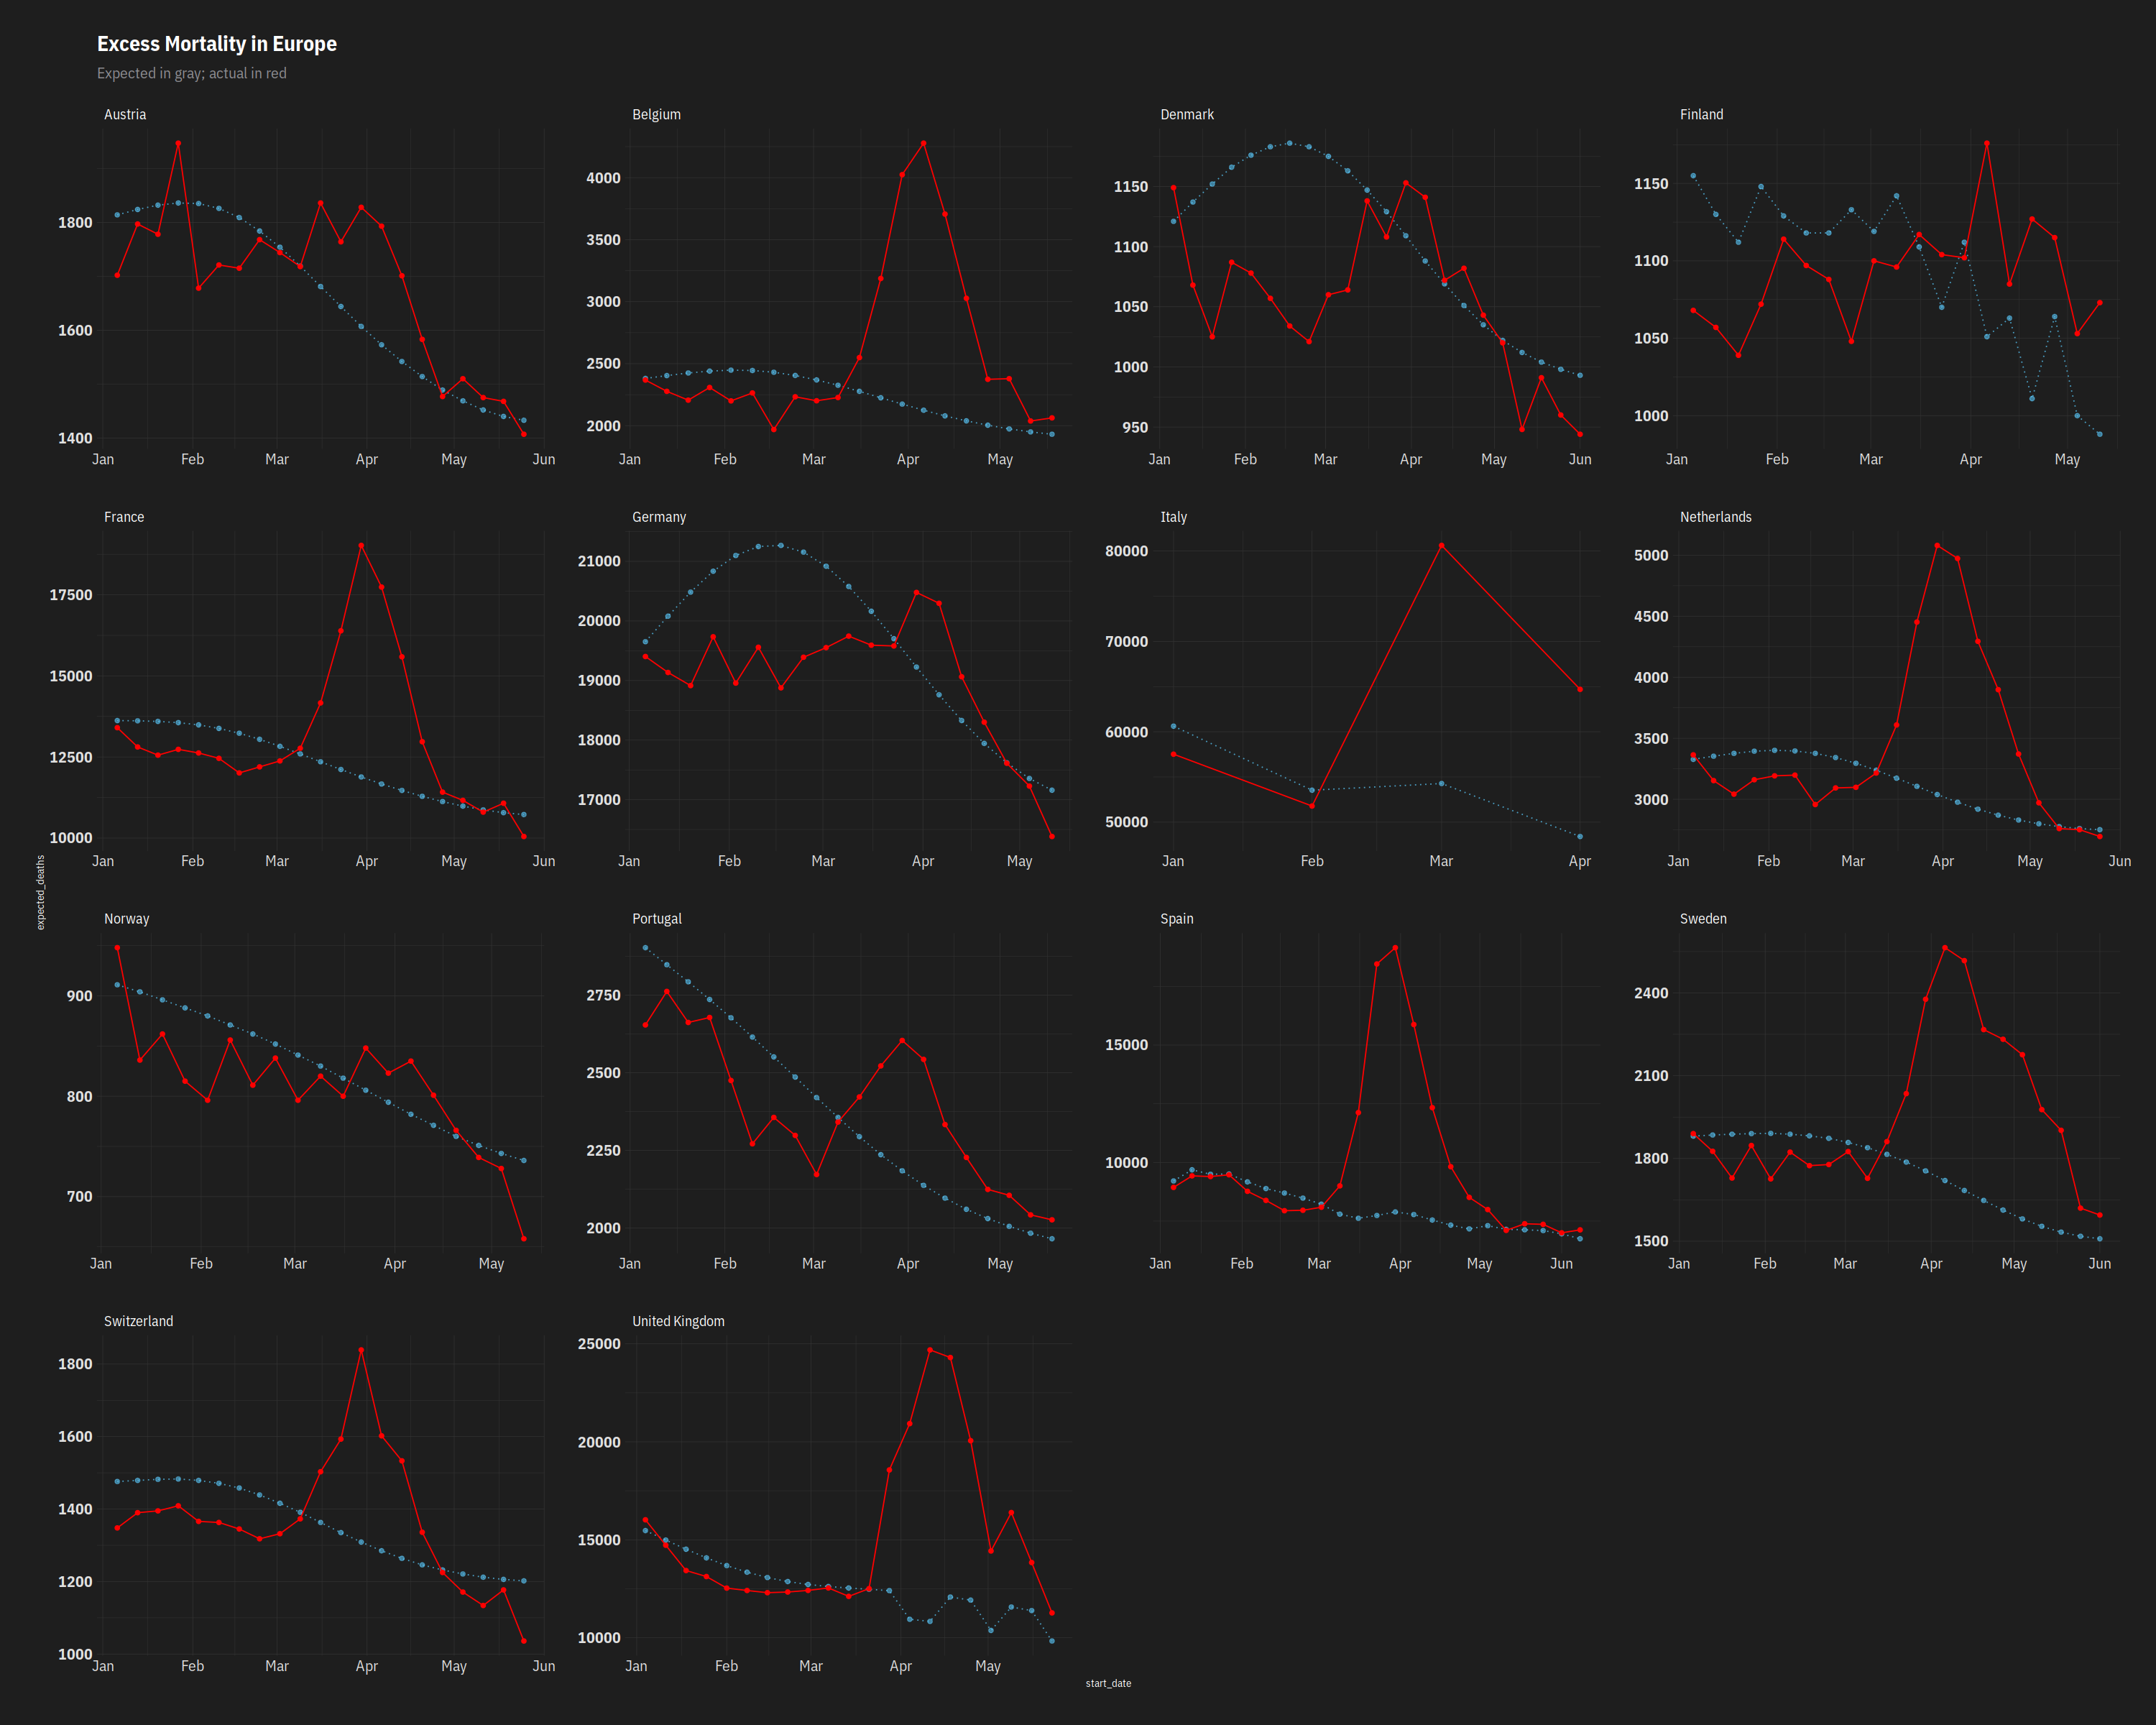

In [36]:
options(repr.plot.width = 25, repr.plot.height=20)
ggplot(eur, aes(x = start_date, y = expected_deaths)) +
    geom_point(alpha = 0.6) + geom_line(linetype = 'dotted', alpha = 0.8) +
    geom_point(aes(y = deaths), colour = 'red') + geom_line(aes(y = deaths), colour = 'red') +
    facet_wrap(~ country, scales = 'free') +
    labs(title = "Excess Mortality in Europe", subtitle = "Expected in gray; actual in red") 

In [37]:
us_samp = exmort_nyt[year == 2020 & country == "United States" & placename != ""]
us_samp[, dt := ifelse(is.na(start_date), year + month, year + month + week - 1)]
us_samp[, .SD[1:2], by = placename] 

placename     country       frequency start_date end_date   year month week
1  Boston        United States weekly    2020-01-05 2020-01-05 2020 1      2  
2  Boston        United States weekly    2020-01-12 2020-01-12 2020 1      3  
3  New York City United States weekly    2020-01-05 2020-01-05 2020 1      2  
4  New York City United States weekly    2020-01-12 2020-01-12 2020 1      3  
5  Miami         United States monthly   <NA>       <NA>       2020 1     NA  
6  Miami         United States monthly   <NA>       <NA>       2020 2     NA  
7  Chicago       United States weekly    2020-01-05 2020-01-05 2020 1      2  
8  Chicago       United States weekly    2020-01-12 2020-01-12 2020 1      3  
9  Denver        United States monthly   <NA>       <NA>       2020 1     NA  
10 Denver        United States monthly   <NA>       <NA>       2020 2     NA  
11 Detroit       United States weekly    2020-01-05 2020-01-05 2020 1      2  
12 Detroit       United States weekly    2020-01-12 2020-01-12 2020 1      3  
   deaths expected_deaths excess_deaths baseline                    dt  
1   373    395             -22          2015-2019 historical data   2022
2   389    392              -3          2015-2019 historical data   2023
3  1086   1194            -108          2015 - 2019 historical data 2022
4  1130   1145             -15          2015 - 2019 historical data 2023
5  1948   1941               7          2015 - 2019 historical data 2021
6  1813   1720              93          2015 - 2019 historical data 2022
7   894    906             -12          2017 - 2019 historical data 2022
8   857    899             -42          2017 - 2019 historical data 2023
9   415    417              -2          2017 - 2019 historical data 2021
10  385    381               4          2017 - 2019 historical data 2022
11  799    823             -24          2017 - 2019 historical data 2022
12  758    840             -82          2017 - 2019 historical data 2023

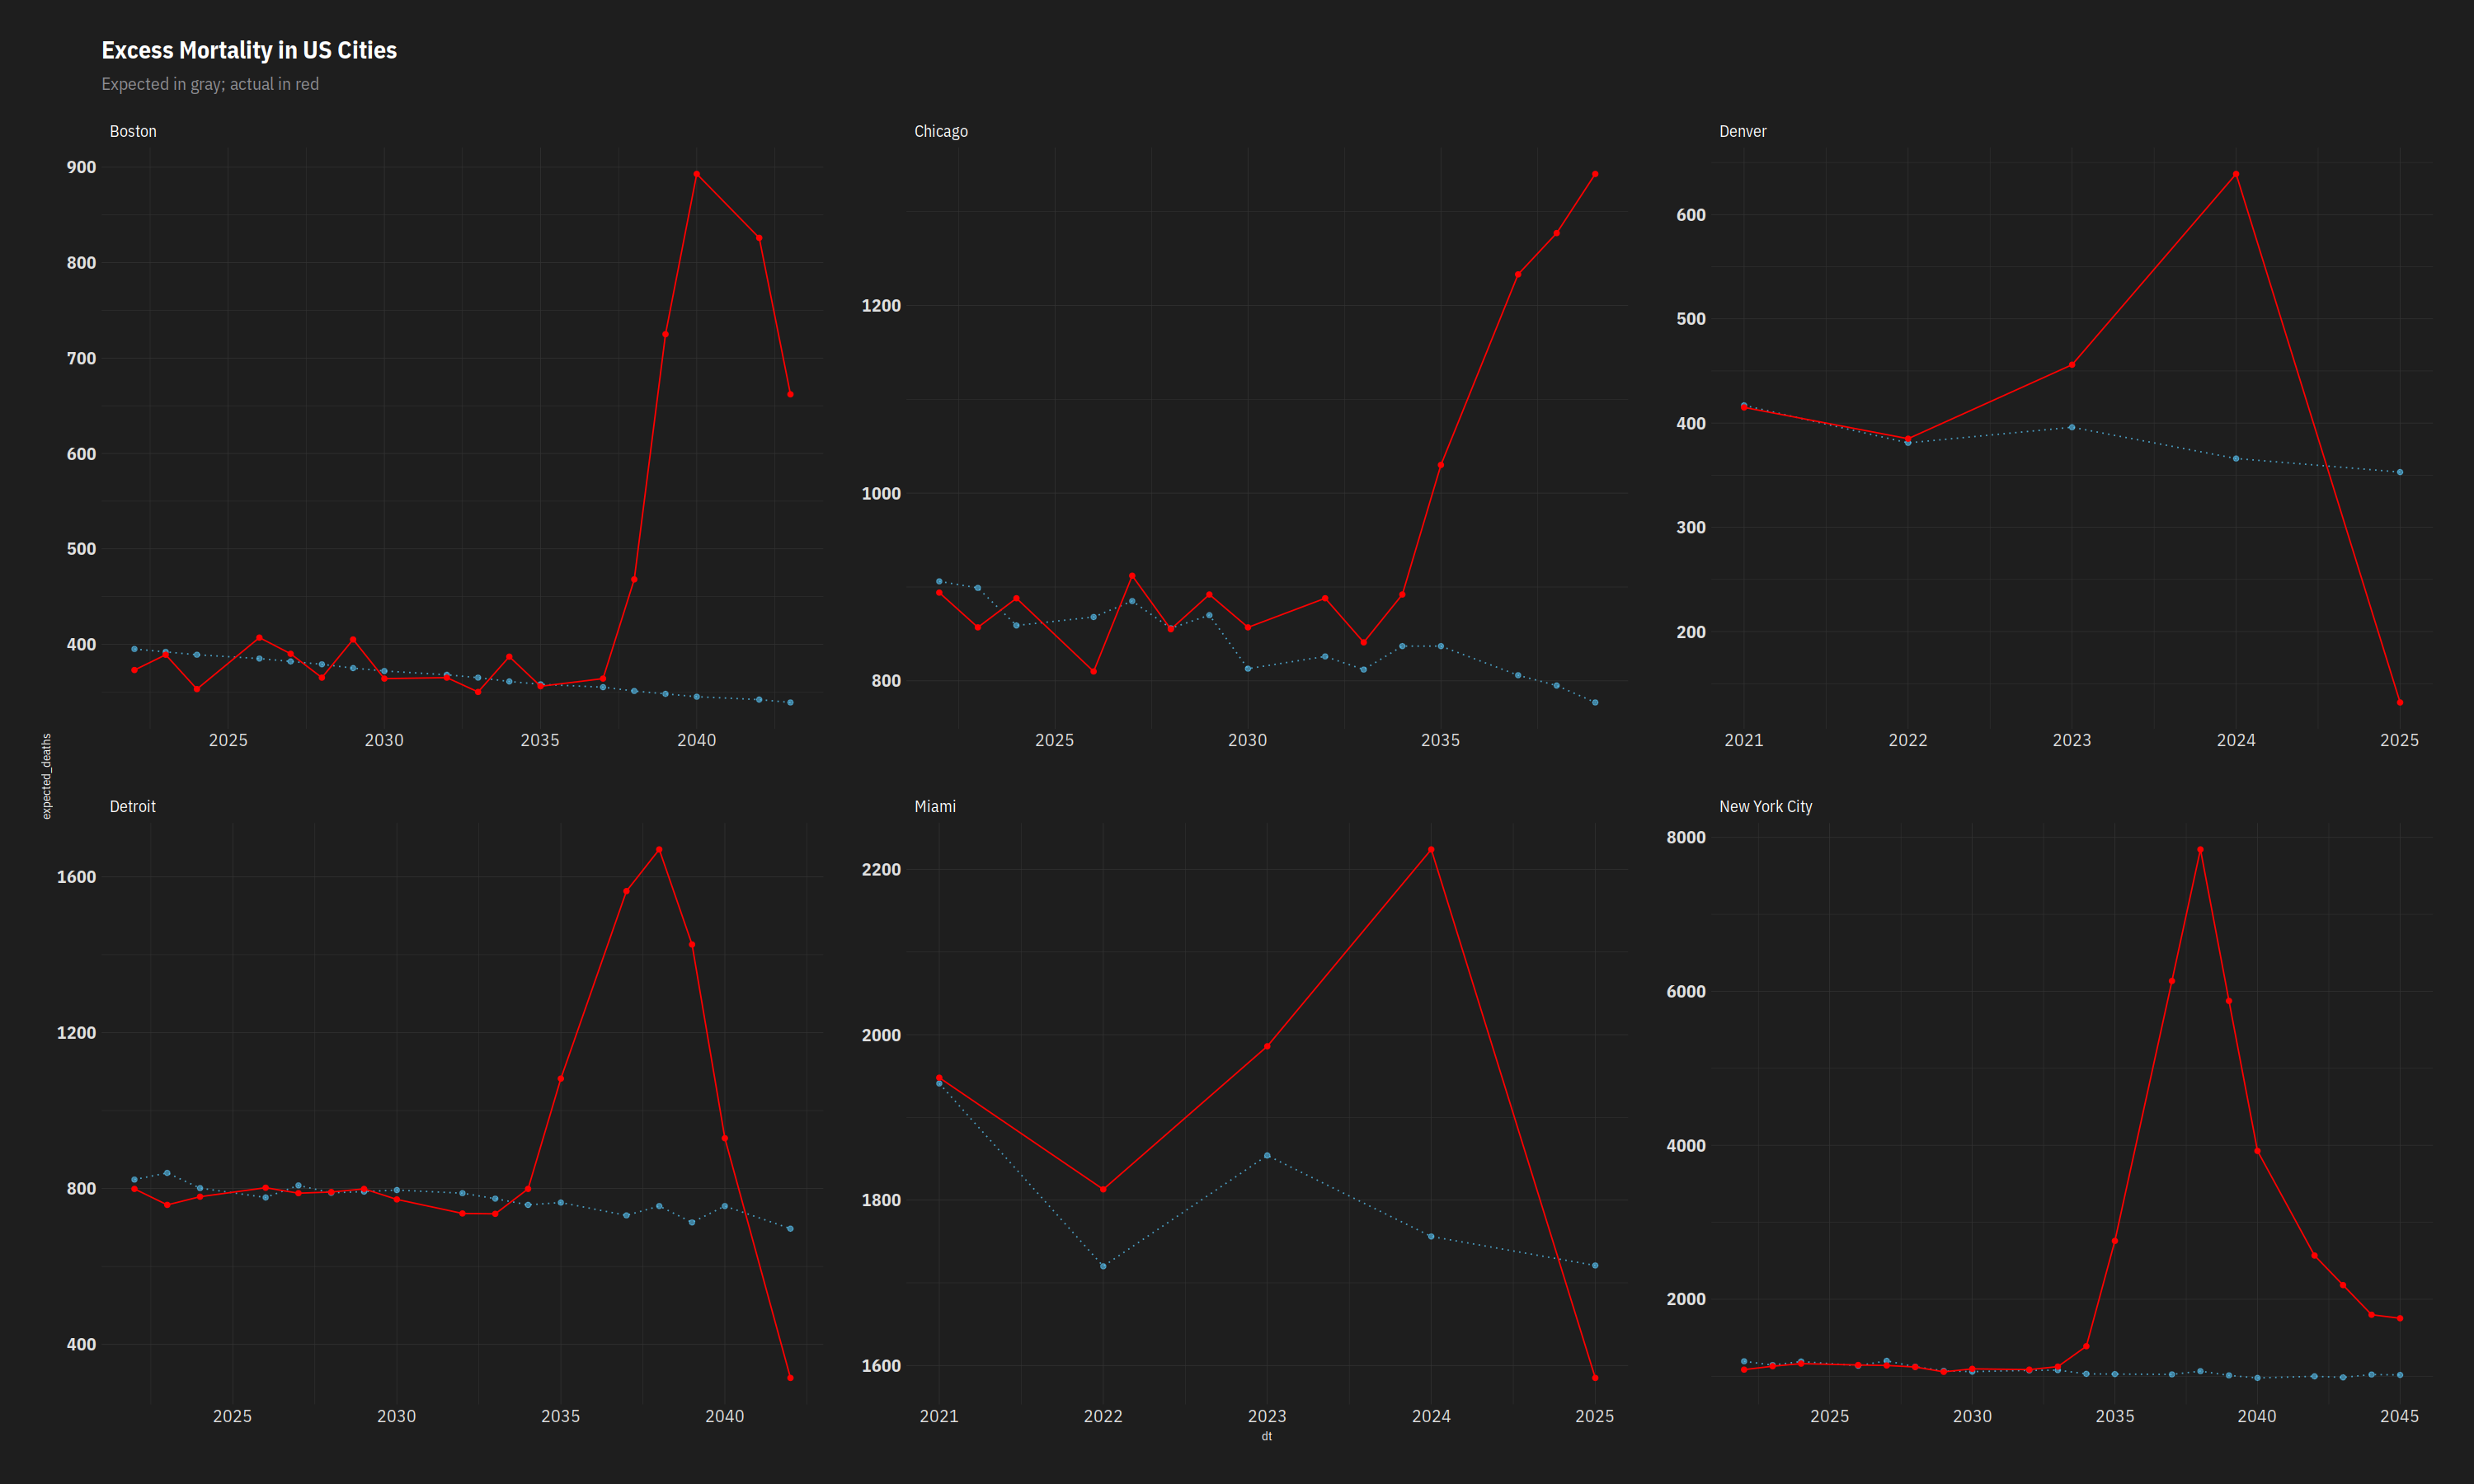

In [38]:
options(repr.plot.width = 25, repr.plot.height=15)
ggplot(us_samp, aes(x = dt, y = expected_deaths)) +
    geom_point(alpha = 0.6) + geom_line(linetype = 'dotted', alpha = 0.8) +
    geom_point(aes(y = deaths), colour = 'red') + geom_line(aes(y = deaths), colour = 'red') +
    facet_wrap(~ placename, scales = 'free') +
    labs(title = "Excess Mortality in US Cities", subtitle = "Expected in gray; actual in red") 